In [3]:
%env CUDA_VISIBLE_DEVICES=0

device='cuda'

env: CUDA_VISIBLE_DEVICES=0


In [4]:
if False:
    !pip install mtcnn
    !pip install timm==0.4.5
    !pip install tensorflow
    !pip install numba
    #!pip install keras==2.4.3
    #!pip install -q torch==1.7.1 torchvision
    !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from copy import deepcopy
from tqdm import tqdm

from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras.optimizers import Adam, SGD

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms

print(f"Torch: {torch.__version__}")

2024-01-10 21:09:40.520776: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 21:09:40.551032: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 21:09:40.551065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 21:09:40.551084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 21:09:40.557260: I tensorflow/core/platform/cpu_feature_g

Torch: 2.1.0+cu118


In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

In [7]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Reserved:    0.0 GB


In [8]:
CONVERT2INT=True
if CONVERT2INT is True:
    N_CLASSES = 2
else:
    N_CLASSES = 4

#### Helpers

In [9]:
import pickle

def save_features(file_name, features):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    with open(file_name, 'wb') as f:
        pickle.dump(features, f) # , protocol=pickle.HIGHEST_PROTOCOL)
    
def load_features(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def save_weights(model, file_name):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    model.save_weights(file_name)

def load_weights(model, file_name):
    model.load_weights(file_name)

In [10]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

def extract_features(root_dir, directories):
    all_features = []
    for i, d in enumerate(directories):
        if d.startswith('.'):
            continue
        print('[{}/{}]'.format(i+1, len(directories)), end="\r") 
        imgs = []
        sequence = []
        path = os.path.join(root_dir, d)
        for img in os.listdir(path):
            if not img.endswith(ext):
                continue
            img_file = os.path.join(path, img)
            if torch_model:
                image = Image.open(img_file)
                img_tensor = test_transforms(image)
                imgs.append(img_tensor)
            else:
                image = cv2.imread(img_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)
            
            if len(imgs) >= BATCH_SIZE:
                if torch_model:
                    features = cnn_model(torch.stack(imgs, dim=0).to(device))
                    features = features.data.cpu().numpy()
                else:
                    features = cnn_model.predict(np.array(imgs), verbose=0)
                if len(sequence) == 0:
                    sequence = features
                else:
                    sequence = np.concatenate((sequence, features),axis=0)
                imgs = []
                
        if len(imgs) > 0:        
            if torch_model:
                features = cnn_model(torch.stack(imgs, dim=0).to(device))
                features = features.data.cpu().numpy()
            else:
                features = cnn_model.predict(np.array(imgs), verbose=0)
            if len(sequence) == 0:
                sequence = features
            else:
                sequence = np.concatenate((sequence, features),axis=0)
        
        all_features.append(sequence)
    return all_features

def extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files):
    if os.path.isfile(train_pickle):
        train_features, train_data_files = load_features(train_pickle)
    else:
        print("Create train dataset")
        train_features = extract_features(train_dir, train_data_files)
        save_features(train_pickle, [train_features, train_data_files])
    if os.path.isfile(test_pickle):
        test_features, test_data_files = load_features(test_pickle)
    else:
        print("Create test dataset")
        test_features = extract_features(val_dir, test_data_files)
        save_features(test_pickle, [test_features, test_data_files])
    return train_features, train_data_files, test_features, test_data_files

In [11]:
def create_file2features(files, features):
    res = {}
    for i in range(len(files)):
        res[files[i]] = features[i]
    return res

## Prepare dataset

In [12]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/engagement/'
ext = "png"

In [13]:
import csv
labels_list = ['distracted', 'engaged']
video2label={}
float2int={0:0,0.33:1,0.66:2,1:3}
float2int={0:0,0.33:0,0.66:1,1:1}

import csv
video2label={}
with open(os.path.join(DATA_DIR,'Engagement_Labels_Engagement.csv'), mode='r') as csvfile:
    labels_reader = csv.reader(csvfile, delimiter='\t')
    for i,row in enumerate(labels_reader):
        if i==0:
            print('first:',row)
            continue
        videoname,label=row[0],float(row[1])
        video2label[videoname]=label
        #print(videoname,label)
        #if (videoname not in filename2features_val) and (videoname not in filename2features_train):
        #    print(videoname,label)
#check if fix is incorrect
video2label['subject_87_Vid_3']=video2label['subject_77_Vid_6']
#video2label = to_categorical(video2label)
print(len(video2label))
print(video2label)

first: ['subject', 'label']
196
{'subject_1_Vid_1': 1.0, 'subject_1_Vid_2': 1.0, 'subject_1_Vid_3': 0.66, 'subject_1_Vid_4': 1.0, 'subject_1_Vid_5': 1.0, 'subject_31_Vid_6': 1.0, 'subject_2_Vid_6': 0.33, 'subject_3_Vid_6': 1.0, 'subject_3_Vid_1': 0.33, 'subject_3_Vid_2': 0.33, 'subject_3_Vid_3': 0.66, 'subject_3_Vid_4': 0.66, 'subject_3_Vid_5': 0.33, 'subject_3_Vid_7': 1.0, 'subject_4_Vid_6': 1.0, 'subject_5_Vid_6': 1.0, 'subject_6_Vid_6': 0.33, 'subject_7_Vid_1': 0.66, 'subject_7_Vid_2': 0.66, 'subject_7_Vid_3': 0.66, 'subject_7_Vid_4': 0.66, 'subject_7_Vid_5': 0.33, 'subject_8_Vid_6': 1.0, 'subject_9_Vid_6': 0.0, 'subject_10_Vid_6': 0.66, 'subject_11_Vid_6': 1.0, 'subject_12_Vid_6': 0.0, 'subject_13_Vid_6': 0.66, 'subject_14_Vid_6': 0.66, 'subject_15_Vid_6': 0.66, 'subject_16_Vid_6': 0.33, 'subject_17_Vid_6': 0.66, 'subject_18_Vid_6': 0.33, 'subject_19_Vid_6': 1.0, 'subject_20_Vid_6': 0.66, 'subject_20_Vid_1': 0.66, 'subject_20_Vid_2': 0.66, 'subject_20_Vid_3': 0.66, 'subject_20_Vid_

In [14]:
INPUT_SIZE = (224, 224)
model_urls = {
    #'affectnet_7_vggface2_rexnet150.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/affectnet_7_vggface2_rexnet150.pt',
    'enet_b0_7.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/enet_b0_7.pt',
    'enet_b0_8_best_afew.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/enet_b0_8_best_afew.pt',
    'enet_b0_8_best_vgaf.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/enet_b0_8_best_vgaf.pt',
    'enet_b2_7.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/enet_b2_7.pt',
    'enet_b2_8.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/enet_b2_8.pt',
    'mobilenet_7.h5': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/b55d78c7d2a4c02339de916936fc73749eb58798/models/affectnet_emotions/mobilenet_7.h5',
    'enet_b0_8_va_mtl.pt': 'https://github.com/HSE-asavchenko/face-emotion-recognition/raw/24c7b22228f88429bf11c64f1f3f292b8e8abe32/models/affectnet_emotions/enet_b0_8_va_mtl.pt',
}

def download_model(model_url, model_name):
    import urllib.request

    if not os.path.isfile(model_name):
        urllib.request.urlretrieve(model_url, model_name)

In [15]:
FEATURES_DIR = "features/"
WEIGHTS_DIR = 'weights/'

In [39]:
def print_acc(model,filename2features):
    num_correct,num_total=0,0
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        if CONCATENATE_STAT:
            stat_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
            inp = np.expand_dims(np.concatenate((stat_x,x),axis=1), axis=0)
            preds=model.predict(inp, verbose=0)[0]
        else:
            preds=model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
        if np.argmax(preds) == float2int[video2label[fn]]:
            num_correct+=1
        num_total+=1
    print(num_total,num_correct/num_total)
    
def print_acc(model, test_features, test_labels):
    num_correct,num_total=0,0
    res_preds = []
    res_labels = []
    for i in range(len(test_features)):
        features=test_features[i]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        if CONCATENATE_STAT:
            stat_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
            inp = np.expand_dims(np.concatenate((stat_x,x),axis=1), axis=0)
            preds=model.predict(inp, verbose=0)[0]
        else:
            preds=model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
        res_preds.append(np.argmax(preds))
        res_labels.append(test_labels[i])
        if res_preds[-1] == test_labels[i]:
            num_correct+=1
        num_total+=1
    acc = num_correct/num_total
    print(num_total, acc)
    return acc, res_preds, res_labels

### Facial images

In [15]:
FACES_DIR = os.path.join(DATA_DIR, "frames/faces/mtcnn_aligned")

In [16]:
train_dir = os.path.join(FACES_DIR, "Train")
val_dir = os.path.join(FACES_DIR, "validation")
train_data_files = os.listdir(train_dir)
test_data_files = os.listdir(val_dir)
print(len(train_data_files))
print(len(test_data_files))

147
48


In [17]:
def print_classes(files):
    labels = []
    for f in files:
        labels.append(float2int[video2label[f]])
    min_num = len(files)
    for i in range(N_CLASSES):
        count = labels.count(i)
        if count < min_num:
            min_num = count
        percent = count * 100 / len(labels)
        print("{} {}/{}: {}%".format(i, count, len(labels), percent))
    return min_num

print("Train:")
train_min_num = print_classes(train_data_files)
print("Test:")
test_min_num = print_classes(test_data_files)

Train:
0 40/147: 27.210884353741495%
1 107/147: 72.78911564625851%
Test:
0 14/48: 29.166666666666668%
1 34/48: 70.83333333333333%


In [17]:
def adjust_classes(files, min_num):
    tmp_files = []
    for i in range(N_CLASSES):
        filtered_files = []
        for j in range(len(files)):
            if len(filtered_files) == min_num:
                break
            label = float2int[video2label[files[j]]]
            if label == i:
                filtered_files.append(files[j])
        tmp_files.extend(filtered_files)
        
    res_files = []
    indices = list(range(len(tmp_files)))
    random.seed(7)
    random.shuffle(indices)
    for idx in indices:
        res_files.append(tmp_files[idx])
    
    return res_files

train_data_files = adjust_classes(train_data_files, train_min_num)
print(len(train_data_files))
test_data_files = adjust_classes(test_data_files, test_min_num)
print(len(test_data_files))

80
28


In [18]:
print("Train:")
print_classes(train_data_files)
print("Test:")
print_classes(test_data_files)

Train:
0 40/80: 50.0%
1 40/80: 50.0%
Test:
0 14/28: 50.0%
1 14/28: 50.0%


14

In [18]:
def write_or_read_file_names(pickle_name, train_data_files, test_data_files):
    if os.path.isfile(pickle_name):
        return load_features(pickle_name)
    else:
        save_features(pickle_name, [train_data_files, test_data_files])
    return train_data_files, test_data_files

train_data_files, test_data_files = write_or_read_file_names("ajusted_classes.pickle", train_data_files, test_data_files)

In [19]:
SPLIT_RATIO = len(train_data_files) / (len(train_data_files) + len(test_data_files))
print(SPLIT_RATIO)

0.7407407407407407


## Prepare custom dataset

In [16]:
USERS_DATASET = "/home/halcon_user/engagement/Engagement_dataset/"

DISTRACTED_DIR = os.path.join(USERS_DATASET, "distracted/")
ENGAGED_DIR = os.path.join(USERS_DATASET, "engaged/")
DISTRACTED_DIR_FACES = os.path.join(USERS_DATASET, "distracted_faces/")
ENGAGED_DIR_FACES = os.path.join(USERS_DATASET, "engaged_faces/")

In [17]:
def get_total_frames(video_file):
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

def get_video_frames(video_file, n_frames=1, frame_processor=None):
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//n_frames
    for frame_count in range(n_frames,n_frames*(total_frames+1),n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_count)
        ret, frame_bgr = cap.read()
        if not ret:
            cap.release()
            break
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        if frame_processor is not None:
            frame = frame_processor(frame)
        yield frame

def preprocess(frame):
    from functools import wraps
    import sys
    import io
    def capture_output(func):
        """Wrapper to capture print output."""

        @wraps(func)
        def wrapper(*args, **kwargs):
            old_stdout = sys.stdout
            new_stdout = io.StringIO()
            sys.stdout = new_stdout
            try:
                return func(*args, **kwargs)
            finally:
                sys.stdout = old_stdout

        return wrapper
    
    detector = MTCNN()
    w_detect_face = capture_output(detector.detect_faces)
    detected = w_detect_face(frame)
    if len(detected) == 0:
        return None
    face = detected[0]
    x1, y1, w, h = face['box'][0:4]
    x2 = x1 + w
    y2 = y1 + h
    frame = frame[y1:y2, x1:x2, :]
    return cv2.resize(frame, INPUT_SIZE)

def process_videos(video_dir, result_dir):
    for vid in os.listdir(video_dir):
        vid_path = os.path.join(video_dir, vid)
        out_path = os.path.join(result_dir, vid.split('.')[0])
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        else:
            print("Skipping: ", vid)
            continue
        total_frames = get_total_frames(vid_path)
        frames = get_video_frames(vid_path, frame_processor=preprocess)
        for i, f in enumerate(frames):
            print("[{}: {}/{}] ".format(vid, i, total_frames), end='\r')
            if f is None:
                continue
            cv2.imwrite(os.path.join(out_path, str(i) + '.png'), cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
        print()

In [21]:
process_videos(DISTRACTED_DIR, DISTRACTED_DIR_FACES)
process_videos(ENGAGED_DIR, ENGAGED_DIR_FACES)

Skipping:  Katya 4 distracted.mp4
Skipping:  Egor_distracted_3.mp4
Skipping:  Den_distracted_3.mp4
Skipping:  Den_distracted_15.mp4
Skipping:  Katya 1 distracted.mp4
Skipping:  Egor_distracted_14.mp4
Skipping:  Egor_distracted_9.mp4
Skipping:  Den_distracted_6.mp4
Skipping:  Yana_distracted_5.MOV
Skipping:  Den_distracted_13.mp4
Skipping:  Yana_distracted_11.MOV
Skipping:  Den_distracted_1.mp4
Skipping:  Katya 6 distracted.mp4
Skipping:  Yana_distracted_1.MOV
Skipping:  Katya 5 distracted.mp4
Skipping:  Katya 3 distracted.mp4
Skipping:  Yana_distracted_3.MOV
Skipping:  Den_distracted_12.mp4
Skipping:  Egor_distracted_4.mp4
Skipping:  Kate_distracted_2.mp4
Skipping:  Den_distracted_2.mp4
Skipping:  Kate_distracted_16.mp4
Skipping:  Egor_distracted_8.mp4
Skipping:  Kate_distracted_8.mp4
Skipping:  Kate_distracted_1.mp4
Skipping:  Katya 13 distracted.mp4
Skipping:  Yana_distracted_4.MOV
Skipping:  Egor_distracted_2.mp4
Skipping:  Katya 15 distracted.mp4
Skipping:  Den_distracted_11.mp4
Sk

### Extract all features

In [18]:
def get_frames_paths(directory):
    video2frames = {}
    for video_dir in os.listdir(directory):
        print(video_dir)
        path = os.path.join(directory, video_dir)
        total_files = len(os.listdir(path))
        video2frames[video_dir] = []
        i = 0
        while i < total_files:
            file_name = str(i) + ".png"
            file_path = os.path.join(path, file_name)
            i += 1
            if not os.path.exists(file_path):
                total_files += 1
                print(file_path)
                continue
            video2frames[video_dir].append(file_path)
    return video2frames

engaged2frames = get_frames_paths(ENGAGED_DIR_FACES)
distracted2frames = get_frames_paths(DISTRACTED_DIR_FACES)

Den_engaged_15
Yana_engaged_5
Katya 12 engaged
Egor_engaged_15
Kate_engaged_6
Katya 3 engaged
Katya 6 engaged
Den_engaged_6
Kate_engaged_4
Katya 15 engaged
Yana_engaged_14
Yana_engaged_7
Egor_engaged_16
Yana_engaged_1
Yana_engaged_15
Egor_engaged_2
Egor_engaged_3
Den_engaged_16
Egor_engaged_6
Den_engaged_4
Yana_engaged_13
Katya 13 engaged
Kate_engaged_1
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Kate_engaged_1/0.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Kate_engaged_1/1.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Kate_engaged_1/2.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Kate_engaged_1/3.png
Egor_engaged_13
Katya 4 engaged
Yana_engaged_8
Den_engaged_14
Katya 7 engaged
Yana_engaged_4
Kate_engaged_7
Katya 11 engaged
Katya 9 engaged
Kate_engaged_5
Kate_engaged_13
Kate_engaged_14
Egor_engaged_8
Yana_engaged_12
Egor_engaged_14
Yana_engaged_16
Egor_engaged_7
Yana_engaged_3
Katya 16 engaged
Egor_engaged_1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290454.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290455.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290456.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290457.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290458.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290459.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290460.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290461.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290462.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290463.png
/home/halcon_user/engagement/Engagement_dataset/engaged_faces/Egor_engaged_10/1290464.png
/home/halc

KeyboardInterrupt: 

In [18]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

def extract_features_my_ds(vid2frame, label):
    vid2features = {}
    #import re
    for j, k in enumerate(vid2frame.keys()):
        print('[{}/{}]'.format(j+1, len(vid2frame)), end="\r")
        #actor_name = re.split(" |_", k)[0]
        vid2features[k] = {}
        imgs = []
        sequence = []
        for i, vid in enumerate(vid2frame[k]):
            img_file = vid
            if torch_model:
                image = Image.open(img_file)
                img_tensor = test_transforms(image)
                imgs.append(img_tensor)
            else:
                image = cv2.imread(img_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)
            
            if len(imgs) >= BATCH_SIZE:
                if torch_model:
                    features = cnn_model(torch.stack(imgs, dim=0).to(device))
                    features = features.data.cpu().numpy()
                else:
                    features = cnn_model.predict(np.array(imgs), verbose=0)
                if len(sequence) == 0:
                    sequence = features
                else:
                    sequence = np.concatenate((sequence, features),axis=0)
                imgs = []  
        if len(imgs) > 0:        
            if torch_model:
                features = cnn_model(torch.stack(imgs, dim=0).to(device))
                features = features.data.cpu().numpy()
            else:
                features = cnn_model.predict(np.array(imgs), verbose=0)
            if len(sequence) == 0:
                sequence = features
            else:
                sequence = np.concatenate((sequence, features),axis=0)
        
        vid2features[k]['features'] = sequence
        vid2features[k]['label'] = label 
    print()
    return vid2features

def extract_or_read_features_my_ds(file_pickle, vid2frame = None, label: int = -1):
    if os.path.isfile(file_pickle):
        vid2features = load_features(file_pickle)
    elif vid2frame is None or label < 0:
        raise Exception("Cannot read file: ", file_pickle)
    else:
        vid2features = extract_features_my_ds(vid2frame, label)
        save_features(file_pickle, vid2features)
    return vid2features

In [18]:
for base_model_key in model_urls.keys():
    print("Model: ", base_model_key)
    download_model(model_urls[base_model_key], base_model_key)
    base_model_name = './' + base_model_key
    torch_model = True if base_model_name[base_model_name.rfind('.') + 1:] == 'pt' else False
    if torch_model:
        BATCH_SIZE = 64
    else:
        BATCH_SIZE = 128
        
    if base_model_key in ('enet_b2_7.pt', 'enet_b2_8.pt'):
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier,torch.nn.Softmax(dim=0))
        if True:
            inp = torch.randn(1408).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
        #print(cnn_model)
    elif base_model_key in ('enet_b0_8_va_mtl.pt'):
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier,torch.nn.Softmax(dim=1))
        if True:
            inp = torch.randn(20, 1280).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
        #print(cnn_model)
    elif torch_model:
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier[0],torch.nn.Softmax(dim=1))
        if True:
            inp = torch.randn(20, 1280).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
    else:
        base_model = load_model(base_model_name)
        layer_out = base_model.get_layer('global_pooling')
        cnn_model = Model(base_model.input,layer_out.output)

        #cnn_model.summary()
    
    engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
    distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
    print("Engaged:")
    _ = extract_or_read_features_my_ds(engaged_pickle, engaged2frames, 1)
    print("Distracted:")
    _ = extract_or_read_features_my_ds(distracted_pickle, distracted2frames, 0)

Model:  enet_b2_7.pt
Engaged:
[80/80]
Distracted:
[80/80]
Model:  enet_b2_8.pt
Engaged:
[80/80]
Distracted:
[80/80]
Model:  mobilenet_7.h5


2023-12-06 11:13:13.821539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 939 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


Engaged:


2023-12-06 11:13:14.925728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-06 11:13:14.939424: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[80/80]
Distracted:
[80/80]
Model:  enet_b0_8_va_mtl.pt
Engaged:
Distracted:


## Extract all features

In [26]:
for base_model_key in model_urls.keys():
    print("Model: ", base_model_key)
    download_model(model_urls[base_model_key], base_model_key)
    base_model_name = './' + base_model_key
    torch_model = True if base_model_name[base_model_name.rfind('.') + 1:] == 'pt' else False
    if torch_model:
        BATCH_SIZE = 64
    else:
        BATCH_SIZE = 128
        
    if base_model_key in ('enet_b2_7.pt', 'enet_b2_8.pt'):
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier,torch.nn.Softmax(dim=0))
        if True:
            inp = torch.randn(1408).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
        #print(cnn_model)
    elif base_model_key in ('enet_b0_8_va_mtl.pt'):
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier,torch.nn.Softmax(dim=1))
        if True:
            inp = torch.randn(20, 1280).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
        #print(cnn_model)
    elif torch_model:
        cnn_model = torch.load(base_model_name)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()

        #del cnn_model.classifier
        last_layer=torch.nn.Sequential(cnn_model.classifier[0],torch.nn.Softmax(dim=1))
        if True:
            inp = torch.randn(20, 1280).to(device)
            f=last_layer.forward(inp)
            #print(f.shape,f,f.sum(axis=1))
        cnn_model.classifier=torch.nn.Identity()
    else:
        base_model = load_model(base_model_name)
        layer_out = base_model.get_layer('global_pooling')
        cnn_model = Model(base_model.input,layer_out.output)

        #cnn_model.summary()
    
    train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
    test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
    train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

Model:  enet_b0_8_va_mtl.pt
Create train dataset
Create test dataset


## Features enet_b0_8_best_vgaf

In [20]:
base_model_key = 'enet_b0_8_best_vgaf.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [21]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

NameError: name 'filename2features_train' is not defined

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [30]:
stat_function=np.std

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [34]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 09:44:16.333507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [35]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-23 09:44:54.797745: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 09:44:54.886391: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3b884a14a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 09:44:54.886425: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-23 09:44:54.890789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 09:44:55.016516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 09:44:55.149941: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 12s 208ms/step - loss: 0.3782 - accuracy: 0.8289 - val_loss: 0.6754 - val_accuracy: 0.6431
Epoch 2/20
48/48 [==============================] - 2s 32ms/step - loss: 0.1082 - accuracy: 0.9706 - val_loss: 0.9264 - val_accuracy: 0.6220
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0427 - accuracy: 0.9904 - val_loss: 1.2530 - val_accuracy: 0.6487
Epoch 4/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0181 - accuracy: 0.9990 - val_loss: 1.3268 - val_accuracy: 0.6466
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.3315 - val_accuracy: 0.6648
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.3703 - val_accuracy: 0.6823
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.5089 - val_accuracy: 0.6424
Epoch 8/20
48/48 [====

In [38]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [40]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6785714285714286
28 0.7142857142857143


In [41]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 18:26:47.264494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-23 18:27:00.953040: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff1f4016f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 18:27:00.953092: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-23 18:27:00.965205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 18:27:01.093684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 18:27:01.119208: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 18:27:01.202759: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 167ms/step - loss: 0.3979 - accuracy: 0.8293 - val_loss: 0.7655 - val_accuracy: 0.6269
Epoch 2/20
48/48 [==============================] - 2s 39ms/step - loss: 0.1012 - accuracy: 0.9699 - val_loss: 1.0469 - val_accuracy: 0.5771
Epoch 3/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0393 - accuracy: 0.9904 - val_loss: 1.3847 - val_accuracy: 0.5091
Epoch 4/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 1.4288 - val_accuracy: 0.5954
Epoch 5/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 1.7690 - val_accuracy: 0.6101
Epoch 6/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0439 - accuracy: 0.9881 - val_loss: 1.7330 - val_accuracy: 0.5210
Epoch 7/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0272 - accuracy: 0.9901 - val_loss: 1.8515 - val_accuracy: 0.5505
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5714285714285714
28 0.6428571428571429


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [32]:
stat_function=np.max

In [33]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [34]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 19:34:52.616942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-23 19:35:07.964886: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 19:35:08.049850: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1d08be7b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 19:35:08.049889: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-23 19:35:08.056487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 19:35:08.205187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 19:35:08.294724: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 11s 186ms/step - loss: 0.5775 - accuracy: 0.7711 - val_loss: 0.7413 - val_accuracy: 0.6480
Epoch 2/20
48/48 [==============================] - 2s 34ms/step - loss: 0.1467 - accuracy: 0.9663 - val_loss: 0.8132 - val_accuracy: 0.6704
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0490 - accuracy: 0.9974 - val_loss: 0.9763 - val_accuracy: 0.6017
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0181 - accuracy: 0.9990 - val_loss: 1.0427 - val_accuracy: 0.6627
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.1296 - val_accuracy: 0.6634
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1777 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2144 - val_accuracy: 0.6816
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.7857142857142857
28 0.7857142857142857


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:27:08.332183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-23 20:27:25.059462: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x287ff280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 20:27:25.059517: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-23 20:27:25.071442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 20:27:25.201941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 20:27:25.226696: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-23 20:27:25.315398: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 11s 204ms/step - loss: 0.9599 - accuracy: 0.7744 - val_loss: 1.0031 - val_accuracy: 0.5393
Epoch 2/20
48/48 [==============================] - 2s 41ms/step - loss: 0.1267 - accuracy: 0.9581 - val_loss: 1.3282 - val_accuracy: 0.4425
Epoch 3/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0503 - accuracy: 0.9937 - val_loss: 1.4534 - val_accuracy: 0.4712
Epoch 4/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0259 - accuracy: 0.9983 - val_loss: 1.4804 - val_accuracy: 0.4895
Epoch 5/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 1.7352 - val_accuracy: 0.4607
Epoch 6/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.7670 - val_accuracy: 0.4607
Epoch 7/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.8258 - val_accuracy: 0.4705
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5357142857142857
28 0.5


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features enet_b0_7

In [20]:
base_model_key = 'enet_b0_7.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [26]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [32]:
stat_function=np.std

In [33]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [34]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-24 18:05:13.664084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-24 18:05:28.035458: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 18:05:28.119441: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd2f8c34ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 18:05:28.119468: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 18:05:28.124233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 18:05:28.243640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 18:05:28.313772: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 132ms/step - loss: 0.2881 - accuracy: 0.8795 - val_loss: 0.9317 - val_accuracy: 0.5975
Epoch 2/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0952 - accuracy: 0.9670 - val_loss: 0.9140 - val_accuracy: 0.5757
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0424 - accuracy: 0.9884 - val_loss: 1.1439 - val_accuracy: 0.6311
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0238 - accuracy: 0.9954 - val_loss: 1.4857 - val_accuracy: 0.6360
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0134 - accuracy: 0.9983 - val_loss: 1.5472 - val_accuracy: 0.6017
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.4253 - val_accuracy: 0.6045
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.4696 - val_accuracy: 0.6052
Epoch 8/20
48/48 [=====

In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5714285714285714
28 0.6071428571428571


In [39]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


##### Self-attention

In [40]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [41]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [42]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [43]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5357142857142857
28 0.6071428571428571


In [44]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [30]:
stat_function=np.max

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [30]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [31]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-24 18:14:07.731908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [32]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-24 18:14:22.519751: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 18:14:22.617795: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f14cf76ba70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 18:14:22.617824: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 18:14:22.622730: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 18:14:22.729012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 18:14:22.845055: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 170ms/step - loss: 0.5175 - accuracy: 0.8015 - val_loss: 0.9508 - val_accuracy: 0.6445
Epoch 2/20
48/48 [==============================] - 2s 32ms/step - loss: 0.1232 - accuracy: 0.9643 - val_loss: 1.0414 - val_accuracy: 0.6788
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 1.1571 - val_accuracy: 0.5231
Epoch 4/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.2728 - val_accuracy: 0.5757
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.3522 - val_accuracy: 0.4923
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4063 - val_accuracy: 0.4923
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.4657 - val_accuracy: 0.5224
Epoch 8/20
48/48 [====

In [33]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [34]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5714285714285714
28 0.7142857142857143


In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [32]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-24 18:17:29.436377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [37]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

2023-11-24 18:19:41.800628: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.70GiB (rounded to 3968860160)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-24 18:19:41.800720: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-24 18:19:41.800757: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 38, Chunks in use: 38. 9.5KiB allocated for chunks. 9.5KiB in use in bin. 220B client-requested in use in bin.
2023-11-24 18:19:41.800780: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-24 18:19:41.800798: I tensorflow/tsl/framework/bfc_allocator.cc

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [34]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [35]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6071428571428571
28 0.5357142857142857


In [36]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features enet_b0_8_best_afew

In [20]:
base_model_key = 'enet_b0_8_best_afew.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [26]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [30]:
stat_function=np.std

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-24 18:21:30.799882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-24 18:21:45.758869: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 18:21:45.820276: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb7c06694f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 18:21:45.820309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 18:21:45.824151: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 18:21:45.925604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 18:21:45.997606: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 166ms/step - loss: 0.3960 - accuracy: 0.8233 - val_loss: 0.8425 - val_accuracy: 0.4698
Epoch 2/20
48/48 [==============================] - 2s 32ms/step - loss: 0.1379 - accuracy: 0.9544 - val_loss: 1.0654 - val_accuracy: 0.5428
Epoch 3/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 1.3417 - val_accuracy: 0.5631
Epoch 4/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0263 - accuracy: 0.9977 - val_loss: 1.4433 - val_accuracy: 0.6213
Epoch 5/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0147 - accuracy: 0.9993 - val_loss: 1.6229 - val_accuracy: 0.6178
Epoch 6/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0085 - accuracy: 0.9997 - val_loss: 1.7484 - val_accuracy: 0.6487
Epoch 7/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.8616 - val_accuracy: 0.6613
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6428571428571429
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-24 18:25:01.874736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-24 18:25:15.806744: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b818740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 18:25:15.806797: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 18:25:15.818882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 18:25:15.948320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 18:25:15.977176: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 18:25:16.038746: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 181ms/step - loss: 0.5330 - accuracy: 0.7936 - val_loss: 0.9992 - val_accuracy: 0.4755
Epoch 2/20
48/48 [==============================] - 2s 41ms/step - loss: 0.1570 - accuracy: 0.9528 - val_loss: 1.3438 - val_accuracy: 0.5147
Epoch 3/20
48/48 [==============================] - 2s 37ms/step - loss: 0.1004 - accuracy: 0.9643 - val_loss: 1.3326 - val_accuracy: 0.5680
Epoch 4/20
48/48 [==============================] - 2s 37ms/step - loss: 0.1073 - accuracy: 0.9670 - val_loss: 1.4891 - val_accuracy: 0.5456
Epoch 5/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0710 - accuracy: 0.9775 - val_loss: 1.4045 - val_accuracy: 0.5813
Epoch 6/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0414 - accuracy: 0.9898 - val_loss: 1.3791 - val_accuracy: 0.5905
Epoch 7/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0297 - accuracy: 0.9917 - val_loss: 1.5401 - val_accuracy: 0.5996
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6071428571428571
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [30]:
stat_function=np.max

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-25 08:36:13.074415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-25 08:36:30.620220: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 08:36:30.749744: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc092a8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 08:36:30.749781: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-25 08:36:30.758512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 08:36:30.879432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 08:36:30.971985: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 9s 141ms/step - loss: 0.4283 - accuracy: 0.8329 - val_loss: 0.8679 - val_accuracy: 0.5694
Epoch 2/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0777 - accuracy: 0.9921 - val_loss: 1.1050 - val_accuracy: 0.5428
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0211 - accuracy: 0.9997 - val_loss: 1.3678 - val_accuracy: 0.6129
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.4902 - val_accuracy: 0.6255
Epoch 5/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.5490 - val_accuracy: 0.6241
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.6068 - val_accuracy: 0.6262
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.6428 - val_accuracy: 0.6262
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.7142857142857143
28 0.7142857142857143


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [32]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-25 08:40:36.387490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [33]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-25 08:40:55.309943: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb7e374f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 08:40:55.309997: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-25 08:40:55.316910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 08:40:55.425710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 08:40:55.472769: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 08:40:55.551005: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 11s 201ms/step - loss: 0.5612 - accuracy: 0.8012 - val_loss: 1.3250 - val_accuracy: 0.4439
Epoch 2/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0923 - accuracy: 0.9772 - val_loss: 1.2318 - val_accuracy: 0.5379
Epoch 3/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0338 - accuracy: 0.9977 - val_loss: 1.4302 - val_accuracy: 0.5477
Epoch 4/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0179 - accuracy: 0.9993 - val_loss: 1.4731 - val_accuracy: 0.5505
Epoch 5/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0104 - accuracy: 0.9997 - val_loss: 1.5196 - val_accuracy: 0.5295
Epoch 6/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.6928 - val_accuracy: 0.5750
Epoch 7/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.6995 - val_accuracy: 0.5771
Epoch 8/20
48/48 [====

In [34]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [35]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5
28 0.5357142857142857


In [36]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features enet_b2_7

In [20]:
base_model_key = 'enet_b2_7.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [26]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [30]:
stat_function=np.std

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2816) (3028,)
(1426, 128, 2816) (1426,)
2816


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [31]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:33:14.280449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [32]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 07:33:30.803209: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:33:30.901522: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2169033430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:33:30.901549: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:33:30.906198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:33:31.010032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:33:31.122882: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 172ms/step - loss: 0.4411 - accuracy: 0.8055 - val_loss: 0.7136 - val_accuracy: 0.5273
Epoch 2/20
48/48 [==============================] - 2s 35ms/step - loss: 0.1579 - accuracy: 0.9581 - val_loss: 0.8806 - val_accuracy: 0.5316
Epoch 3/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0593 - accuracy: 0.9931 - val_loss: 1.2151 - val_accuracy: 0.5000
Epoch 4/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0230 - accuracy: 0.9997 - val_loss: 1.3104 - val_accuracy: 0.5729
Epoch 5/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 1.5950 - val_accuracy: 0.5203
Epoch 6/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.7348 - val_accuracy: 0.5210
Epoch 7/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.8949 - val_accuracy: 0.5126
Epoch 8/20
48/48 [====

In [33]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [34]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.4642857142857143
28 0.5357142857142857


In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:36:07.728416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 07:36:22.854440: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd96aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:36:22.854494: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:36:22.860059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:36:22.961826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:36:23.002230: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:36:23.090674: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 178ms/step - loss: 0.3892 - accuracy: 0.8273 - val_loss: 0.8444 - val_accuracy: 0.6129
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0944 - accuracy: 0.9713 - val_loss: 1.2936 - val_accuracy: 0.6171
Epoch 3/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.9481 - val_accuracy: 0.6466
Epoch 4/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0107 - accuracy: 0.9983 - val_loss: 1.1213 - val_accuracy: 0.6136
Epoch 5/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0043 - accuracy: 0.9997 - val_loss: 1.4469 - val_accuracy: 0.5687
Epoch 6/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.4484 - val_accuracy: 0.5996
Epoch 7/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.6372 - val_accuracy: 0.5764
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5357142857142857
28 0.6071428571428571


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [30]:
stat_function=np.max

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2816) (3028,)
(1426, 128, 2816) (1426,)
2816


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [34]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:41:02.253914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [35]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 07:41:13.669438: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:41:13.744841: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5dbbf9a9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:41:13.744866: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:41:13.748503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:41:13.853343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:41:13.942044: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 128ms/step - loss: 0.4843 - accuracy: 0.7910 - val_loss: 0.7528 - val_accuracy: 0.6206
Epoch 2/20
48/48 [==============================] - 2s 33ms/step - loss: 0.0878 - accuracy: 0.9898 - val_loss: 1.0159 - val_accuracy: 0.6473
Epoch 3/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 1.1138 - val_accuracy: 0.6466
Epoch 4/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 1.1658 - val_accuracy: 0.6129
Epoch 5/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.2979 - val_accuracy: 0.6396
Epoch 6/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.3382 - val_accuracy: 0.6241
Epoch 7/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.3686 - val_accuracy: 0.6206
Epoch 8/20
48/48 [=====

In [36]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [37]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6785714285714286
28 0.6785714285714286


In [38]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:43:04.014774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 07:43:18.326164: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1491771730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:43:18.326191: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:43:18.330090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:43:18.437559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:43:18.462708: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:43:18.562753: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 9s 158ms/step - loss: 0.6771 - accuracy: 0.7850 - val_loss: 1.2052 - val_accuracy: 0.6024
Epoch 2/20
48/48 [==============================] - 2s 40ms/step - loss: 0.0876 - accuracy: 0.9845 - val_loss: 1.1418 - val_accuracy: 0.6059
Epoch 3/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 1.3279 - val_accuracy: 0.6396
Epoch 4/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 1.4272 - val_accuracy: 0.6290
Epoch 5/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.6480 - val_accuracy: 0.6410
Epoch 6/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.6660 - val_accuracy: 0.6410
Epoch 7/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.6742 - val_accuracy: 0.6396
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6785714285714286
28 0.6428571428571429


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features enet_b2_8

In [20]:
base_model_key = 'enet_b2_8.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [26]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [32]:
stat_function=np.std

In [33]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2816) (3028,)
(1426, 128, 2816) (1426,)
2816


In [34]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:46:09.264361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 07:46:21.588091: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:46:21.653300: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f122474b540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:46:21.653326: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:46:21.657590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:46:21.777581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:46:21.929280: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 9s 146ms/step - loss: 0.4452 - accuracy: 0.7863 - val_loss: 0.6462 - val_accuracy: 0.6704
Epoch 2/20
48/48 [==============================] - 2s 35ms/step - loss: 0.2070 - accuracy: 0.9373 - val_loss: 0.8169 - val_accuracy: 0.6564
Epoch 3/20
48/48 [==============================] - 1s 31ms/step - loss: 0.1120 - accuracy: 0.9713 - val_loss: 1.1277 - val_accuracy: 0.6381
Epoch 4/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0636 - accuracy: 0.9908 - val_loss: 1.3384 - val_accuracy: 0.6381
Epoch 5/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0419 - accuracy: 0.9927 - val_loss: 1.2277 - val_accuracy: 0.6431
Epoch 6/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0245 - accuracy: 0.9980 - val_loss: 0.8607 - val_accuracy: 0.6241
Epoch 7/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0192 - accuracy: 0.9980 - val_loss: 1.2095 - val_accuracy: 0.6360
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6071428571428571
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [35]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:49:35.790187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 07:49:48.250849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa63c016e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:49:48.250905: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:49:48.264100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:49:48.396012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:49:48.420457: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:49:48.501364: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 182ms/step - loss: 0.5198 - accuracy: 0.7589 - val_loss: 1.0122 - val_accuracy: 0.4972
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1772 - accuracy: 0.9336 - val_loss: 1.4215 - val_accuracy: 0.4839
Epoch 3/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0606 - accuracy: 0.9835 - val_loss: 1.5560 - val_accuracy: 0.5421
Epoch 4/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0280 - accuracy: 0.9950 - val_loss: 2.2841 - val_accuracy: 0.4635
Epoch 5/20
48/48 [==============================] - 2s 38ms/step - loss: 0.0115 - accuracy: 0.9990 - val_loss: 2.6524 - val_accuracy: 0.4832
Epoch 6/20
48/48 [==============================] - 2s 39ms/step - loss: 0.1042 - accuracy: 0.9723 - val_loss: 1.6818 - val_accuracy: 0.5119
Epoch 7/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0145 - accuracy: 0.9977 - val_loss: 2.1185 - val_accuracy: 0.4727
Epoch 8/20
48/48 [====

In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.39285714285714285
28 0.6071428571428571


In [39]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [30]:
stat_function=np.max

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2816) (3028,)
(1426, 128, 2816) (1426,)
2816


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:53:49.386965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 07:54:02.745207: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:54:02.840574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f88e8d97b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:54:02.840602: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:54:02.845233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:54:02.952653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:54:03.082089: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 178ms/step - loss: 0.3678 - accuracy: 0.8319 - val_loss: 0.7716 - val_accuracy: 0.6185
Epoch 2/20
48/48 [==============================] - 2s 34ms/step - loss: 0.0633 - accuracy: 0.9960 - val_loss: 0.8810 - val_accuracy: 0.7216
Epoch 3/20
48/48 [==============================] - 2s 31ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 1.0252 - val_accuracy: 0.7209
Epoch 4/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1101 - val_accuracy: 0.7209
Epoch 5/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.1811 - val_accuracy: 0.7216
Epoch 6/20
48/48 [==============================] - 2s 31ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1796 - val_accuracy: 0.7181
Epoch 7/20
48/48 [==============================] - 2s 32ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2168 - val_accuracy: 0.7195
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.7142857142857143
28 0.7142857142857143


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 07:55:52.233755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 07:56:05.415208: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3d1c01f960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 07:56:05.415261: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 07:56:05.427555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 07:56:05.542328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 07:56:05.593546: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 07:56:05.650933: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 182ms/step - loss: 0.5333 - accuracy: 0.7810 - val_loss: 0.9266 - val_accuracy: 0.6269
Epoch 2/20
48/48 [==============================] - 2s 43ms/step - loss: 0.0951 - accuracy: 0.9838 - val_loss: 1.1218 - val_accuracy: 0.6199
Epoch 3/20
48/48 [==============================] - 2s 40ms/step - loss: 0.0181 - accuracy: 0.9997 - val_loss: 1.1597 - val_accuracy: 0.6557
Epoch 4/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.4287 - val_accuracy: 0.6304
Epoch 5/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4669 - val_accuracy: 0.6473
Epoch 6/20
48/48 [==============================] - 2s 39ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5194 - val_accuracy: 0.6599
Epoch 7/20
48/48 [==============================] - 2s 39ms/step - loss: 9.9830e-04 - accuracy: 1.0000 - val_loss: 1.6473 - val_accuracy: 0.6515
Epoch 8/20
48/48 [

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6785714285714286
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features mobilenet_7

In [20]:
base_model_key = 'mobilenet_7.h5'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [26]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [27]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [28]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [30]:
stat_function=np.std

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2048) (3028,)
(1426, 128, 2048) (1426,)
2048


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 08:00:23.100965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 08:00:32.968528: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 08:00:33.047756: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f96f08ef900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 08:00:33.047779: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 08:00:33.051497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 08:00:33.151580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 08:00:33.221690: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 127ms/step - loss: 0.3617 - accuracy: 0.8405 - val_loss: 0.5512 - val_accuracy: 0.7076
Epoch 2/20
48/48 [==============================] - 1s 28ms/step - loss: 0.1049 - accuracy: 0.9676 - val_loss: 0.7977 - val_accuracy: 0.6648
Epoch 3/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0417 - accuracy: 0.9931 - val_loss: 0.8364 - val_accuracy: 0.6999
Epoch 4/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.9202 - val_accuracy: 0.6844
Epoch 5/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.0894 - val_accuracy: 0.6985
Epoch 6/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.1465 - val_accuracy: 0.6985
Epoch 7/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3494 - val_accuracy: 0.7090
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6071428571428571
28 0.6428571428571429


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 08:02:11.022810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 08:02:21.185189: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15ecc310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 08:02:21.185237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 08:02:21.195326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 08:02:21.302691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 08:02:21.352217: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 08:02:21.422078: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 138ms/step - loss: 0.4231 - accuracy: 0.8045 - val_loss: 0.6943 - val_accuracy: 0.5813
Epoch 2/20
48/48 [==============================] - 2s 33ms/step - loss: 0.1184 - accuracy: 0.9650 - val_loss: 0.7015 - val_accuracy: 0.6276
Epoch 3/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0776 - accuracy: 0.9772 - val_loss: 0.9138 - val_accuracy: 0.5743
Epoch 4/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0255 - accuracy: 0.9960 - val_loss: 1.0394 - val_accuracy: 0.6101
Epoch 5/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0314 - accuracy: 0.9931 - val_loss: 1.2277 - val_accuracy: 0.5330
Epoch 6/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0163 - accuracy: 0.9967 - val_loss: 1.0556 - val_accuracy: 0.5238
Epoch 7/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 1.5276 - val_accuracy: 0.4930
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.5357142857142857
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [30]:
stat_function=np.max

In [31]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2048) (3028,)
(1426, 128, 2048) (1426,)
2048


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 08:04:51.780675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-26 08:05:01.869745: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 08:05:01.935055: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f48177ba6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 08:05:01.935081: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 08:05:01.939279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 08:05:02.043343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 08:05:02.175929: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 132ms/step - loss: 0.6258 - accuracy: 0.7147 - val_loss: 0.6930 - val_accuracy: 0.4965
Epoch 2/20
48/48 [==============================] - 1s 31ms/step - loss: 0.1984 - accuracy: 0.9478 - val_loss: 0.7842 - val_accuracy: 0.7034
Epoch 3/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0809 - accuracy: 0.9937 - val_loss: 0.9318 - val_accuracy: 0.6136
Epoch 4/20
48/48 [==============================] - 1s 26ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 1.1467 - val_accuracy: 0.6732
Epoch 5/20
48/48 [==============================] - 1s 26ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.1906 - val_accuracy: 0.6388
Epoch 6/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.3154 - val_accuracy: 0.6683
Epoch 7/20
48/48 [==============================] - 1s 25ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.3531 - val_accuracy: 0.6508
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6428571428571429
28 0.6785714285714286


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [33]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-26 08:08:37.794938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-26 08:08:52.735188: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcb7c01b130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 08:08:52.735240: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-26 08:08:52.747224: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 08:08:52.882135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 08:08:52.923850: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 08:08:53.023597: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 8s 134ms/step - loss: 1.1714 - accuracy: 0.7206 - val_loss: 1.1190 - val_accuracy: 0.4909
Epoch 2/20
48/48 [==============================] - 2s 36ms/step - loss: 0.1492 - accuracy: 0.9590 - val_loss: 1.0303 - val_accuracy: 0.6024
Epoch 3/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0766 - accuracy: 0.9894 - val_loss: 1.1728 - val_accuracy: 0.5792
Epoch 4/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0413 - accuracy: 0.9967 - val_loss: 1.1652 - val_accuracy: 0.5708
Epoch 5/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0317 - accuracy: 0.9964 - val_loss: 1.1521 - val_accuracy: 0.6017
Epoch 6/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0189 - accuracy: 0.9997 - val_loss: 1.4429 - val_accuracy: 0.4698
Epoch 7/20
48/48 [==============================] - 1s 31ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.4620 - val_accuracy: 0.5245
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6071428571428571
28 0.5357142857142857


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## Features enet_b0_8_va_mtl

In [20]:
base_model_key = 'enet_b0_8_va_mtl.pt'

In [21]:
train_pickle = FEATURES_DIR + 'train_features_engagement_{}.pickle'.format(base_model_key)
test_pickle = FEATURES_DIR + 'test_features_engagement_{}.pickle'.format(base_model_key)
train_features, train_data_files, test_features, test_data_files = extract_or_read_features(train_pickle, test_pickle, train_data_files, test_data_files)

In [22]:
filename2features_train = create_file2features(train_data_files, train_features)
filename2features_val = create_file2features(test_data_files, test_features)

### Attention

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
if False:
    def split_test_set_to_val_and_test(test_features, test_data_files, ratio=0.8):
        num_val_files = int(len(test_data_files) * (1 - ratio))
        val_features = test_features[:num_val_files]
        val_data_files = test_data_files[:num_val_files]
        test_features = test_features[num_val_files:]
        test_data_files = test_data_files[num_val_files:]
        return test_features, test_data_files, val_features, val_data_files

In [25]:
if False:
    test_features, test_data_files, val_features, val_data_files = split_test_set_to_val_and_test(test_features, test_data_files)

In [24]:
if True:
    file2feat_train,file2feat_val=filename2features_train,filename2features_val
else:
    file2feat_train,file2feat_val=filename2features_train_new,filename2features_val_new

In [25]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [26]:
IMAGE_SET_SIZE=128 #32 #20
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            if CONVERT2INT:
                y_subsample.append(float2int[video2label[fn]])
            else:
                y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [27]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

#### Attention std

In [28]:
stat_function=np.std

In [29]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [32]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-30 16:45:56.998526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-30 16:46:08.479309: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:46:08.596115: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xcbb48bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:46:08.596147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-30 16:46:08.600863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 16:46:08.701913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:46:08.775734: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 7s 103ms/step - loss: 0.3175 - accuracy: 0.8649 - val_loss: 0.6429 - val_accuracy: 0.7903
Epoch 2/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0821 - accuracy: 0.9825 - val_loss: 0.8479 - val_accuracy: 0.7700
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0394 - accuracy: 0.9917 - val_loss: 0.7195 - val_accuracy: 0.6851
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0158 - accuracy: 0.9983 - val_loss: 0.7840 - val_accuracy: 0.7630
Epoch 5/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0201 - val_accuracy: 0.7749
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0390 - val_accuracy: 0.7749
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.0574 - val_accuracy: 0.7749
Epoch 8/20
48/48 [=====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.75
28 0.7857142857142857


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [30]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-30 16:49:43.059324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [31]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-30 16:49:56.487723: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab50017700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:49:56.487779: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-30 16:49:56.500015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 16:49:56.633053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:49:56.658062: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:49:56.739422: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 183ms/step - loss: 0.5017 - accuracy: 0.7834 - val_loss: 0.6659 - val_accuracy: 0.6585
Epoch 2/20
48/48 [==============================] - 2s 39ms/step - loss: 0.1034 - accuracy: 0.9779 - val_loss: 1.0865 - val_accuracy: 0.7062
Epoch 3/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0302 - accuracy: 0.9960 - val_loss: 1.0556 - val_accuracy: 0.7651
Epoch 4/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0181 - accuracy: 0.9960 - val_loss: 0.9453 - val_accuracy: 0.6879
Epoch 5/20
48/48 [==============================] - 2s 37ms/step - loss: 0.0151 - accuracy: 0.9977 - val_loss: 0.9976 - val_accuracy: 0.7055
Epoch 6/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 1.1801 - val_accuracy: 0.7342
Epoch 7/20
48/48 [==============================] - 2s 36ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 1.3783 - val_accuracy: 0.7363
Epoch 8/20
48/48 [====

In [32]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid.h5".format(base_model_key))


In [33]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6785714285714286
28 0.6785714285714286


In [34]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [40]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(IMAGE_SET_SIZE)(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

2023-11-24 17:33:01.075590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 17:33:01.214333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0de0012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 17:33:01.214395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-24 17:33:01.231726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 17:33:01.467921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 17:33:01.606979: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 155ms/step - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.8287 - val_accuracy: 0.6171
Epoch 2/20
48/48 [==============================] - 2s 42ms/step - loss: 0.1006 - accuracy: 0.9716 - val_loss: 0.9076 - val_accuracy: 0.6592
Epoch 3/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 1.1191 - val_accuracy: 0.6115
Epoch 4/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 1.1979 - val_accuracy: 0.6283
Epoch 5/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 1.2390 - val_accuracy: 0.6613
Epoch 6/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.6669
Epoch 7/20
48/48 [==============================] - 2s 42ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.6367
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [38]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

(1, 10768, 2560)


ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 10768 and 128. Shapes are [?,10768] and [?,128]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,10768,2560], [?,128,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 10768, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 128, 2560), dtype=float32)']


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


#### Attention max

In [28]:
stat_function=np.max

In [29]:
X_subsample_train,y_subsample_train=get_samples(file2feat_train)
X_subsample_test,y_subsample_test=get_samples(file2feat_val)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

(3028, 128, 2560) (3028,)
(1426, 128, 2560) (1426,)
2560


In [30]:
if False:
    if USE_GENERATORS:
        train_generator = generate_batch(train_features, train_data_files, stat_function)
        val_generator = generate_batch(val_features, val_data_files, stat_function)
        test_generator = generate_batch(test_features, test_data_files, stat_function)
        num_samples_train, FEATURE_VECTOR_DIM = get_num_samples(train_features, stat_function)
        #FEATURE_VECTOR_DIM = 4096
        num_samples_val, _ = get_num_samples(val_features, stat_function)
        num_samples_test, _ = get_num_samples(test_features, stat_function)
        print(num_samples_train, num_samples_val, num_samples_test, FEATURE_VECTOR_DIM)
    else:
        X_subsample_train,y_subsample_train=get_samples(train_features, train_data_files)
        X_subsample_test,y_subsample_test=get_samples(test_features, test_data_files)
        X_subsample_val,y_subsample_val=get_samples(val_features, val_data_files)
        FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

##### Single attention

In [33]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-30 16:54:12.275521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [34]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2023-11-30 16:54:26.412913: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:54:26.506839: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7db4438c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:54:26.506866: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-30 16:54:26.510999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 16:54:26.620891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:54:26.727957: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 183ms/step - loss: 0.3792 - accuracy: 0.8474 - val_loss: 0.7120 - val_accuracy: 0.5645
Epoch 2/20
48/48 [==============================] - 2s 33ms/step - loss: 0.0871 - accuracy: 0.9894 - val_loss: 0.8176 - val_accuracy: 0.6094
Epoch 3/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0354 - accuracy: 0.9970 - val_loss: 0.9194 - val_accuracy: 0.5989
Epoch 4/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.9840 - val_accuracy: 0.5968
Epoch 5/20
48/48 [==============================] - 1s 29ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0329 - val_accuracy: 0.5933
Epoch 6/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.0706 - val_accuracy: 0.5996
Epoch 7/20
48/48 [==============================] - 1s 30ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.1086 - val_accuracy: 0.6010
Epoch 8/20
48/48 [====

In [35]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid.h5".format(base_model_key))


In [36]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

28 0.6428571428571429
28 0.6428571428571429


In [37]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_single_attention_independent_sigmoid_best.h5".format(base_model_key))


In [43]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

AttributeError: close

##### Self-attention

In [31]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-30 16:56:36.919989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [ ]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']           

2023-11-30 16:56:51.954656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f783e7dce60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:56:51.954686: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-30 16:56:51.958794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 16:56:52.064453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:56:52.088921: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:56:52.139224: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 11s 192ms/step - loss: 0.8643 - accuracy: 0.7351 - val_loss: 1.1784 - val_accuracy: 0.5982
Epoch 2/20
48/48 [==============================] - 2s 40ms/step - loss: 0.1384 - accuracy: 0.9541 - val_loss: 0.9461 - val_accuracy: 0.5799
Epoch 3/20
19/48 [==========>...................] - ETA: 0s - loss: 0.0606 - accuracy: 0.9942

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_self_attention_independent_sigmoid_best.h5".format(base_model_key))


In [48]:
if False:
    import gc

    #del modelAtn
    #del inputs
    #del x
    #del query_seq_encoding
    #del value_seq_encoding
    #del query_value_attention_seq

    #del e
    #del alpha

    #del alpha_repeated
    #del c

    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
    gc.collect()
    torch.cuda.empty_cache()

##### Relation attention

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    #print(K)
    #print(sequence_layer)
    #print(K.shape(sequence_layer))
    #print(layer_to_repeat)
    #print(K.shape(sequence_layer)[1])
    return RepeatVector(K.shape(sequence_layer).shape[0])(layer_to_repeat)
    #return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-11-23 20:30:09.438195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
if USE_GENERATORS:
    modelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE,
                     epochs=20, verbose=1, callbacks=[save_best_model],
                    validation_data=val_generator,validation_steps=num_samples_val//BATCH_SIZE)
else:
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
             validation_data=(X_subsample_test,y_subsample_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e1 (Dense)                  (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment1 (Reshape)        (None, None)                 0         ['e1[0][0]']                  
                                                                                                  
 alpha1 (Activation)         (None, None)                 0         ['alignment1[0][0]']          
                                                                                              

ValueError: in user code:

    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/halcon_user/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 3582, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer 'concat' (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 128 and 3. Shapes are [?,128] and [?,3]. for '{{node model/concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, model/alignment_context/repeat_vector/Tile, model/concat/concat/axis)' with input shapes: [?,128,2560], [?,3,2560], [] and with computed input tensors: input[2] = <2>.
    
    Call arguments received by layer 'concat' (type Concatenate):
      • inputs=['tf.Tensor(shape=(None, 128, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 3, 2560), dtype=float32)']


In [37]:
#modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=1, callbacks=[save_best_model],
#             validation_data=(X_subsample_test,y_subsample_test))
print(X_subsample_train.shape)
print(X_subsample_test.shape)
print(y_subsample_train.shape)
print(y_subsample_test.shape)

(3028, 128, 2560)
(1426, 128, 2560)
(3028,)
(1426,)


In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid.h5".format(base_model_key))


In [ ]:
print_acc(modelAtn,file2feat_val)
modelAtn.set_weights(best_model_weights)
print_acc(modelAtn,file2feat_val)

In [ ]:
if CONVERT2INT:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_bin_class_best.h5".format(base_model_key))
else:
    save_weights(modelAtn, WEIGHTS_DIR + "{}_max_relation_attention_independent_sigmoid_best.h5".format(base_model_key))


## User adaptation

In [19]:
VIDEO_COUNT = 16
TRAIN_VIDEOS_COUNT = int(VIDEO_COUNT * 0.6)
TEST_VIDEOS_COUNT = VIDEO_COUNT - TRAIN_VIDEOS_COUNT
IMAGE_SET_SIZE = 90
print(TRAIN_VIDEOS_COUNT, TEST_VIDEOS_COUNT)
USERS_WEIGHTS = USERS_DATASET + "weights/"

9 7


In [20]:
def prepare_vid2features_keys(vid2features):
    random.seed(7)
    keys = list(vid2features.keys())
    random.shuffle(keys)
    return keys

def prepare_vid2features_list(eng_vid2features, dis_vid2features):
    vid2features = eng_vid2features.copy()
    vid2features.update(dis_vid2features)
    keys_pickle = USERS_DATASET + 'vid2features_keys.pickle'
    if os.path.isfile(keys_pickle):
        keys = load_features(keys_pickle)
    else:
        print("Prepare vid2features_keys")
        keys = prepare_vid2features_keys(vid2features)
        save_features(keys_pickle, keys)
    vid2features_list = []
    for k in keys:
        vid2features_list.append({'key': k, 'val': vid2features[k]})
    return vid2features_list

In [21]:
import re

def split_to_sets(train_videos_count, vid2features_list):
    train_vid2features = {}
    test_vid2features = {}
    names_pickle = USERS_DATASET + 'vid2features_names.pickle'
    if os.path.isfile(names_pickle):
        names = load_features(names_pickle)
    else:
        print("Prepare vid2features_names")
        names_set = set()
        for l in vid2features_list:
            names_set.add(re.split(" |_", l['key'])[0])
        names = list(names_set)
        save_features(names_pickle, names)
    for name in names:
        train_vid2features[name] = {'features': [], 'labels': []}
        test_vid2features[name] = {'features': [], 'labels': []}
        added_train_labels = {0: 0, 1: 0}
        added_test_labels = {0: 0, 1: 0}
        for l in vid2features_list:
            if not l['key'].startswith(name):
                continue
            label = l['val']['label']
            features = l['val']['features']
            if added_train_labels[label] < train_videos_count:
                added_train_labels[label] += 1
                train_vid2features[name]['features'].append(features)
                train_vid2features[name]['labels'].append(label)
            elif added_test_labels[label] < TEST_VIDEOS_COUNT:
                added_test_labels[label] += 1
                test_vid2features[name]['features'].append(features)
                test_vid2features[name]['labels'].append(label)
    return train_vid2features, test_vid2features

In [22]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [23]:
CONCATENATE_STAT=True
USE_GENERATORS = False
USE_ALL_FEATURES=False

In [24]:
IMAGE_SET_SIZE=70#128 #32 #20
def get_samples(train_features, train_labels):
    X_subsample,y_subsample=[],[]
    for j in range(len(train_features)):
        features=train_features[j]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_function(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            y_subsample.append(train_labels[j])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    #print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [25]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

In [26]:
#FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]
FEATURE_VECTOR_DIM = 2560
print(FEATURE_VECTOR_DIM)
USE_GENERATORS=False

2560


In [48]:
def draw_confusion_matrix(all_preds, all_labels):
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sn

    all_labels = np.array(all_labels)
    all_pred = np.array(all_preds)
    data=confusion_matrix(all_labels, all_pred)

    df_cm = pd.DataFrame(data, columns=labels_list)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (13,10))
    sn.set(font_scale=3)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16*2.5}, fmt='g')# font size
    plt.yticks(np.arange(2)+0.5, labels_list, rotation=0, va="center")

In [32]:
USER_ADAPTED_LOG = USERS_DATASET + "user_adapted_log.csv"

def append_logs_dump(file_name, data):
    with open(file_name, "a") as f:
        line = ";".join(data) + "\n"
        f.write(line)

### Features enet_b0_8_best_vgaf

In [30]:
base_model_key = 'enet_b0_8_best_vgaf.pt'
FEATURE_VECTOR_DIM = 2560

In [31]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [32]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [33]:
print(len(eng_vid2features))

80


#### Attention std

In [34]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [35]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

Prepare vid2features_names


##### Single attention

In [36]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [37]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2023-12-17 11:20:42.162672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [38]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

In [39]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [40]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14


2023-12-17 11:20:42.974391: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


13 0.46153846153846156
Kate : 14
14 0.5
Egor : 14
14 0.6428571428571429
Katya : 14
14 0.7857142857142857
Den : 14
14 0.6428571428571429
Total acc:  0.6065934065934065


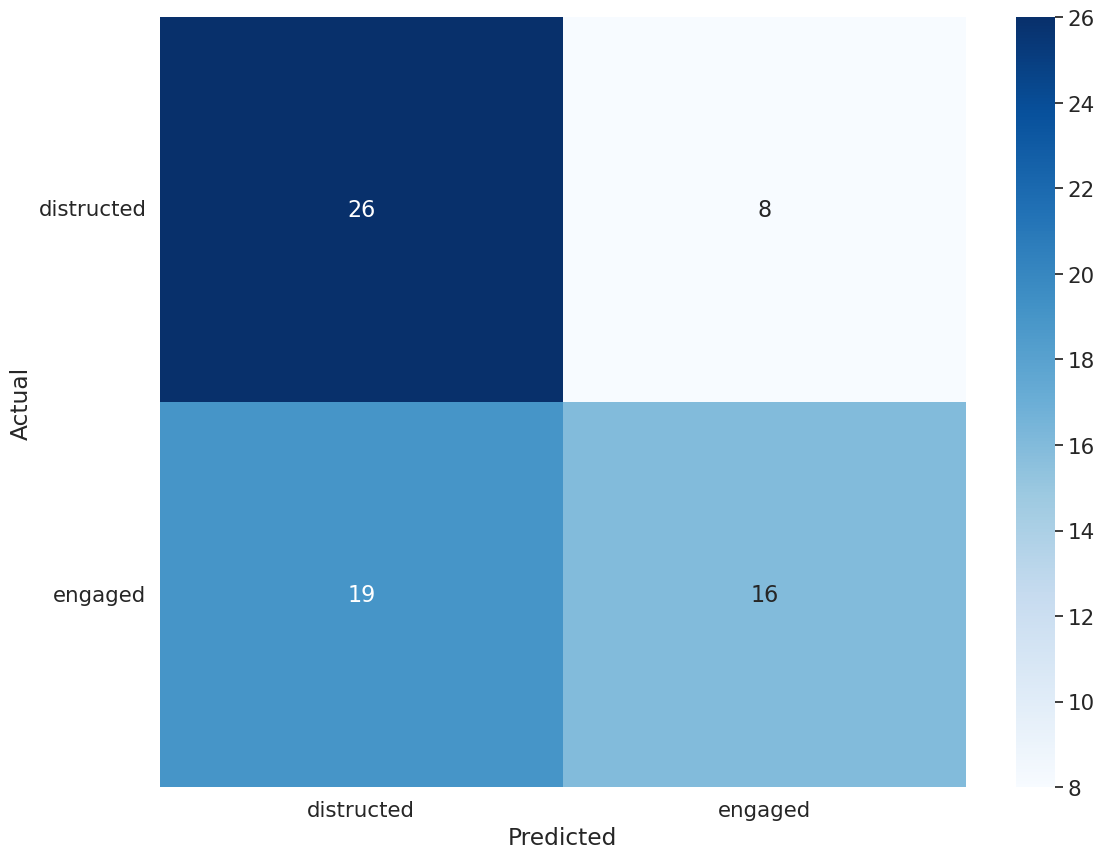

In [41]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [42]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana


2023-12-17 11:20:47.363010: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1500478670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 11:20:47.363056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-17 11:20:47.371559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-17 11:20:47.509345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-17 11:20:47.634474: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9714285714285715


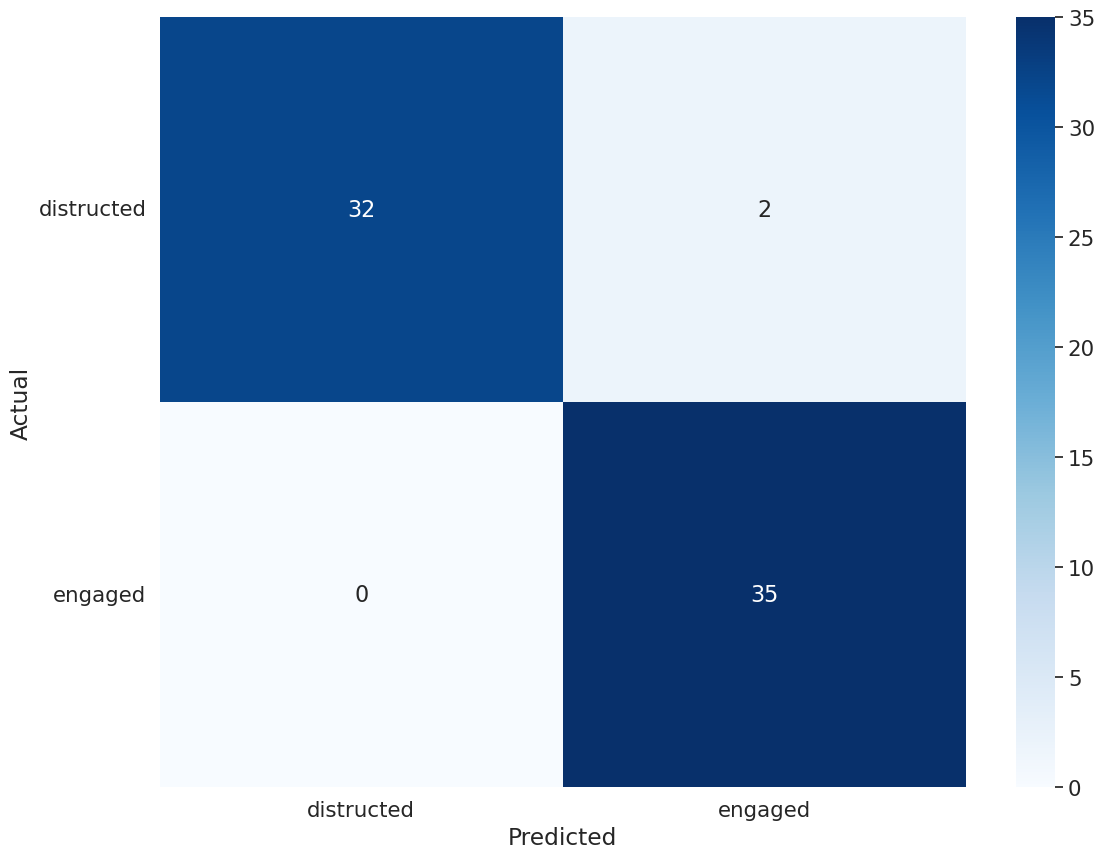

In [43]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [44]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.6428571428571429
		Actor Den
14 1.0
	Total acc:  0.7857142857142857
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.5714285714285714
		Actor Den
14 1.0
	Total acc:  0.8
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.9285714285714286
		Actor Den
14 1.0
	Total acc:  0.8538461538461538
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.9285714285714286
		Actor Den
14 1.0
	Total acc:  0.8835164835164836
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc: 

##### Self-attention

In [45]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [46]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [47]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [48]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [49]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6153846153846154
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.6428571428571429
Katya : 14
14 0.7857142857142857
Den : 14
14 0.6428571428571429
Total acc:  0.6659340659340659


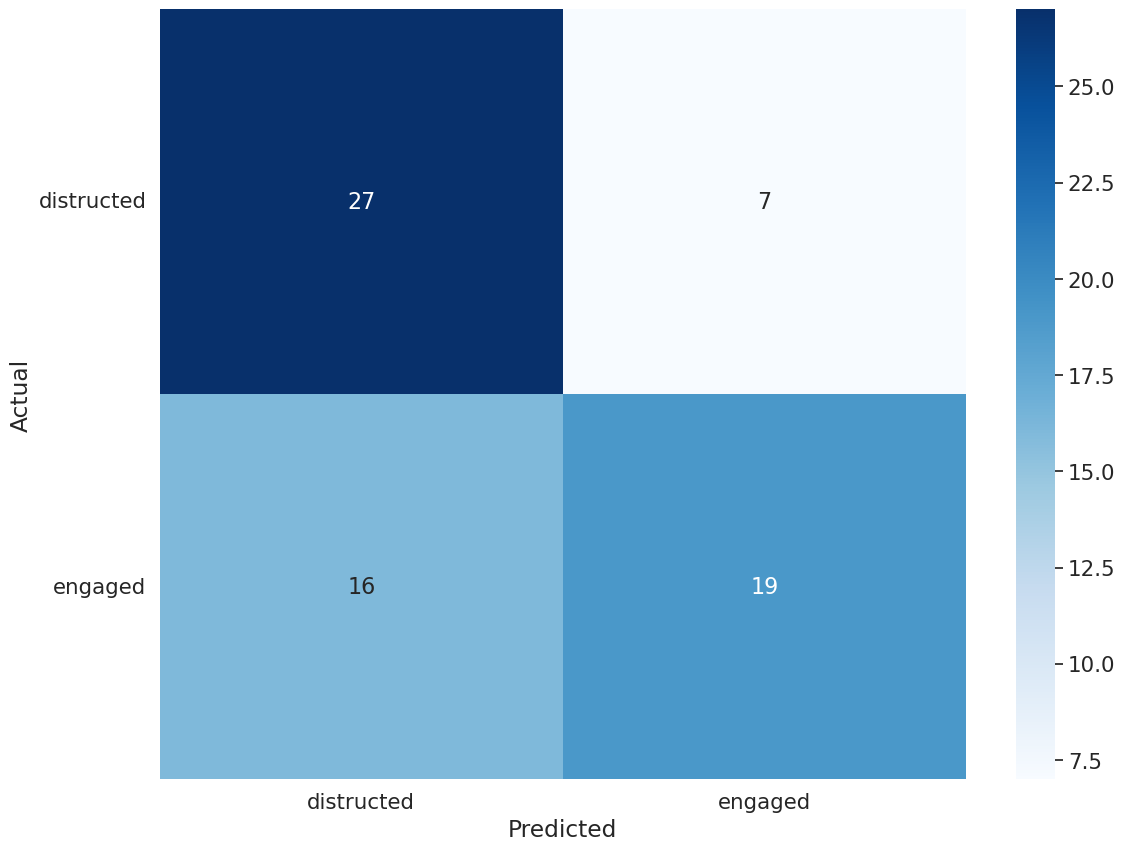

In [50]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [51]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.7857142857142857
Actor Egor
14 0.7857142857142857
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9


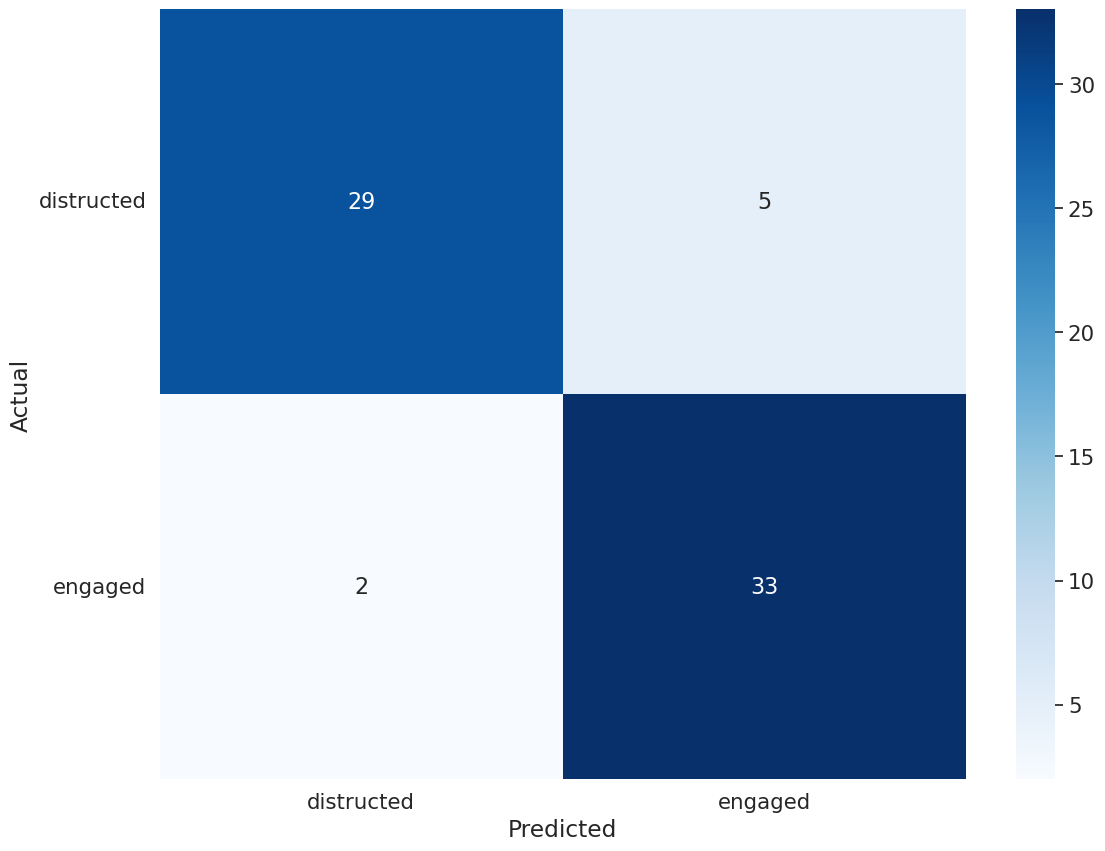

In [52]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [53]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.6428571428571429
		Actor Den
14 0.8571428571428571
	Total acc:  0.7285714285714285
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.6428571428571429
		Actor Den
14 0.9285714285714286
	Total acc:  0.7714285714285714
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.8549450549450549
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 1.0
		Actor Den
14 0.9285714285714286
	Total acc:  0.8263736263736264
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.928

#### Attention max

In [54]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [55]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [56]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [57]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [58]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [59]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [60]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.7857142857142857
Den : 14
14 0.6428571428571429
Total acc:  0.6967032967032967


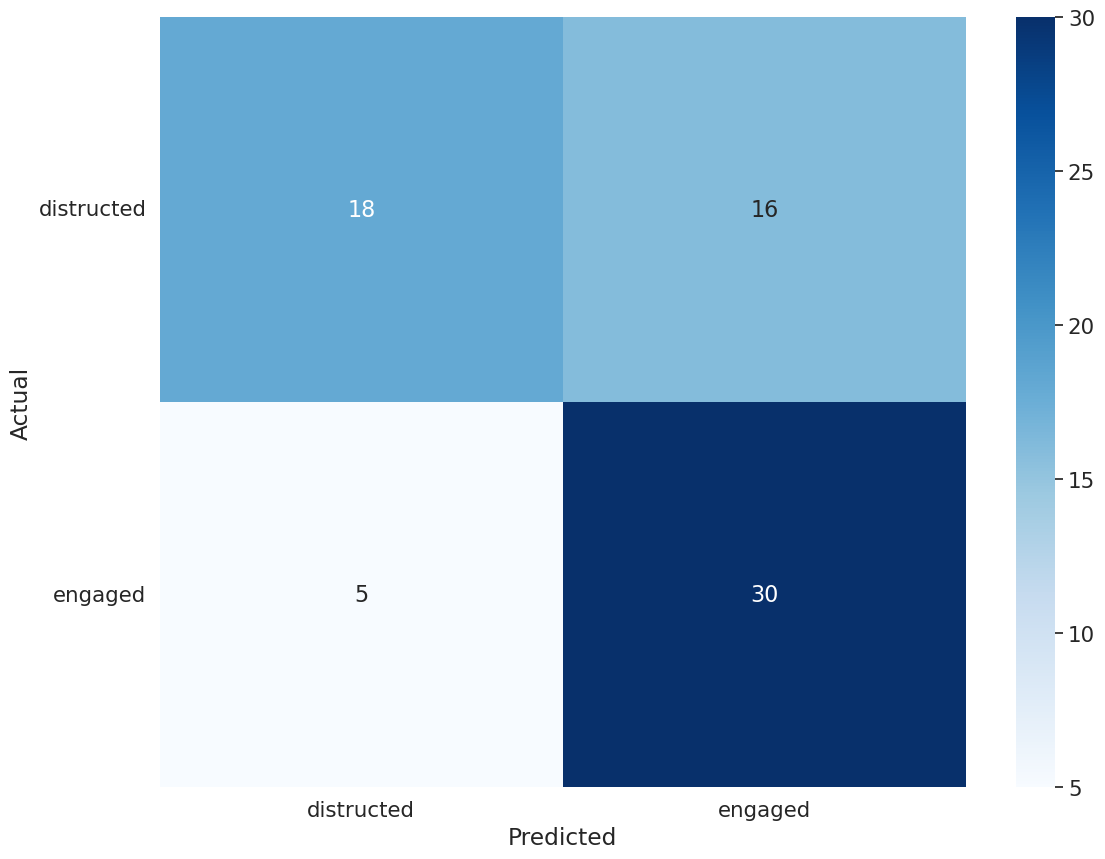

In [61]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [62]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.7857142857142857
Actor Egor
14 0.8571428571428571
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.8989010989010989


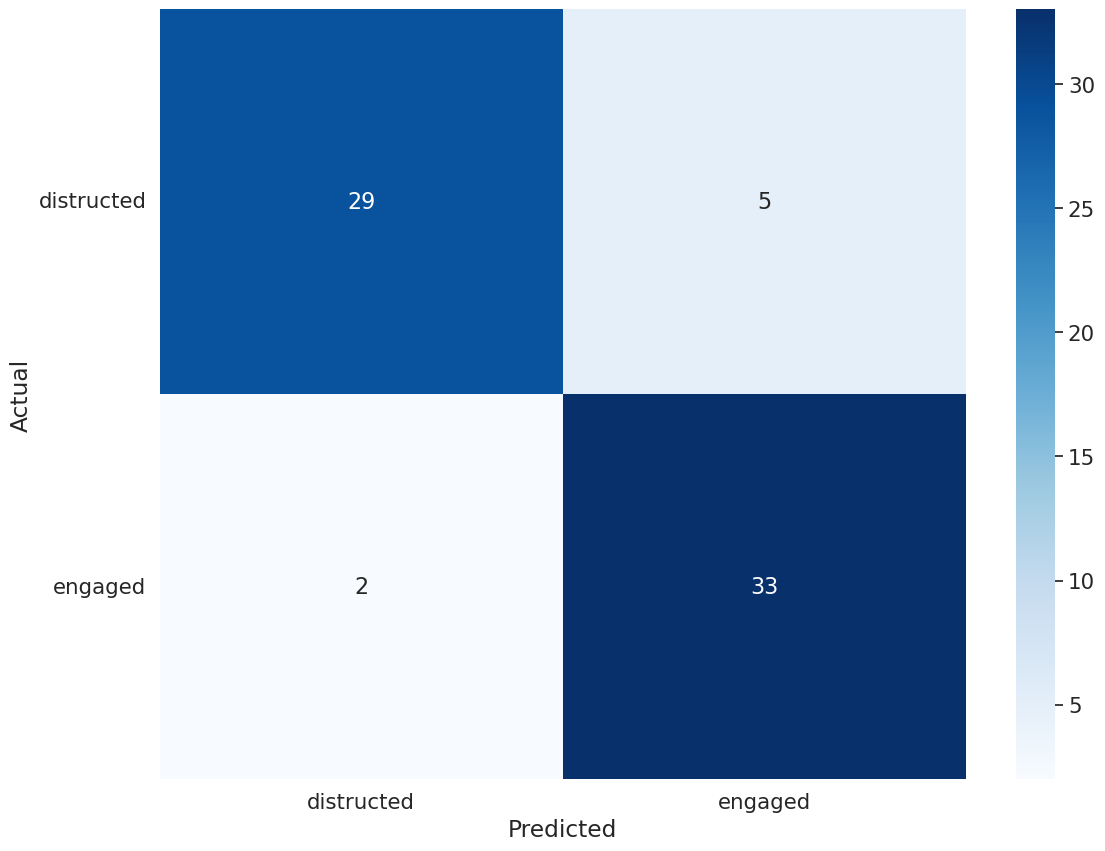

In [63]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [64]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.7714285714285714
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.8252747252747253
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7857142857142857
	Total acc:  0.7538461538461538
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7142857142857143
		Actor

##### Self-attention

In [65]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [66]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [67]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_1 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [68]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [69]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.7142857142857143
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.8571428571428571
Den : 14
14 0.7857142857142857
Total acc:  0.7527472527472527


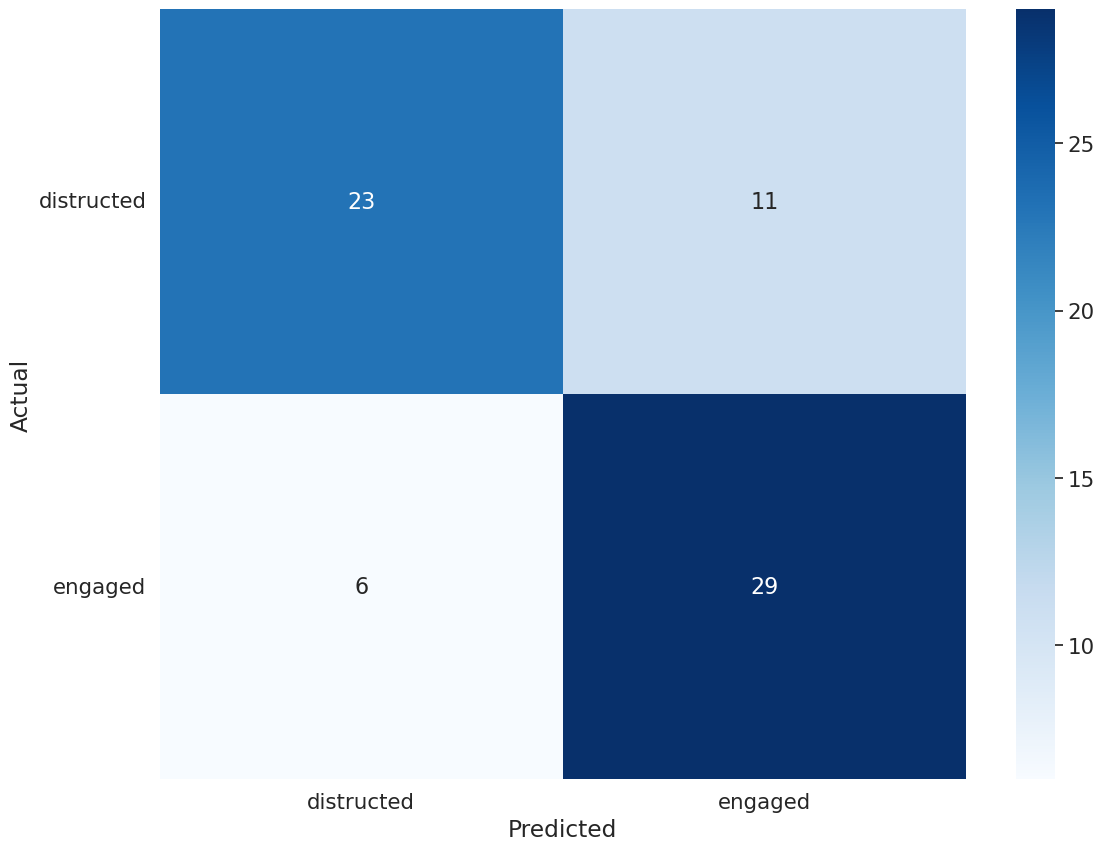

In [70]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [71]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.8571428571428571
Actor Egor
14 1.0
Actor Katya
14 0.9285714285714286
Actor Den
14 1.0
Total acc:  0.9571428571428571


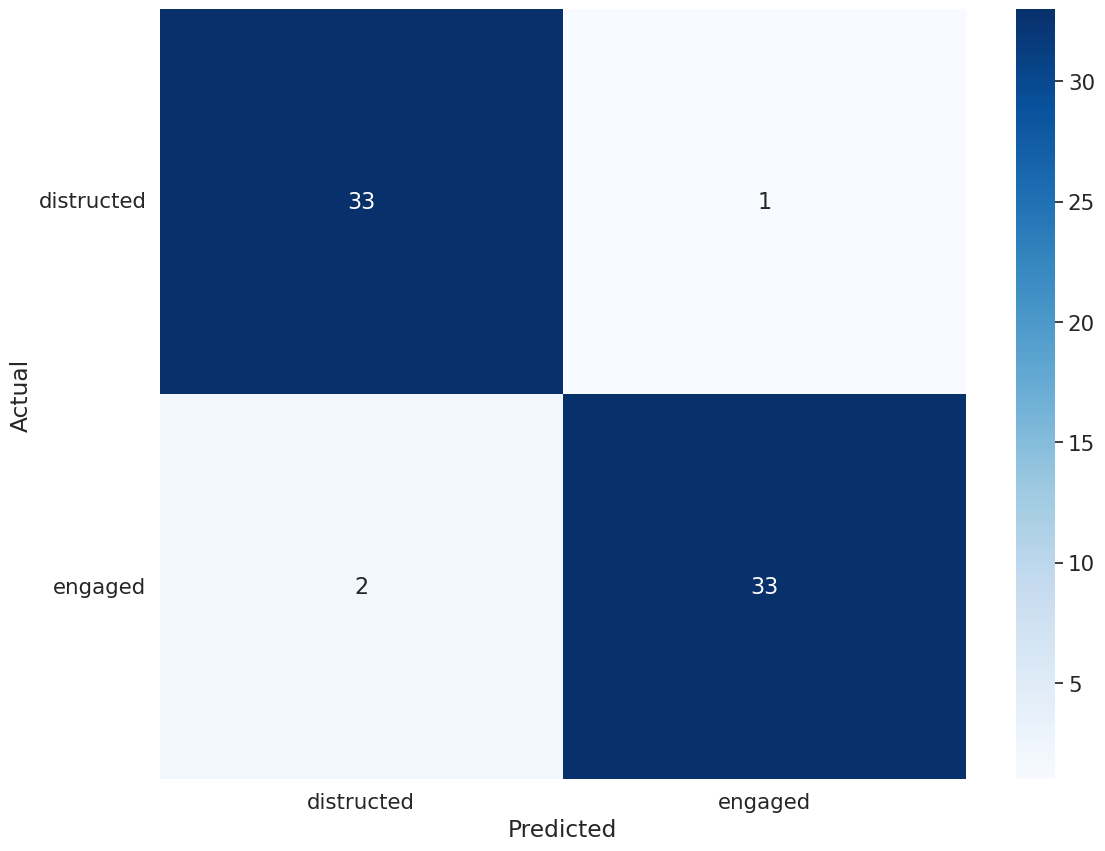

In [72]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [73]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.7857142857142858
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.5
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.7857142857142857
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.810989010989011
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.7549450549450549
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 1.0
	Total acc:  

### Features enet_b0_7

In [28]:
base_model_key = 'enet_b0_7.pt'
FEATURE_VECTOR_DIM = 2560

In [75]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [29]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [30]:
print(len(eng_vid2features))

80


#### Attention std

In [78]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [79]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [80]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [81]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [82]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [83]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [84]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.46153846153846156
Kate : 14
14 0.5
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.7857142857142857
Den : 14
14 0.2857142857142857
Total acc:  0.5494505494505495


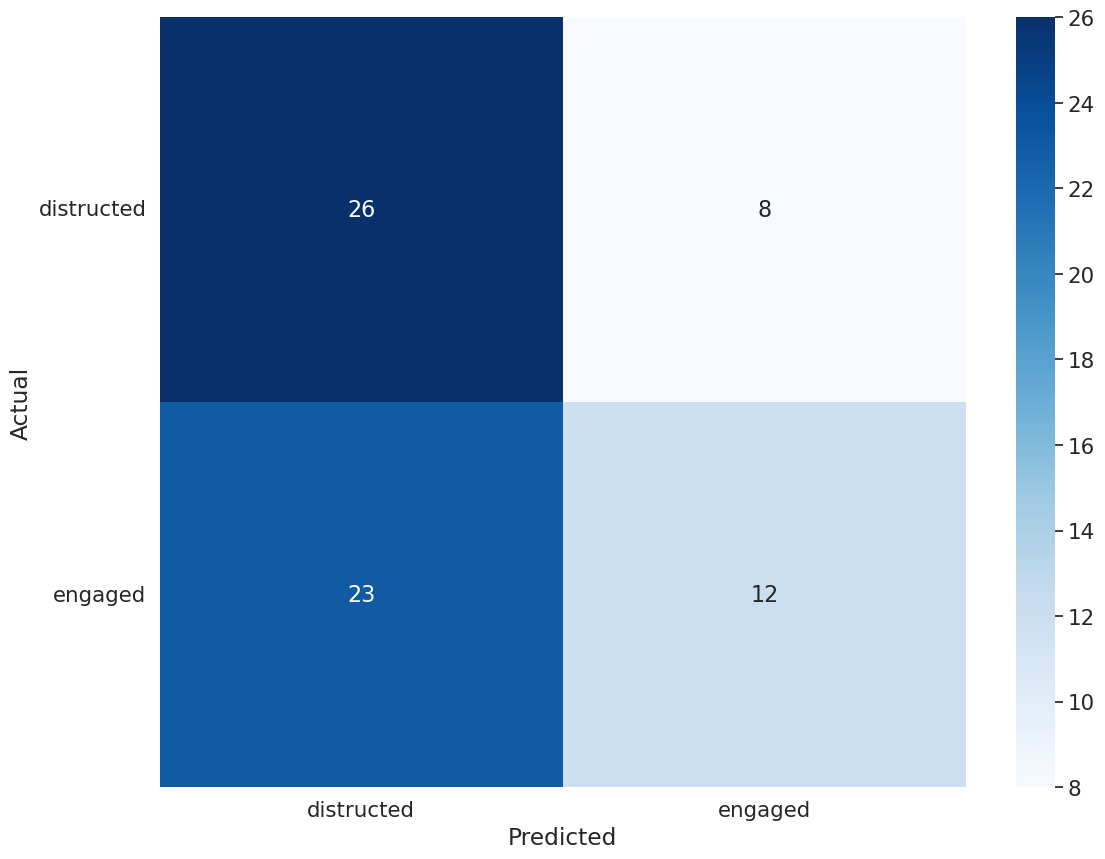

In [85]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [86]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.956043956043956


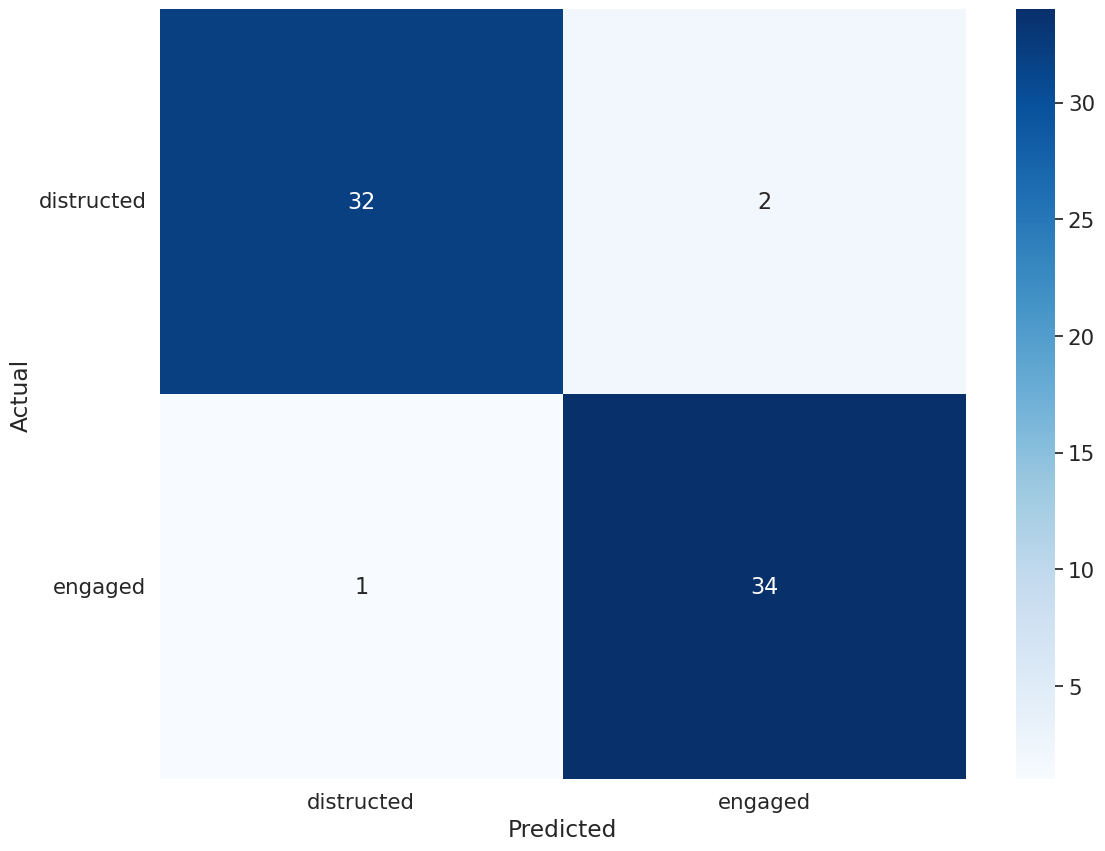

In [87]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [88]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.9285714285714286
	Total acc:  0.8
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7142857142857143
		Actor Den
14 1.0
	Total acc:  0.8285714285714285
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 1.0
		Actor Den
14 1.0
	Total acc:  0.8538461538461538
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 1.0
	Total acc:  0.8978021978021978
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 1.0
	Total acc:  0.9263736263736263
Videos num

##### Self-attention

In [89]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [90]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [91]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_2 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [92]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [93]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.9230769230769231
Kate : 14
14 0.7857142857142857
Egor : 14
14 0.6428571428571429
Katya : 14
14 0.8571428571428571
Den : 14
14 0.5714285714285714
Total acc:  0.756043956043956


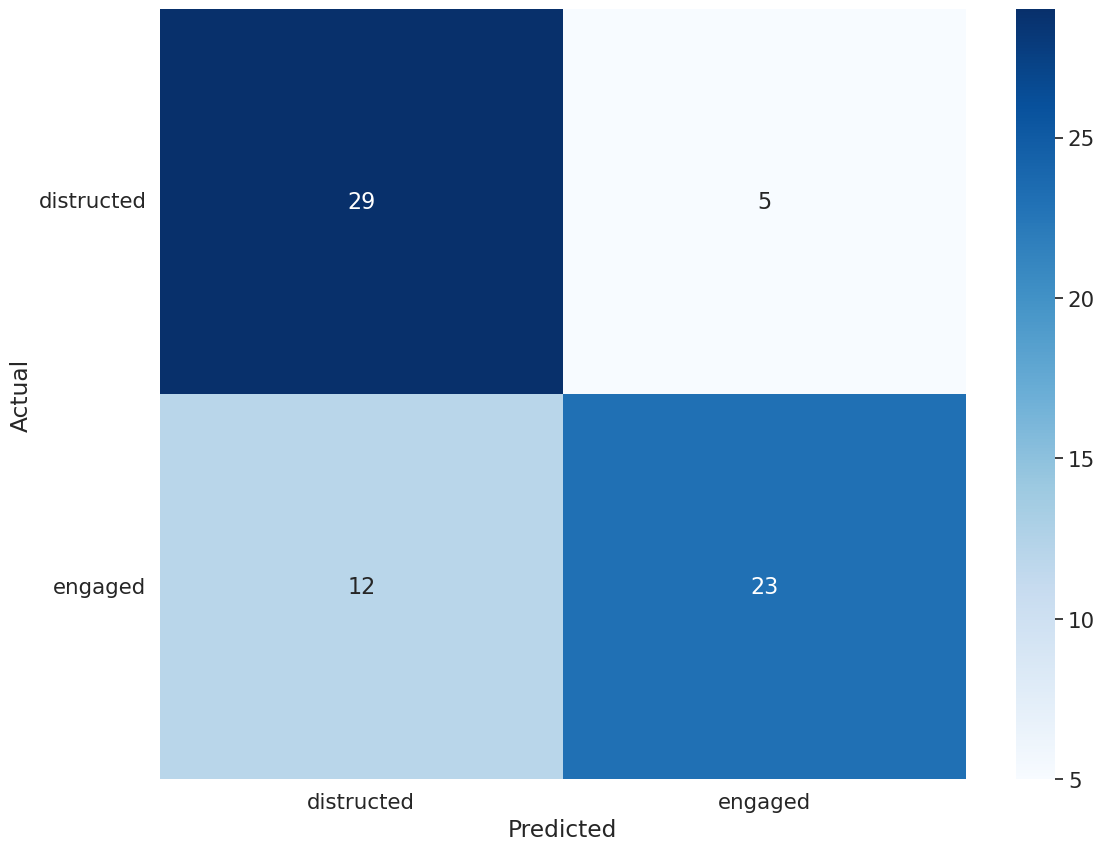

In [94]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [95]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9714285714285715


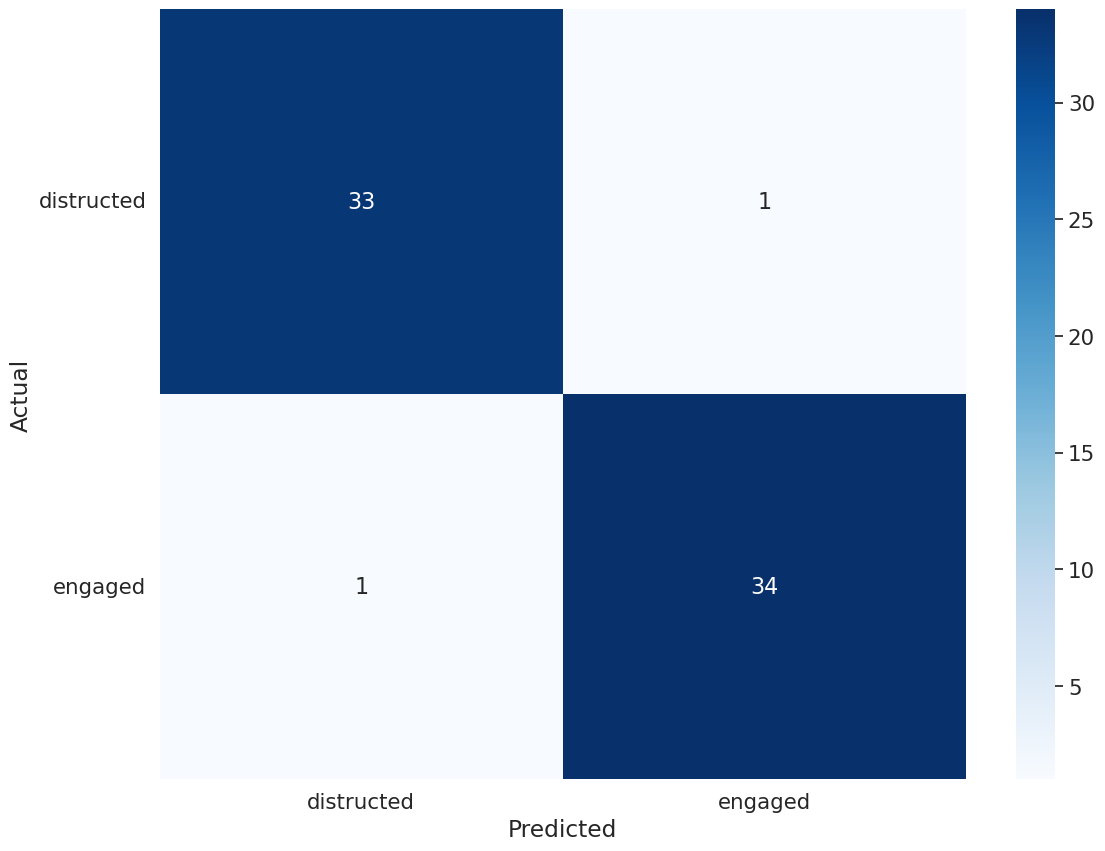

In [96]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [97]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.7857142857142857
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.9285714285714286
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.6923076923076923
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 1.0
		Actor Den
14 0.9285714285714286
	Total acc:  0.8241758241758242
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.7857142857142857
	Total acc:  0.8681318681318683
Videos num:  5
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor

#### Attention max

In [33]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [34]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [100]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [35]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

2024-01-10 21:16:13.763452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [36]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

In [37]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [40]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14


2024-01-10 21:17:12.519251: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


13 0.7692307692307693
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.7857142857142857
Den : 14
14 0.5714285714285714
Total acc:  0.6824175824175824


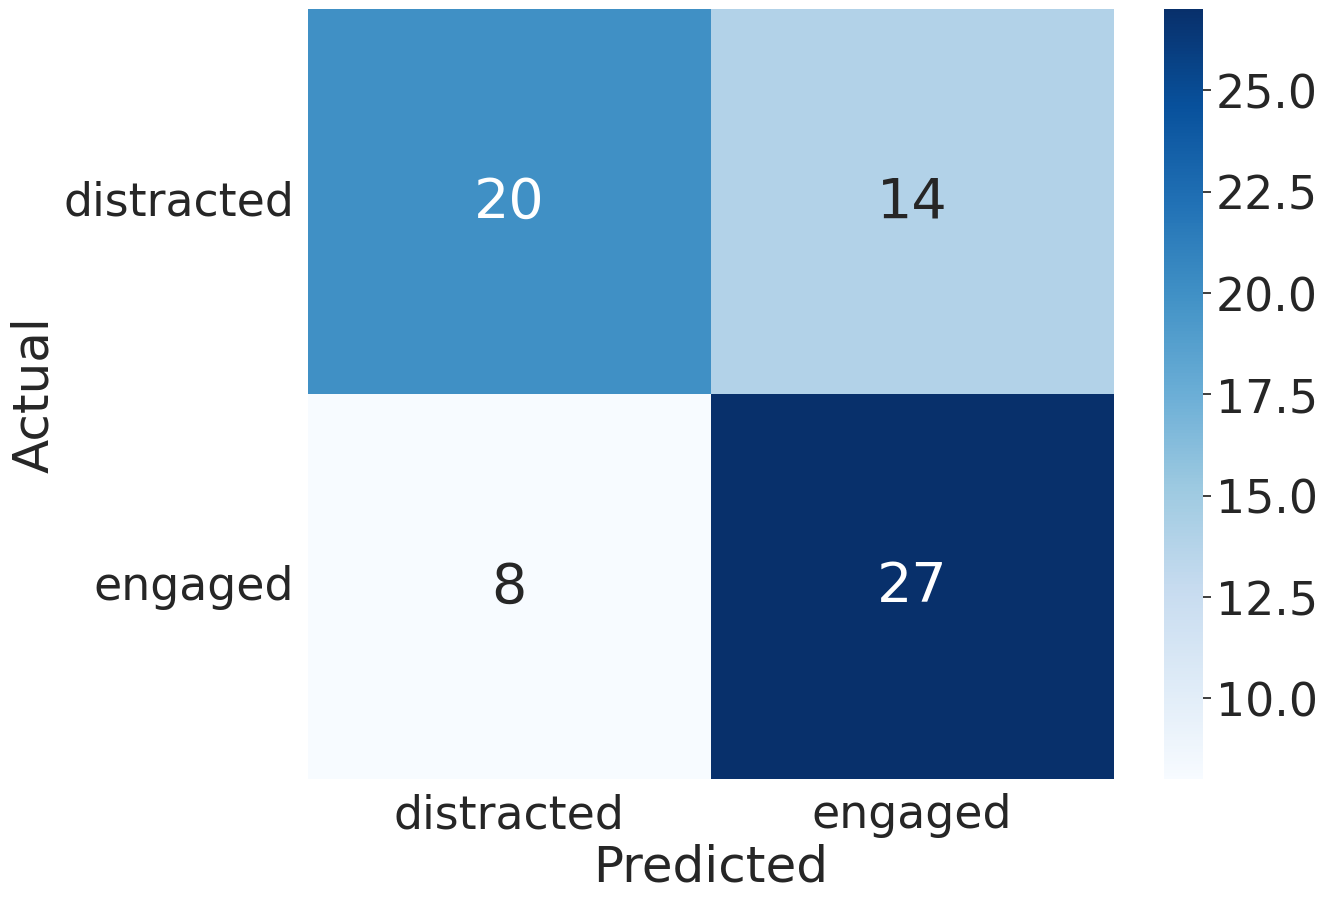

In [49]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [106]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 1.0
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9857142857142858


In [50]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    print("Actor {}".format(actor))
    weights_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    load_weights(modelAtn, weights_name)
    model_weights = modelAtn.get_weights()
    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

Actor Yana
13 1.0
Actor Kate
14 1.0
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9857142857142858


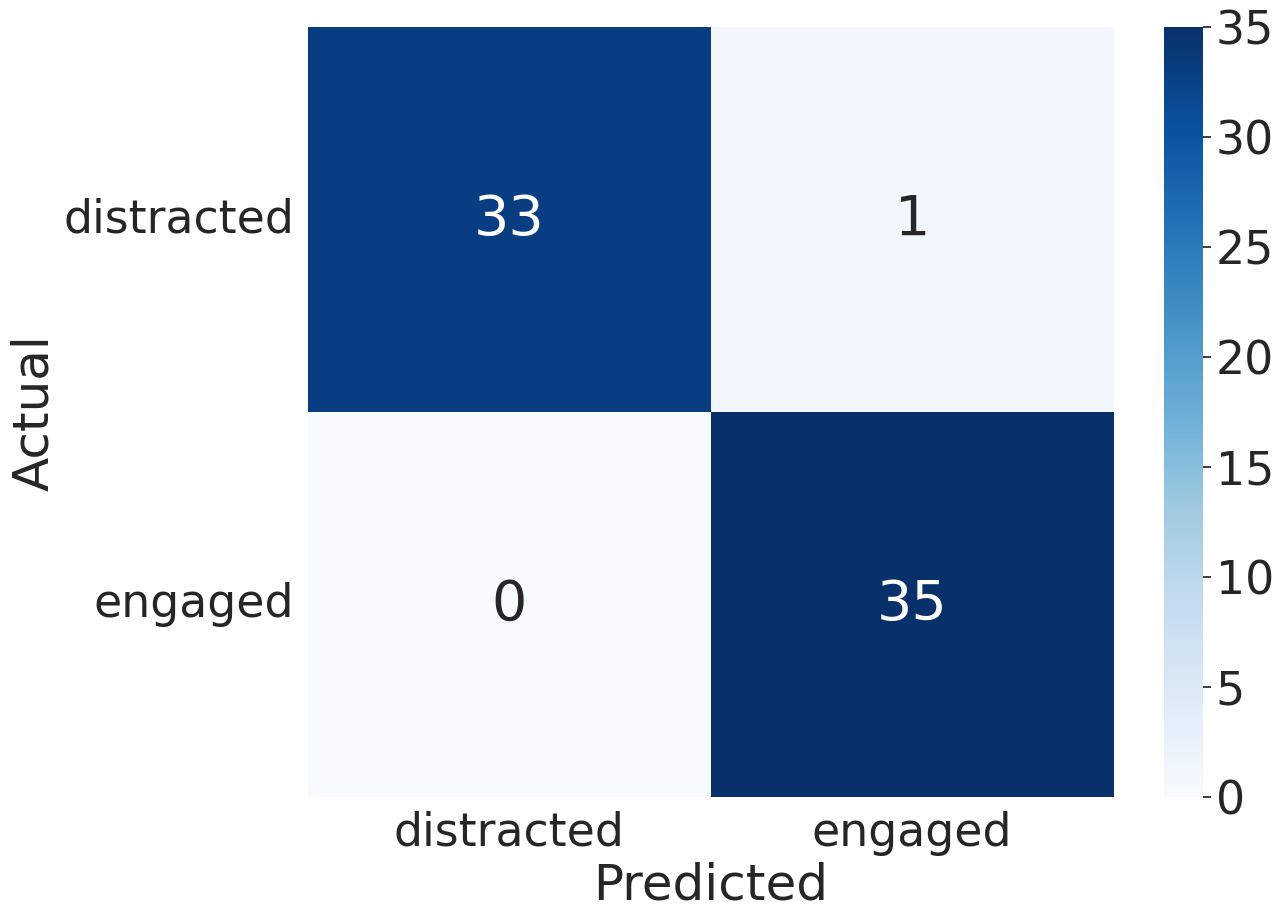

In [51]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [108]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.7714285714285714
Videos num:  2
		Actor Yana
14 0.9285714285714286
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.8714285714285713
Videos num:  3
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8989010989010989
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8978021978021978
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 1.0
		Actor Den
14 1

##### Self-attention

In [109]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [110]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [111]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_3 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [112]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [113]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.7142857142857143
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.7142857142857143
Den : 14
14 0.6428571428571429
Total acc:  0.6956043956043956


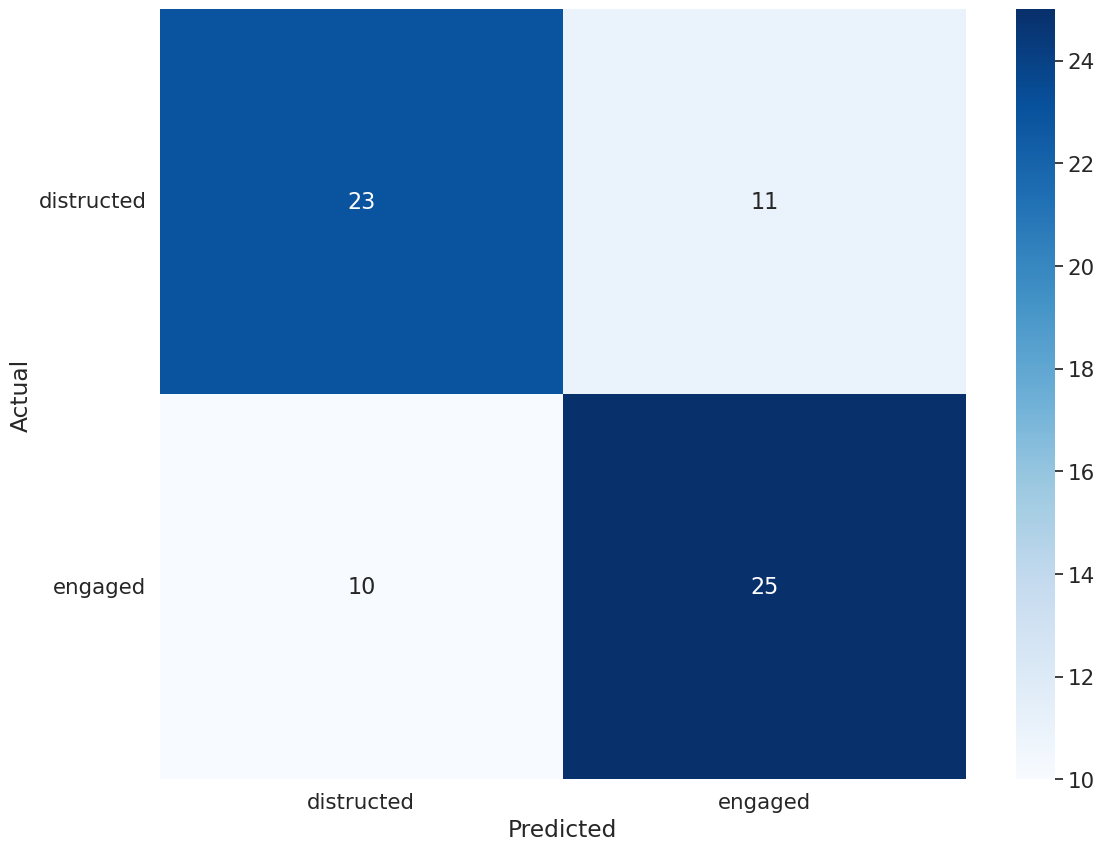

In [114]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [115]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 0.9285714285714286
Actor Den
14 0.9285714285714286
Total acc:  0.9417582417582417


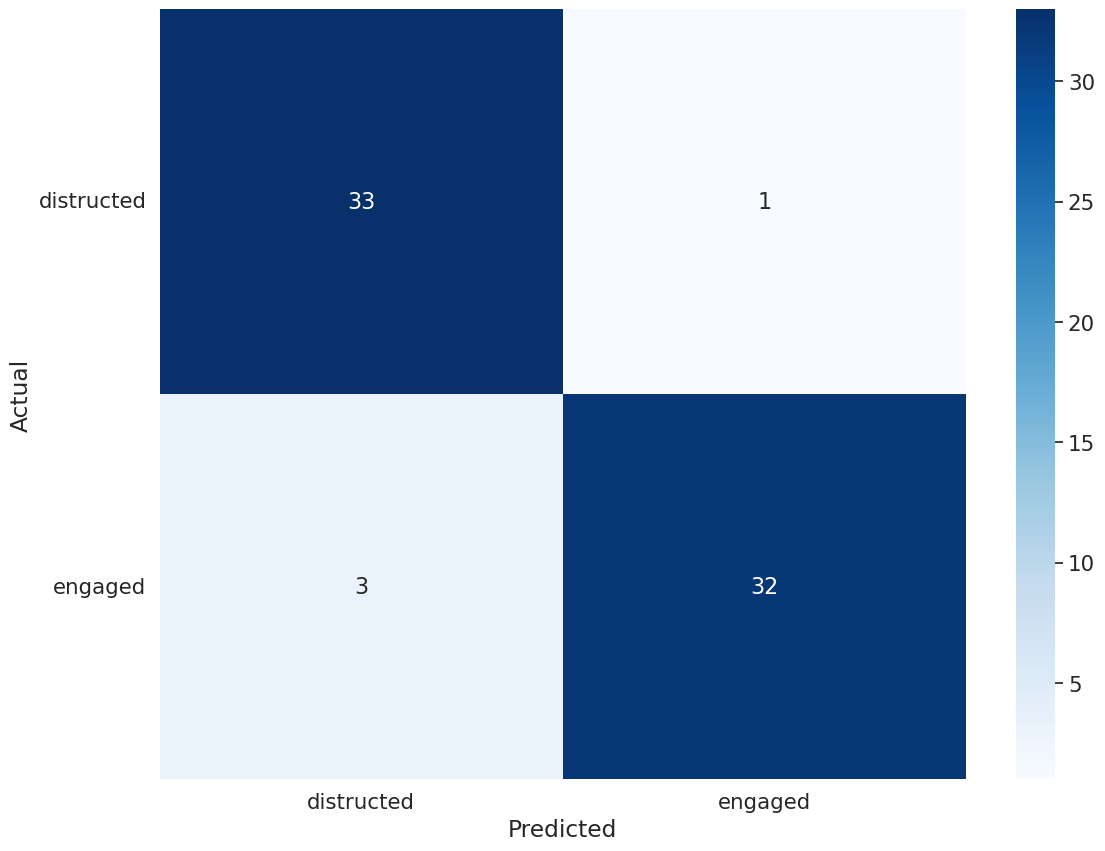

In [116]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [117]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.5
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.7714285714285715
Videos num:  2
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.5
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.9285714285714286
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8692307692307694
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8406593406593407
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 0.9285714285714286
	Total acc:  0.912087912087

### Features enet_b0_8_best_afew

In [118]:
base_model_key = 'enet_b0_8_best_afew.pt'
FEATURE_VECTOR_DIM = 2560

In [119]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [120]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [121]:
print(len(eng_vid2features))

80


#### Attention std

In [122]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [123]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [124]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [125]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [126]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [127]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [128]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.46153846153846156
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7857142857142857
Katya : 14
14 0.5714285714285714
Den : 14
14 0.7857142857142857
Total acc:  0.635164835164835


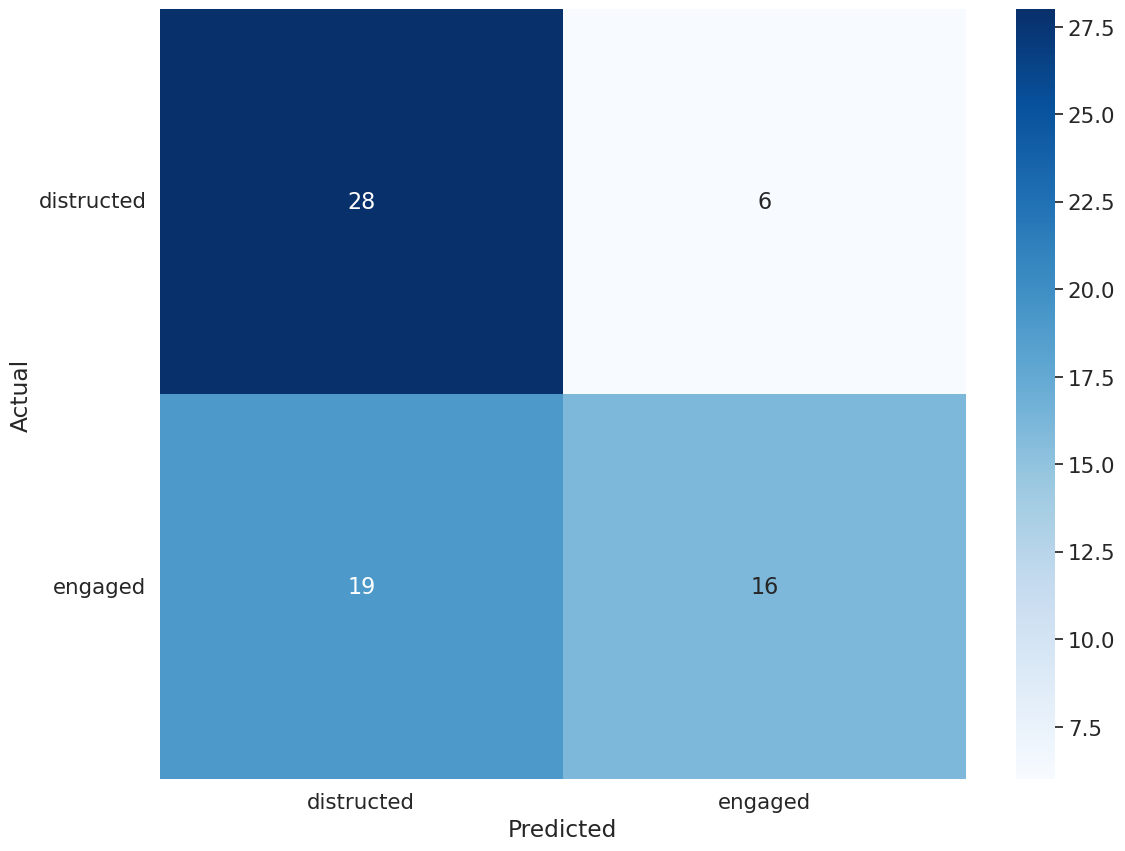

In [129]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [130]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.7692307692307693
Actor Kate
14 0.8571428571428571
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.910989010989011


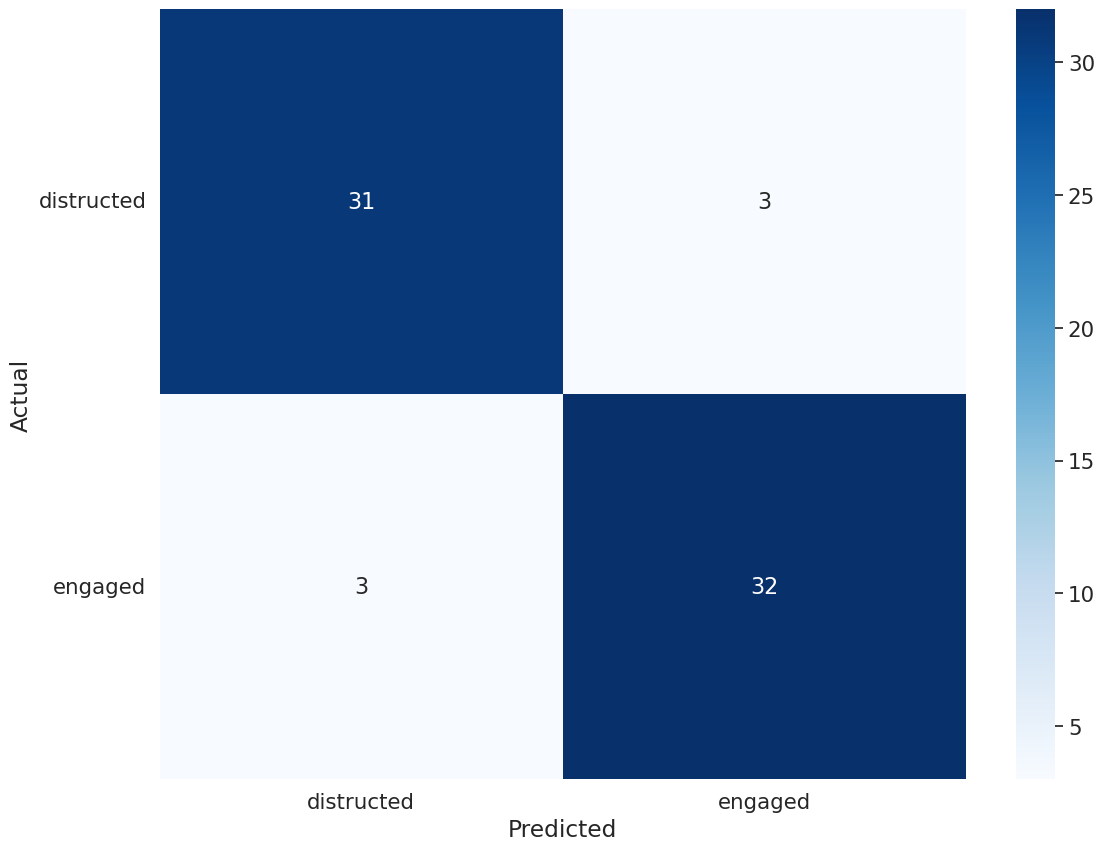

In [131]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [132]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5
		Actor Katya
14 0.6428571428571429
		Actor Den
14 0.6428571428571429
	Total acc:  0.6571428571428571
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.5714285714285714
		Actor Den
14 0.8571428571428571
	Total acc:  0.7142857142857143
Videos num:  3
		Actor Yana
13 0.6923076923076923
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.7813186813186814
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.7967032967032968
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.928

##### Self-attention

In [133]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [134]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [135]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_4 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

In [136]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [137]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.5714285714285714
Katya : 14
14 0.5
Den : 14
14 0.5714285714285714
Total acc:  0.6109890109890109


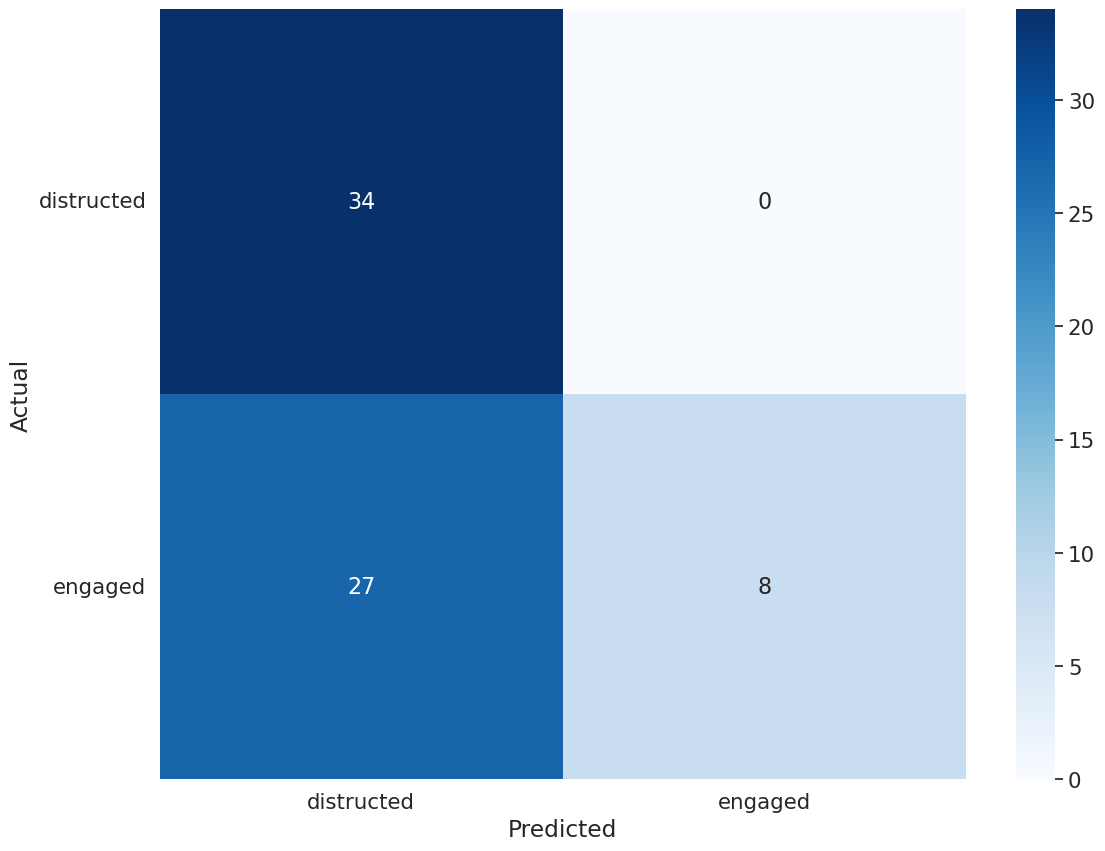

In [138]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [139]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.7692307692307693
Actor Kate
14 0.7857142857142857
Actor Egor
14 0.9285714285714286
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.8824175824175825


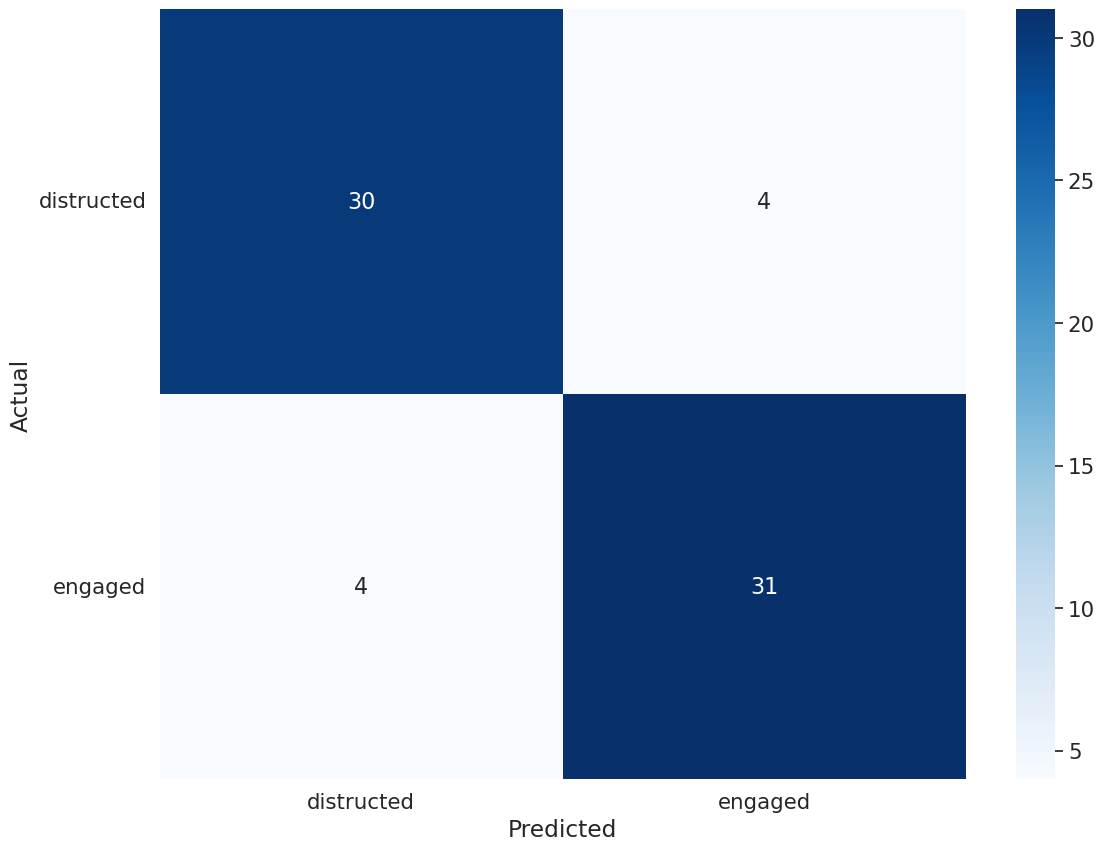

In [140]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [141]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5
		Actor Katya
14 0.5714285714285714
		Actor Den
14 0.7857142857142857
	Total acc:  0.6571428571428571
Videos num:  2
		Actor Yana
14 0.5714285714285714
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.5
		Actor Katya
14 0.5
		Actor Den
14 1.0
	Total acc:  0.6857142857142857
Videos num:  3
		Actor Yana
13 0.6923076923076923
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.7384615384615385
Videos num:  4
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.8703296703296705
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1

#### Attention max

In [142]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [143]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [144]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [145]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [146]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [147]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [148]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.8571428571428571
Katya : 14
14 0.7142857142857143
Den : 14
14 0.5714285714285714
Total acc:  0.6956043956043956


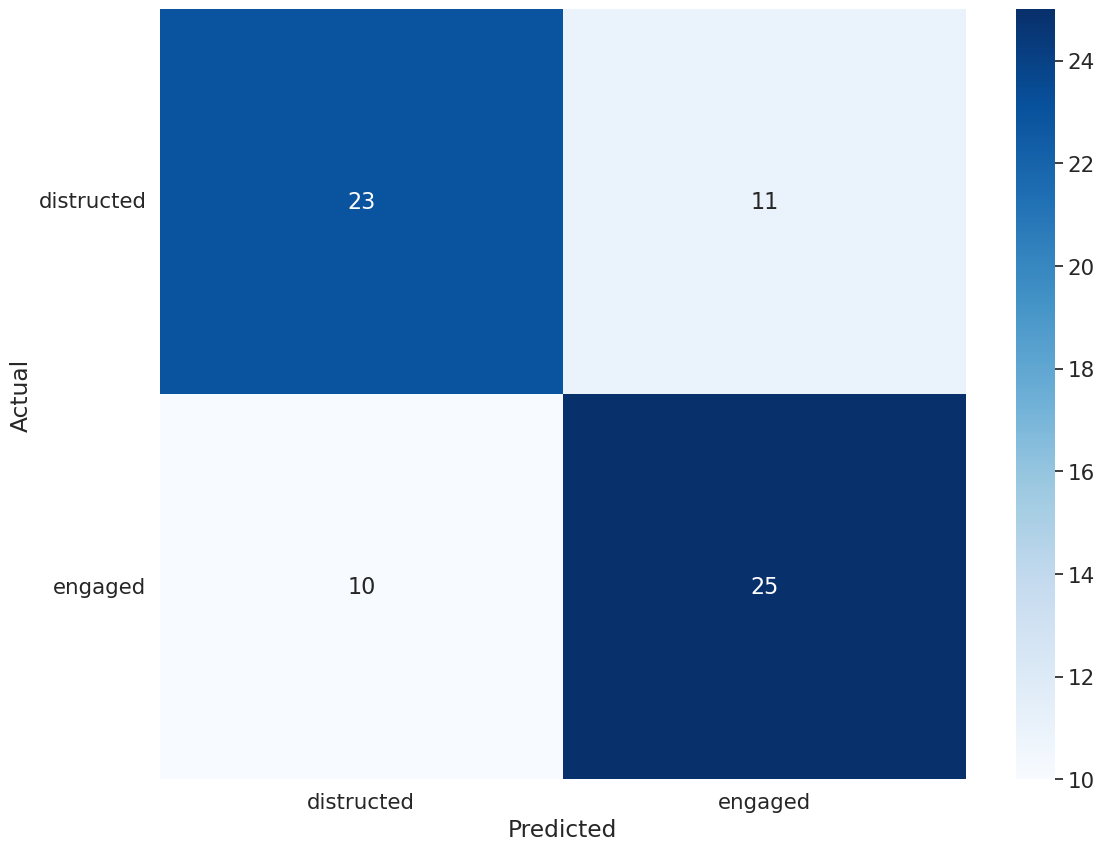

In [149]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [150]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.8461538461538461
Actor Kate
14 0.7857142857142857
Actor Egor
14 0.9285714285714286
Actor Katya
14 0.8571428571428571
Actor Den
14 0.9285714285714286
Total acc:  0.8692307692307691


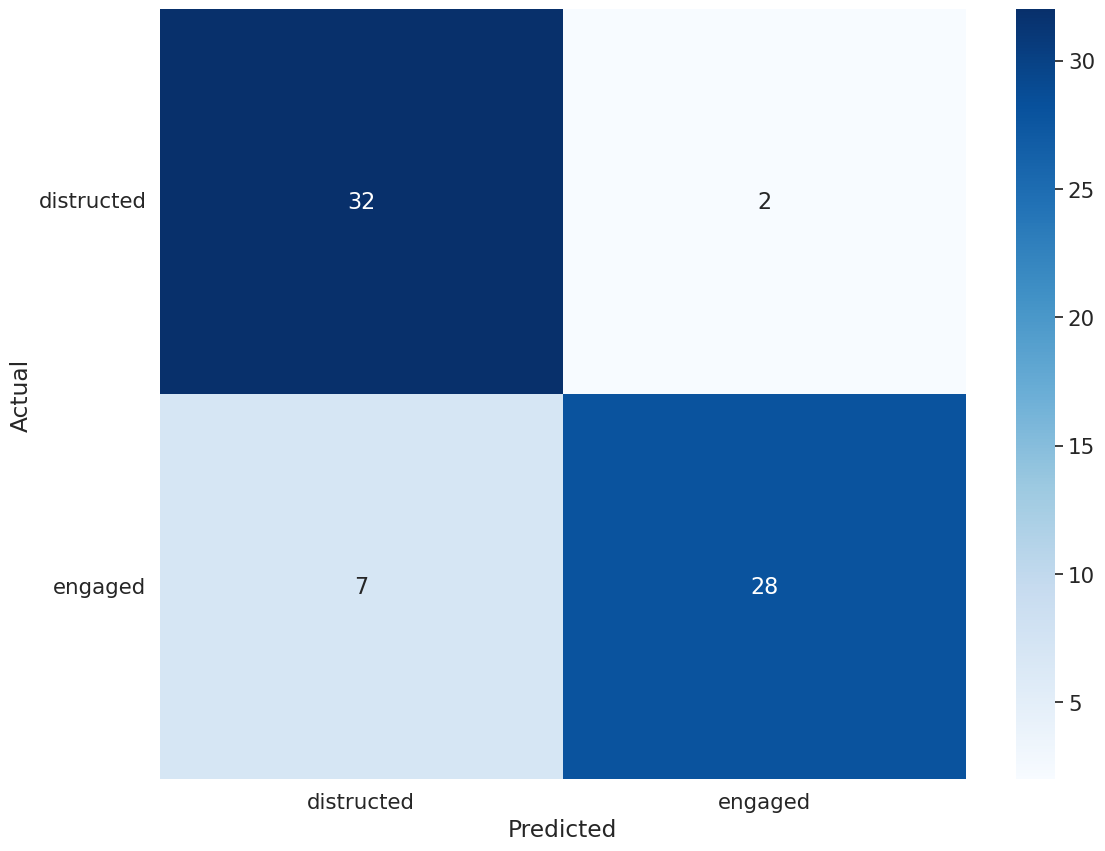

In [151]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [152]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.5
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.6428571428571429
	Total acc:  0.6285714285714286
Videos num:  2
		Actor Yana
14 0.5714285714285714
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.9285714285714286
	Total acc:  0.7142857142857142
Videos num:  3
		Actor Yana
13 0.6153846153846154
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.7516483516483516
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.7967032967032968
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 1.0
	

##### Self-attention

In [153]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [154]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [155]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_5 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [156]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [157]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.42857142857142855
Egor : 14
14 0.9285714285714286
Katya : 14
14 0.6428571428571429
Den : 14
14 0.7857142857142857
Total acc:  0.6956043956043956


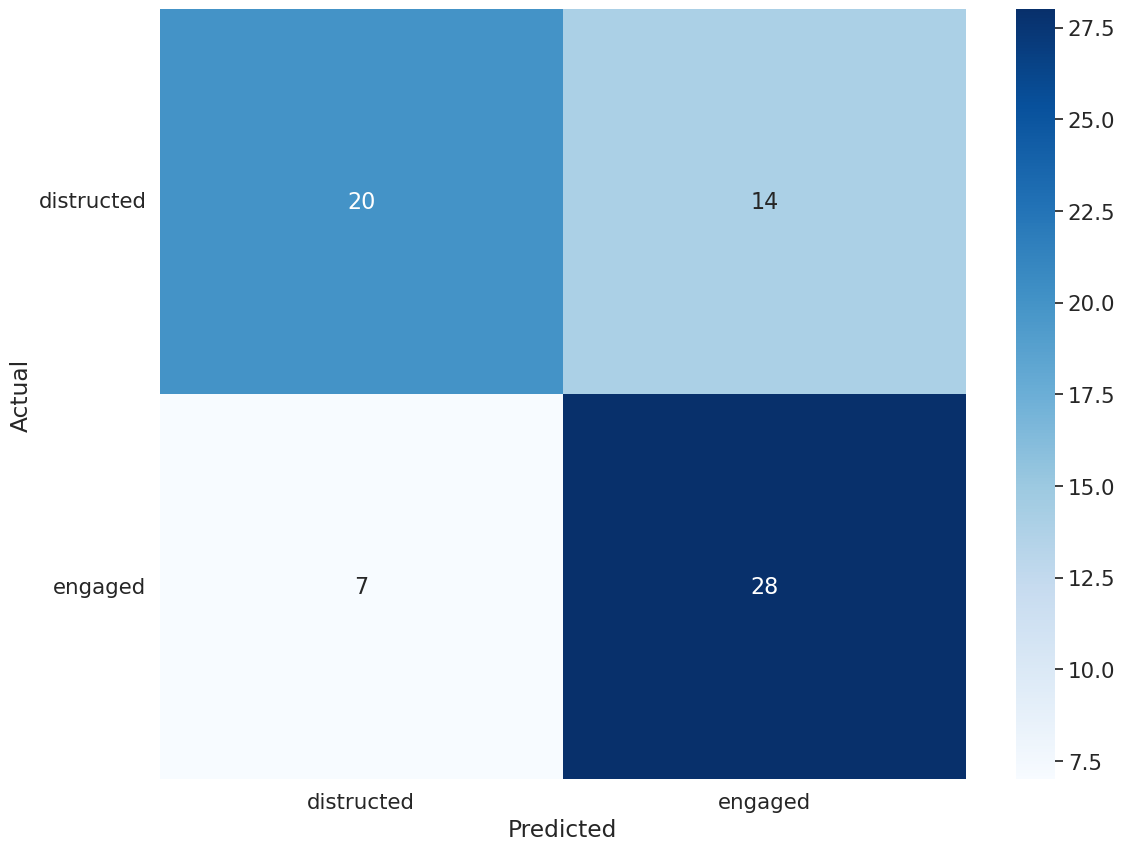

In [158]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [159]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.8461538461538461
Actor Kate
14 0.8571428571428571
Actor Egor
14 0.7857142857142857
Actor Katya
14 0.8571428571428571
Actor Den
14 1.0
Total acc:  0.8692307692307694


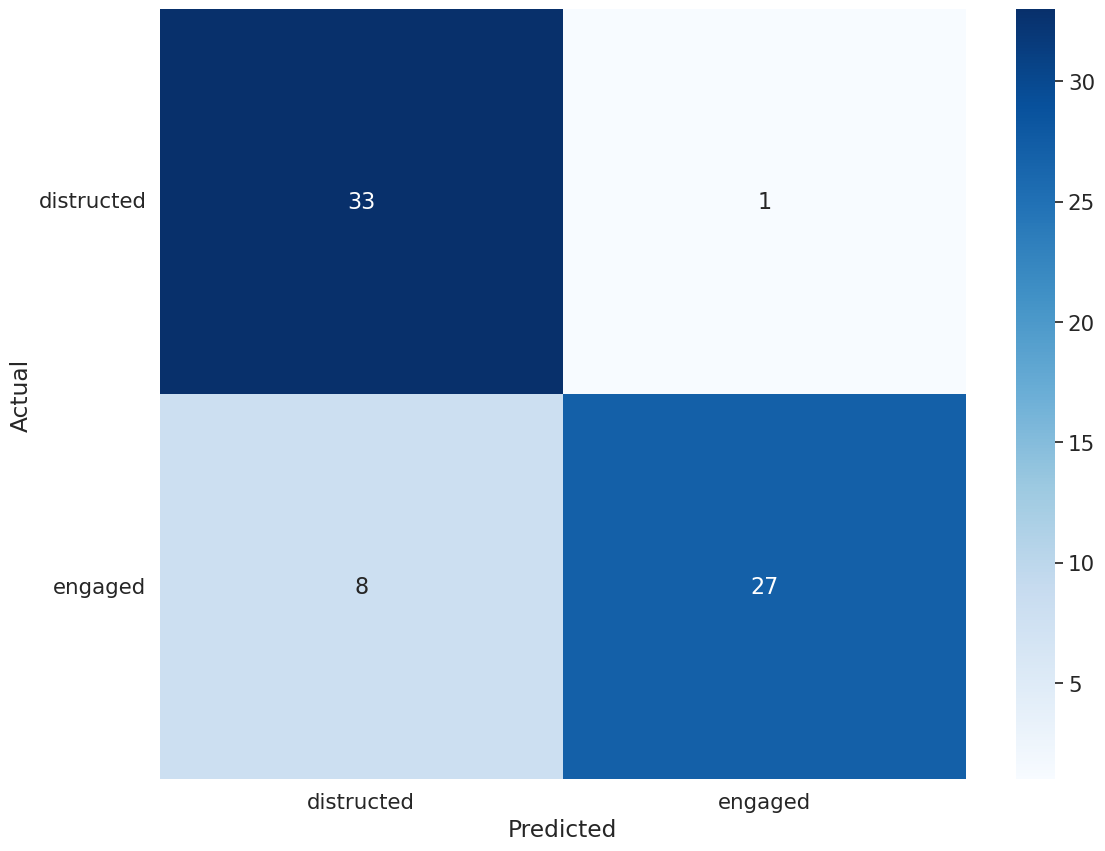

In [160]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [161]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.42857142857142855
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7142857142857143
	Total acc:  0.6857142857142857
Videos num:  2
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.5
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.7571428571428571
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.7835164835164836
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7142857142857143
		Actor Den
14 1.0
	Total acc:  0.7692307692307693
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.5714285714285714
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.92

### Features enet_b2_7

In [162]:
base_model_key = 'enet_b2_7.pt'
FEATURE_VECTOR_DIM = 2816

In [163]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [164]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [165]:
print(len(eng_vid2features))

80


#### Attention std

In [166]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [167]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [168]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [169]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [170]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [171]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [172]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6153846153846154
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.8571428571428571
Den : 14
14 0.42857142857142855
Total acc:  0.6373626373626373


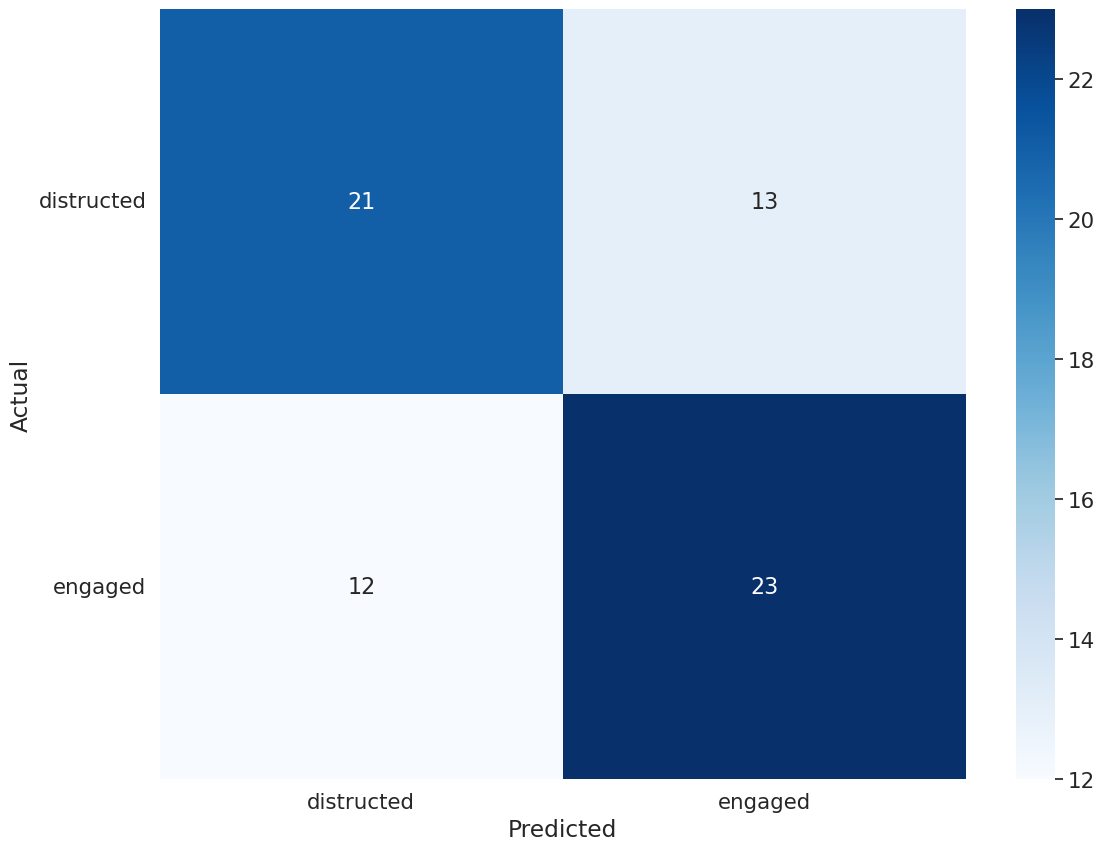

In [173]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [174]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.9285714285714286
Actor Katya
14 0.8571428571428571
Actor Den
14 0.9285714285714286
Total acc:  0.9131868131868132


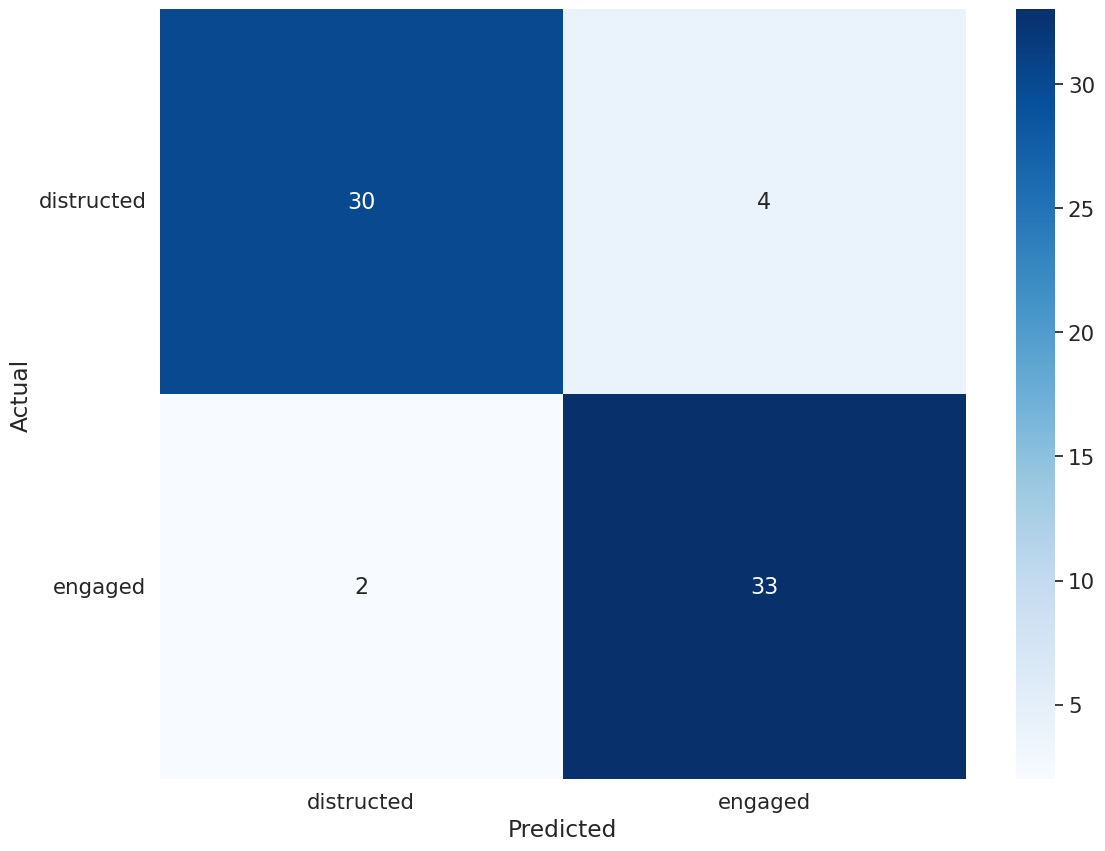

In [175]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [176]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.5714285714285714
		Actor Den
14 0.8571428571428571
	Total acc:  0.6857142857142857
Videos num:  2
		Actor Yana
14 0.5714285714285714
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.5
		Actor Den
14 0.8571428571428571
	Total acc:  0.7428571428571429
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 0.8571428571428571
	Total acc:  0.8538461538461538
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 0.9285714285714286
	Total acc:  0.8978021978021978
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.9285714285714286
	

##### Self-attention

In [177]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [178]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [179]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention_6 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [180]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [181]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.7142857142857143
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.8571428571428571
Den : 14
14 0.5714285714285714
Total acc:  0.7252747252747254


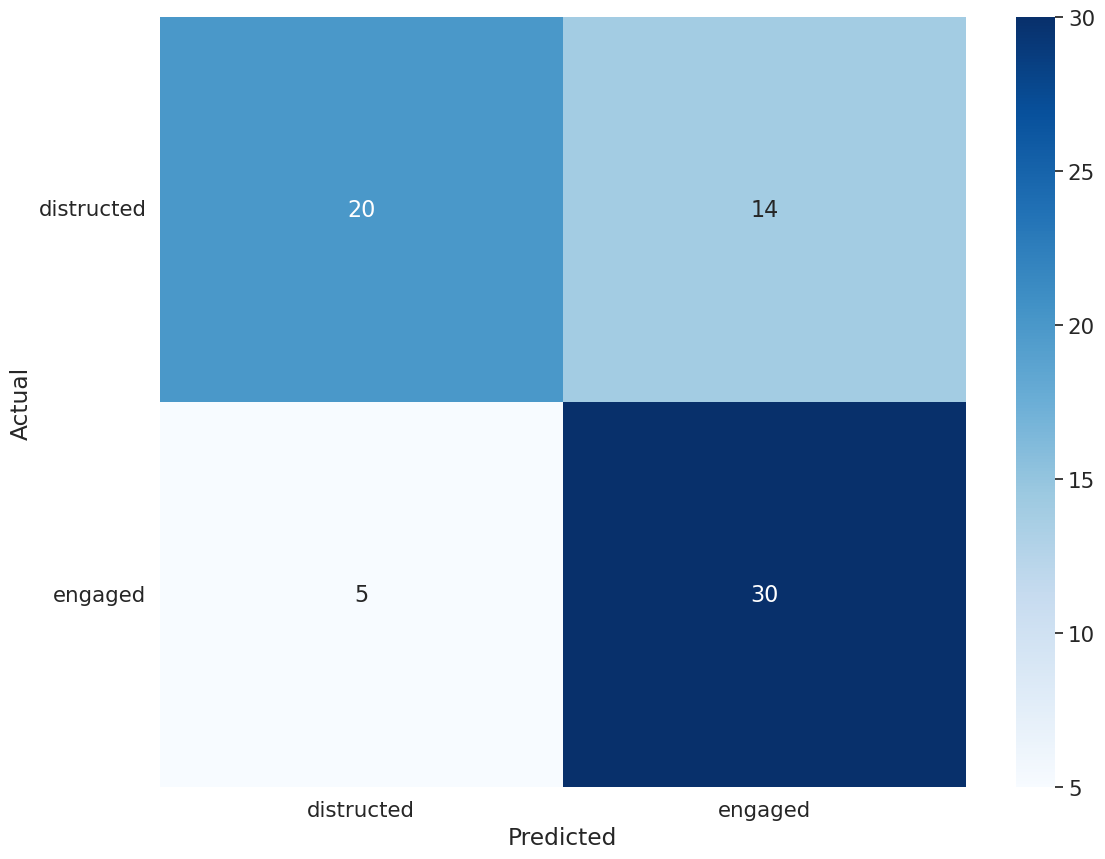

In [182]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [183]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.8571428571428571
Actor Egor
14 1.0
Actor Katya
14 0.8571428571428571
Actor Den
14 0.9285714285714286
Total acc:  0.9131868131868132


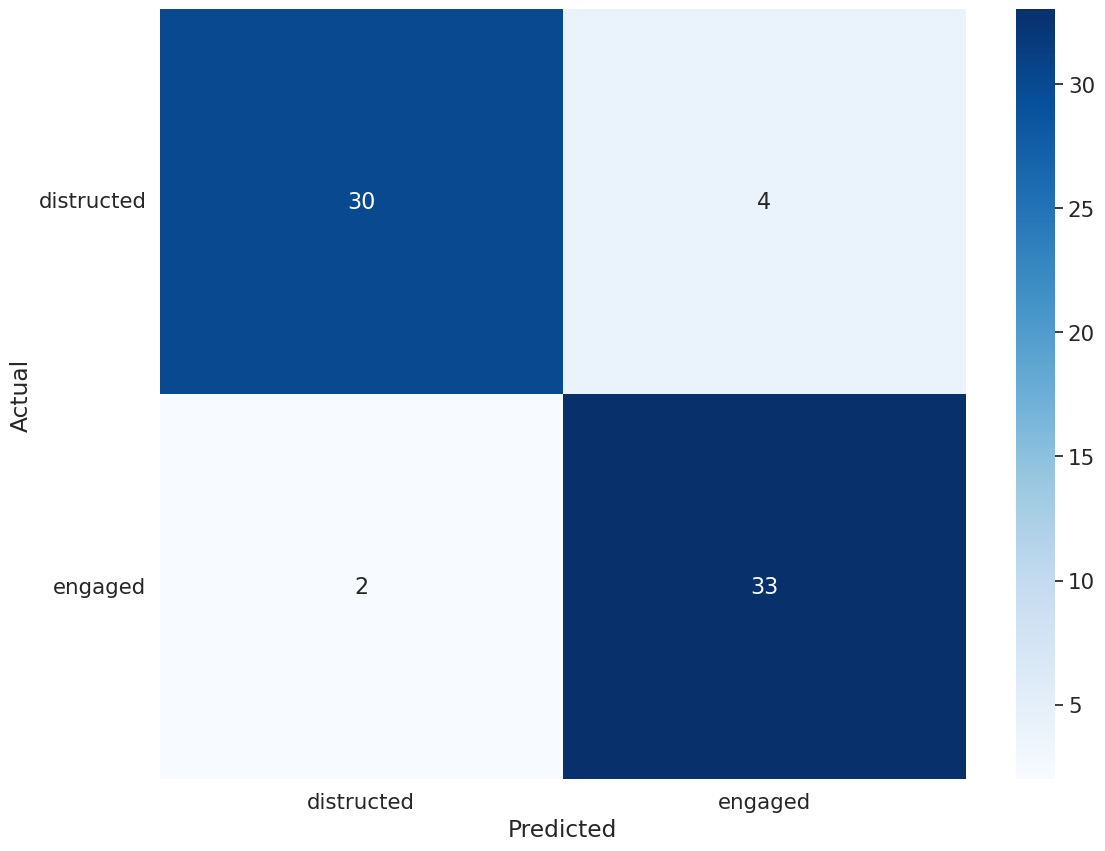

In [184]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [185]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.5714285714285714
		Actor Den
14 0.5714285714285714
	Total acc:  0.6714285714285714
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.5
		Actor Den
14 0.8571428571428571
	Total acc:  0.7285714285714285
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.8263736263736263
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.7681318681318681
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 0.928

#### Attention max

In [186]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [187]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [188]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [189]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [190]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [191]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [192]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.7142857142857143
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.6428571428571429
Den : 14
14 0.5714285714285714
Total acc:  0.667032967032967


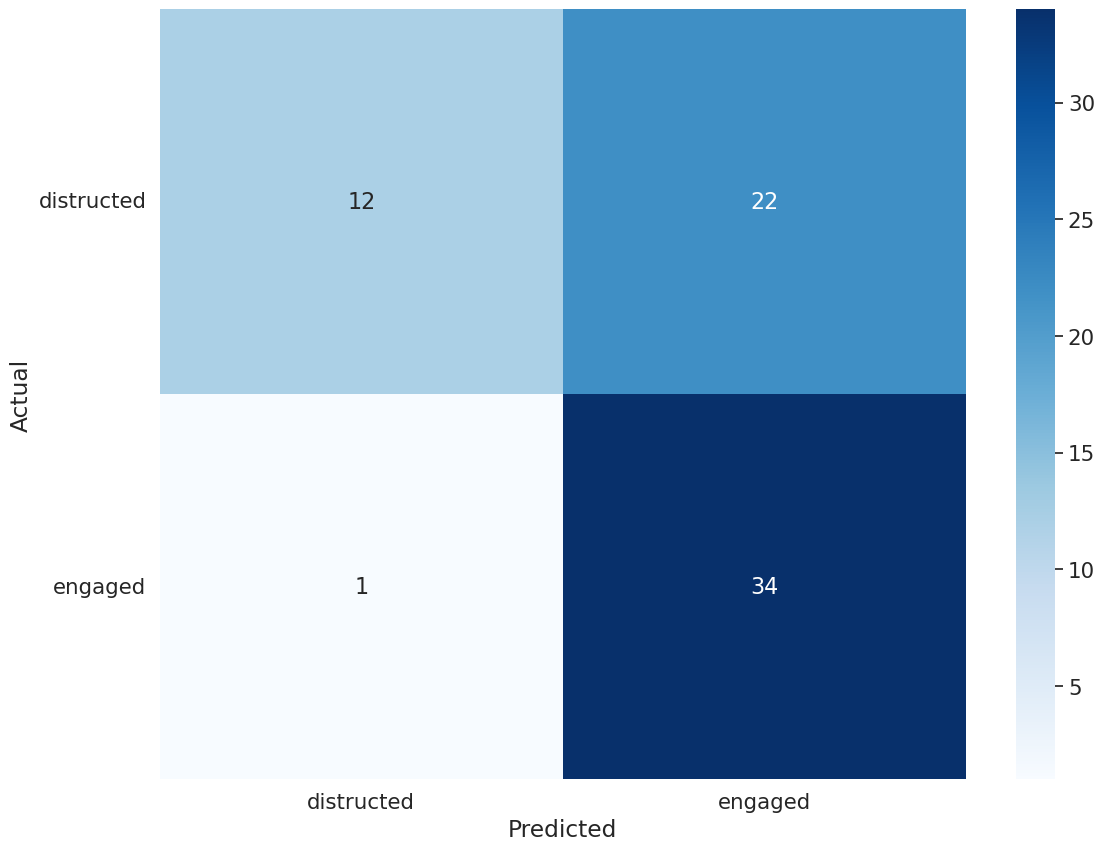

In [193]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [194]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 0.8571428571428571
Actor Den
14 0.9285714285714286
Total acc:  0.9274725274725275


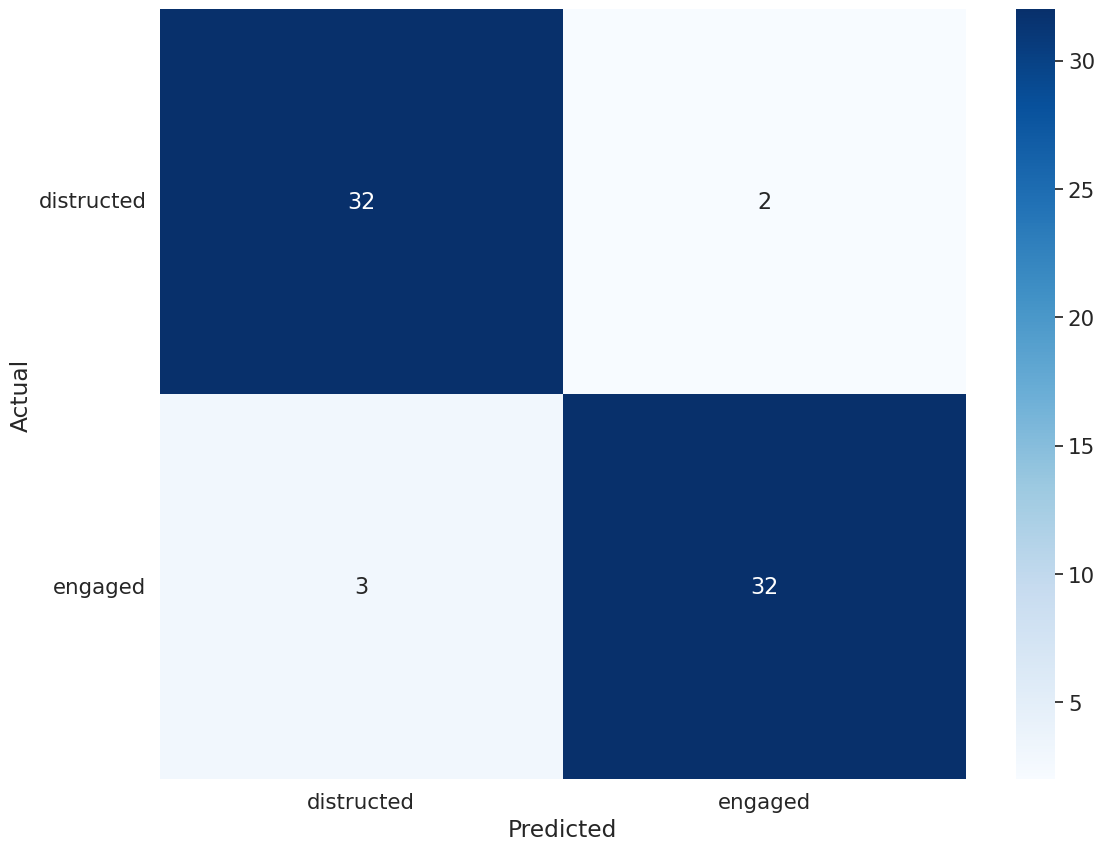

In [195]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [196]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.8571428571428571
	Total acc:  0.7571428571428572
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.8
Videos num:  3
		Actor Yana
13 0.6923076923076923
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7857142857142857
	Total acc:  0.7813186813186812
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.8692307692307691
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 1.0
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0

##### Self-attention

In [197]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [198]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [199]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention_7 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [200]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [201]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.6428571428571429
Den : 14
14 0.5714285714285714
Total acc:  0.6538461538461539


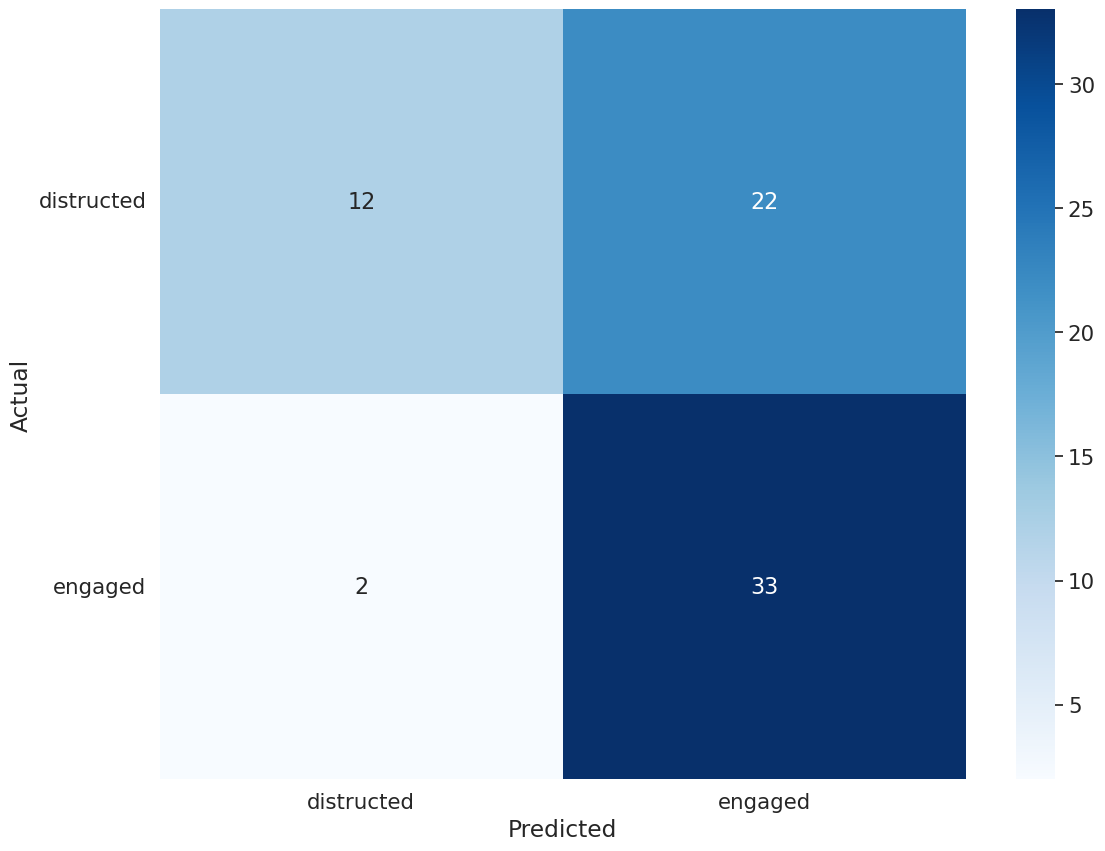

In [202]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [203]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.7857142857142857
Actor Katya
14 0.7142857142857143
Actor Den
14 1.0
Total acc:  0.8857142857142858


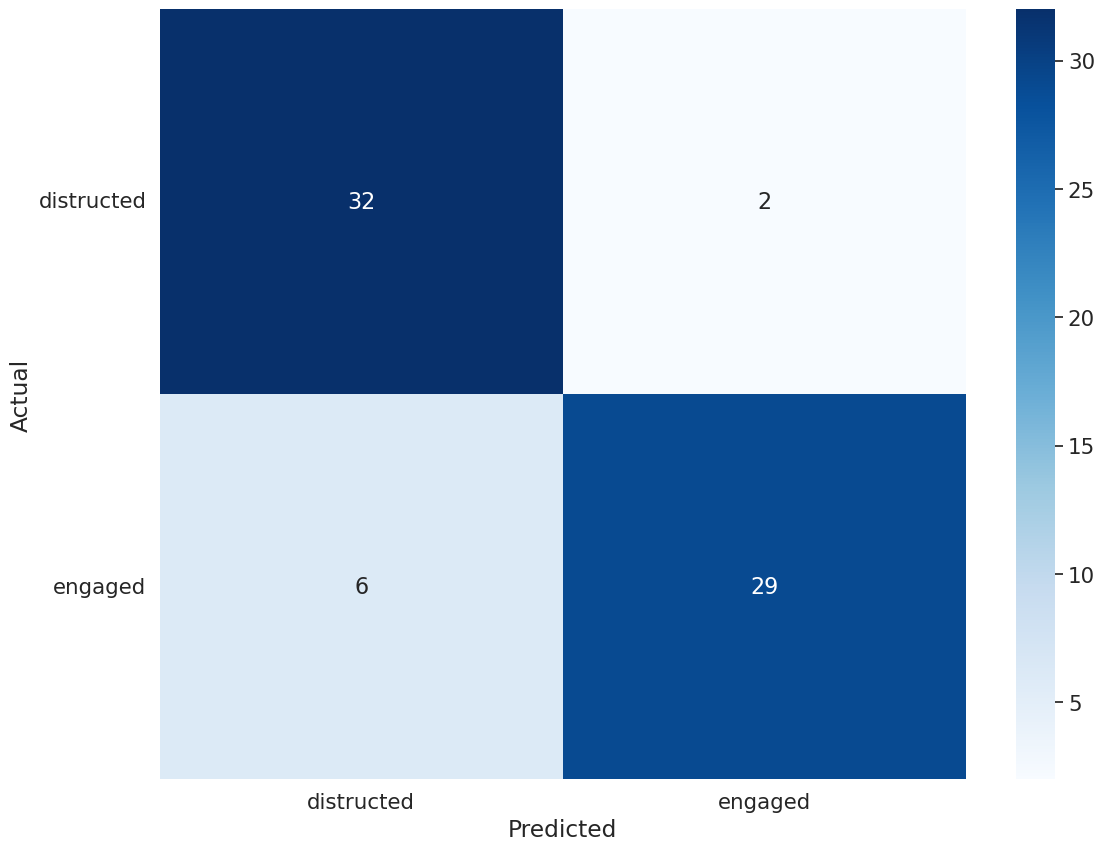

In [204]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [205]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.7857142857142858
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.8571428571428571
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.7857142857142857
	Total acc:  0.7978021978021979
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.7978021978021979
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 1.0
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 1

### Features enet_b2_8

In [206]:
base_model_key = 'enet_b2_8.pt'
FEATURE_VECTOR_DIM = 2816

In [207]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [208]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [209]:
print(len(eng_vid2features))

80


#### Attention std

In [210]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [211]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [212]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [213]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [214]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [215]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [216]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.7142857142857143
Egor : 14
14 0.8571428571428571
Katya : 14
14 0.42857142857142855
Den : 14
14 0.2857142857142857
Total acc:  0.6109890109890109


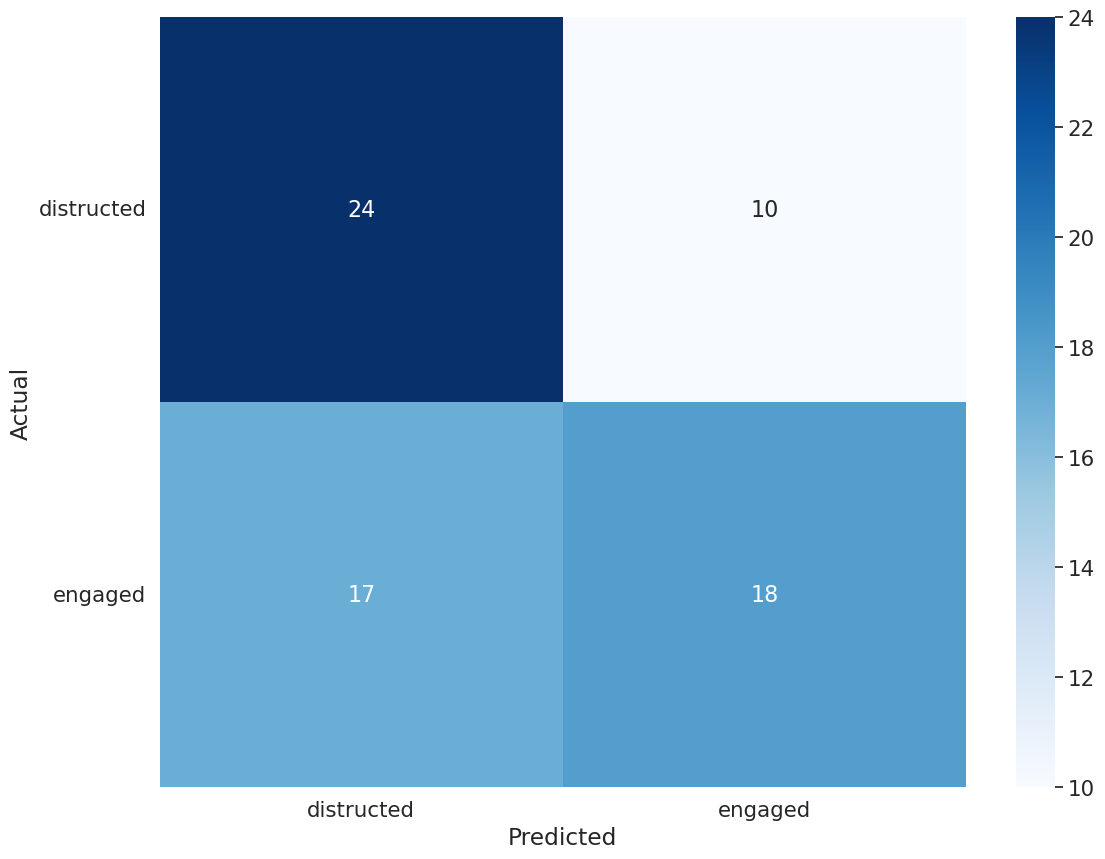

In [217]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [218]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.9285714285714286
Actor Katya
14 0.7857142857142857
Actor Den
14 0.9285714285714286
Total acc:  0.8989010989010989


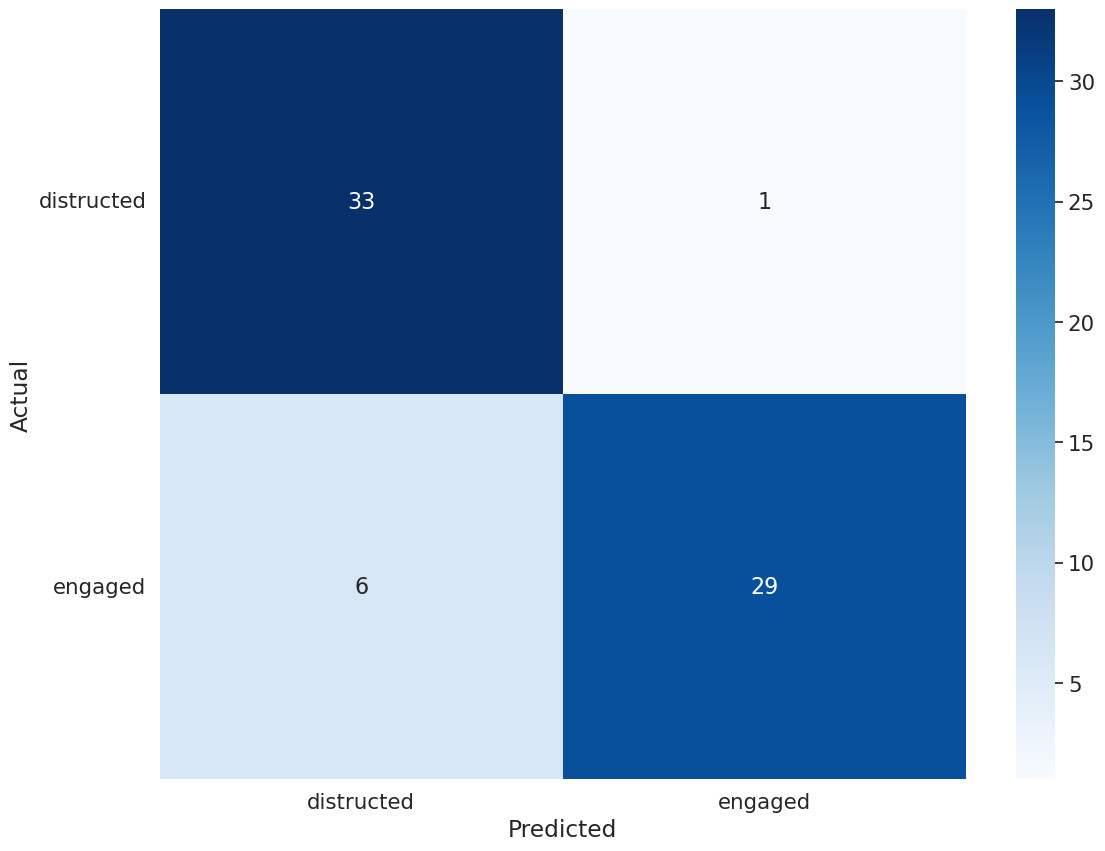

In [219]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [220]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.5714285714285714
	Total acc:  0.7285714285714286
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 1.0
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.8285714285714286
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.8835164835164836
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.8978021978021978
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 1.0
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 0.92857142857142

##### Self-attention

In [221]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [222]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [223]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention_8 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [224]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [225]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.7857142857142857
Katya : 14
14 0.5714285714285714
Den : 14
14 0.21428571428571427
Total acc:  0.5967032967032967


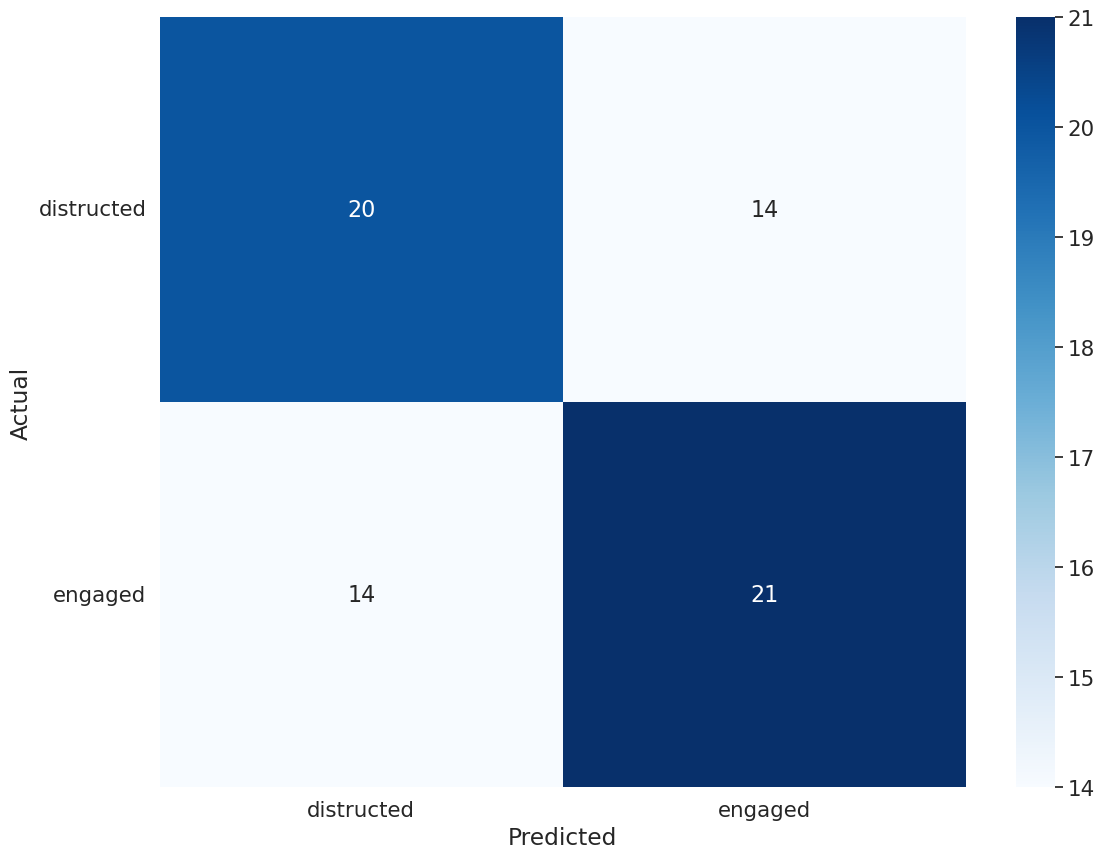

In [226]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [227]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.7857142857142857
Actor Katya
14 0.6428571428571429
Actor Den
14 0.9285714285714286
Total acc:  0.8571428571428571


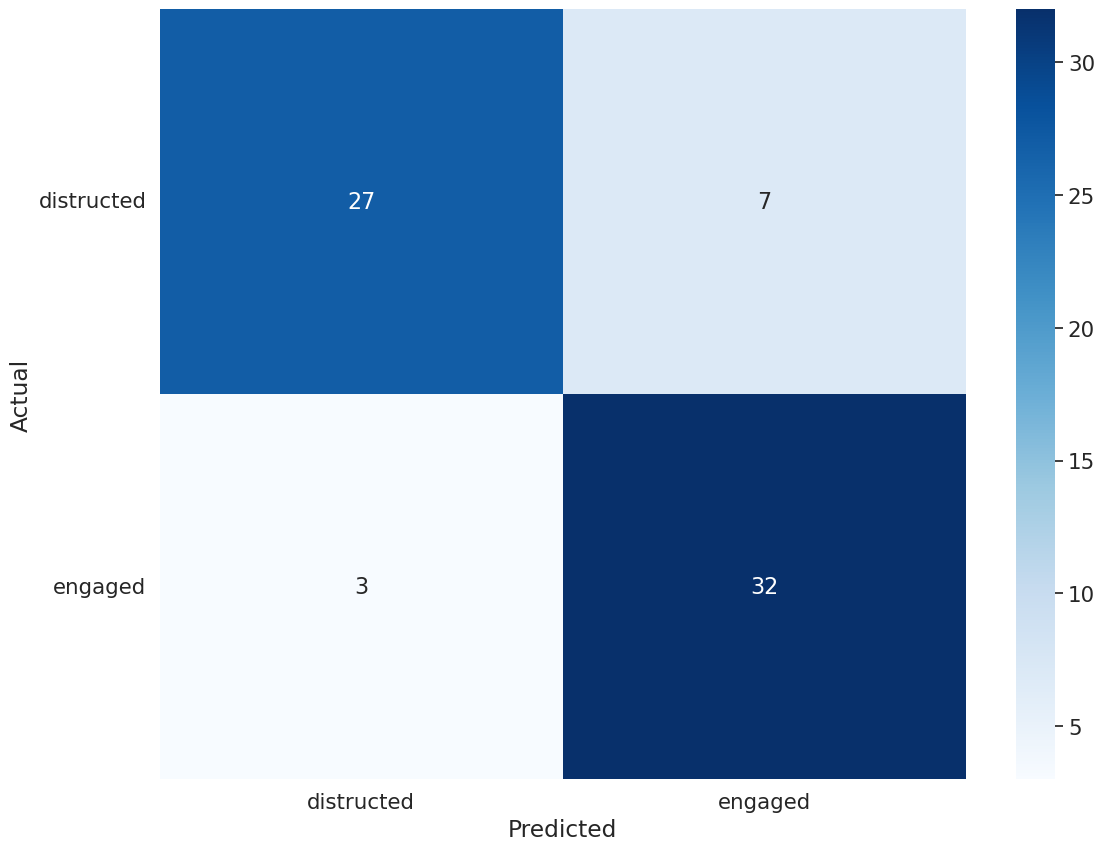

In [228]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [229]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.5714285714285714
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.5714285714285714
		Actor Den
14 0.9285714285714286
	Total acc:  0.7
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.6428571428571429
		Actor Den
14 0.7857142857142857
	Total acc:  0.7142857142857142
Videos num:  3
		Actor Yana
13 0.6923076923076923
		Actor Kate
14 1.0
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.6428571428571429
	Total acc:  0.7527472527472527
Videos num:  4
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.7142857142857143
		Actor Den
14 1.0
	Total acc:  0.853846153846154
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		

#### Attention max

In [230]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [231]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [232]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [233]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [234]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2817      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [235]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [236]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.5
Egor : 14
14 0.6428571428571429
Katya : 14
14 0.7142857142857143
Den : 14
14 0.5
Total acc:  0.6098901098901099


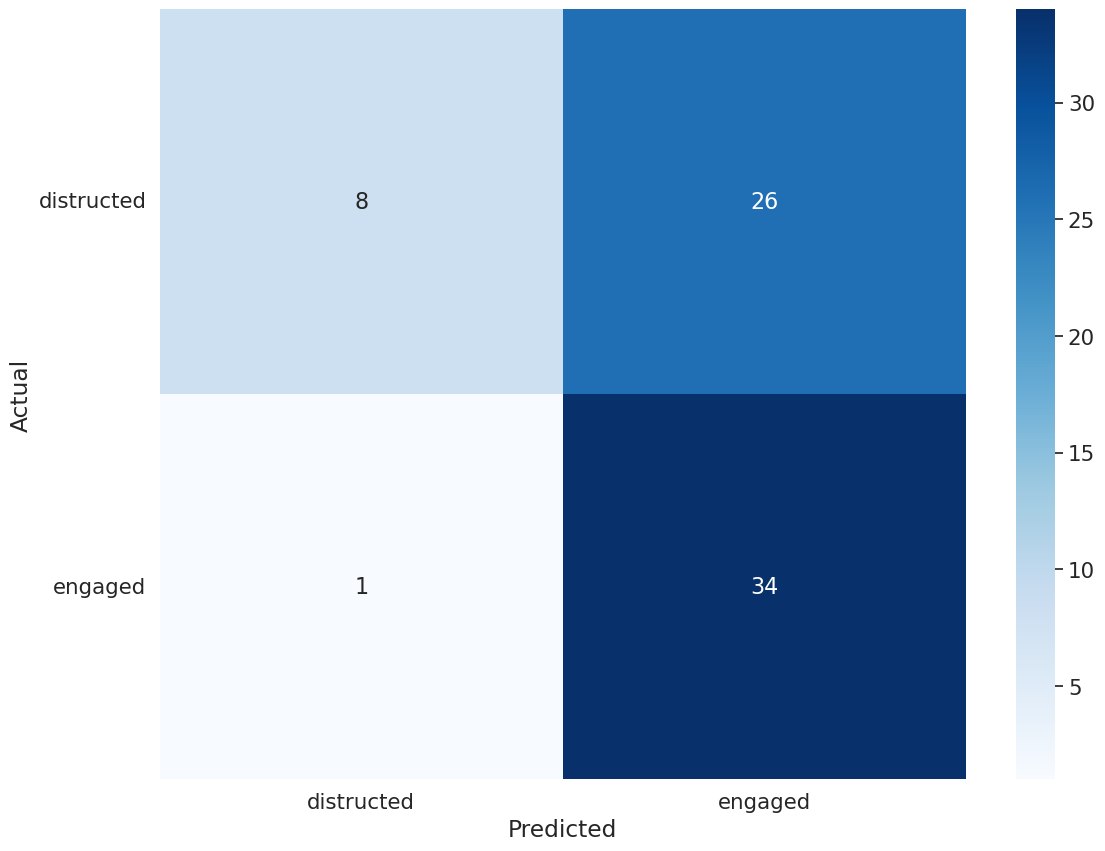

In [237]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [238]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.7142857142857143
Actor Katya
14 0.7142857142857143
Actor Den
14 0.9285714285714286
Total acc:  0.8417582417582418


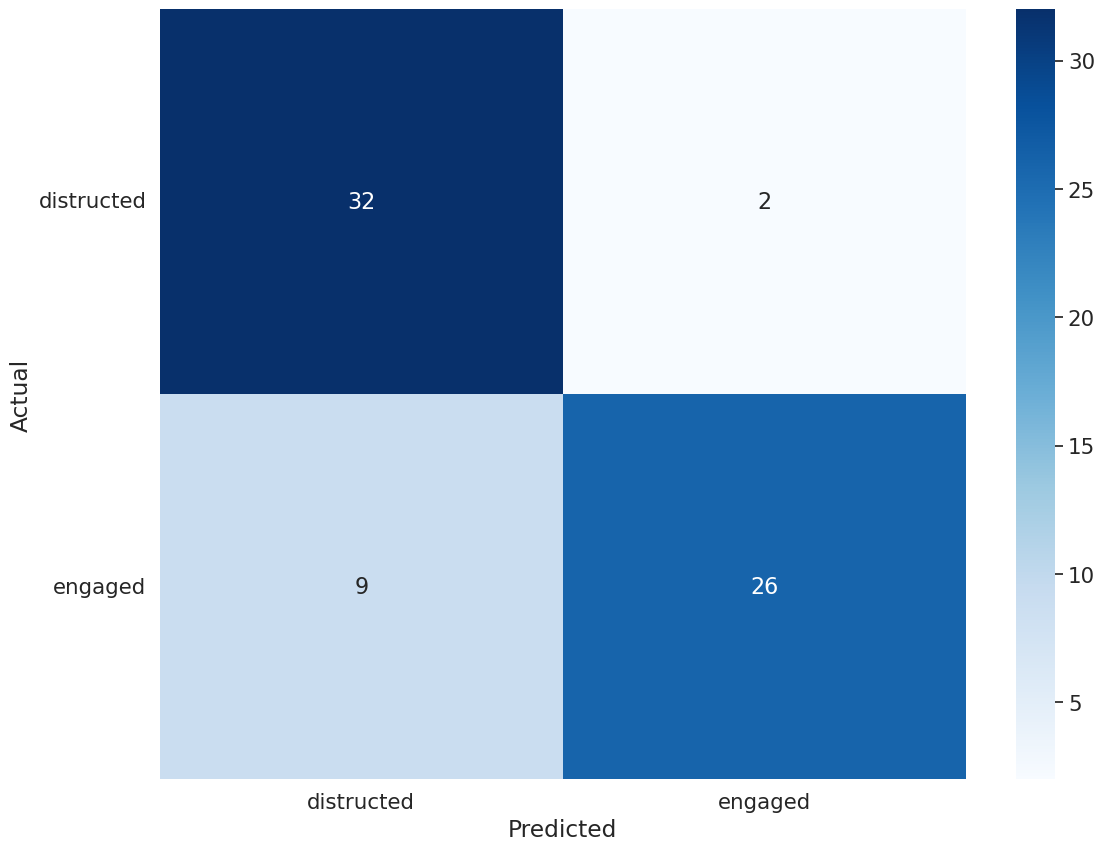

In [239]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [240]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.7857142857142858
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.7857142857142857
	Total acc:  0.7857142857142857
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.7142857142857143
	Total acc:  0.7824175824175825
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.6428571428571429
		Actor Den
14 1.0
	Total acc:  0.8549450549450549
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 1.0
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.9285714285714286
	

##### Self-attention

In [241]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [242]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [243]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2816)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1441792   ['image_set[0][0]']           
                                                                                                  
 attention_9 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [244]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [245]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.5
Egor : 14
14 0.6428571428571429
Katya : 14
14 0.5714285714285714
Den : 14
14 0.5
Total acc:  0.5813186813186814


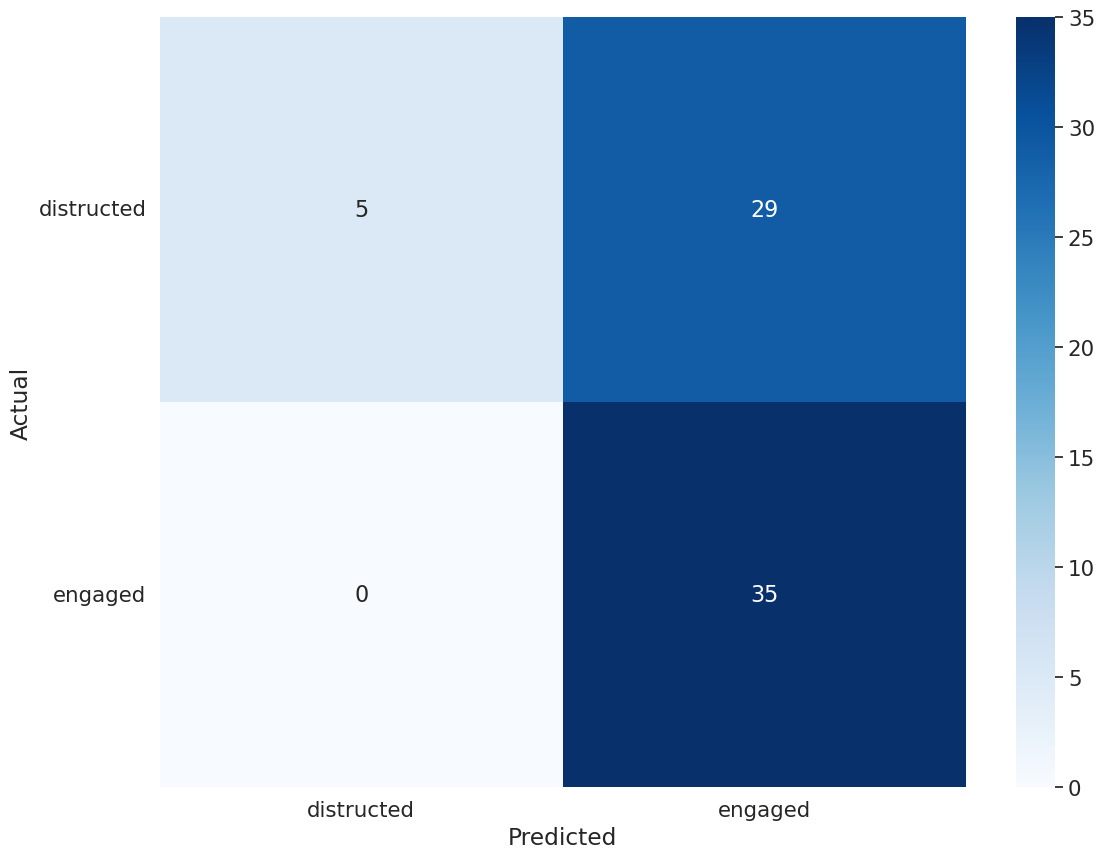

In [246]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [247]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 0.7142857142857143
Actor Katya
14 0.8571428571428571
Actor Den
14 0.9285714285714286
Total acc:  0.8857142857142858


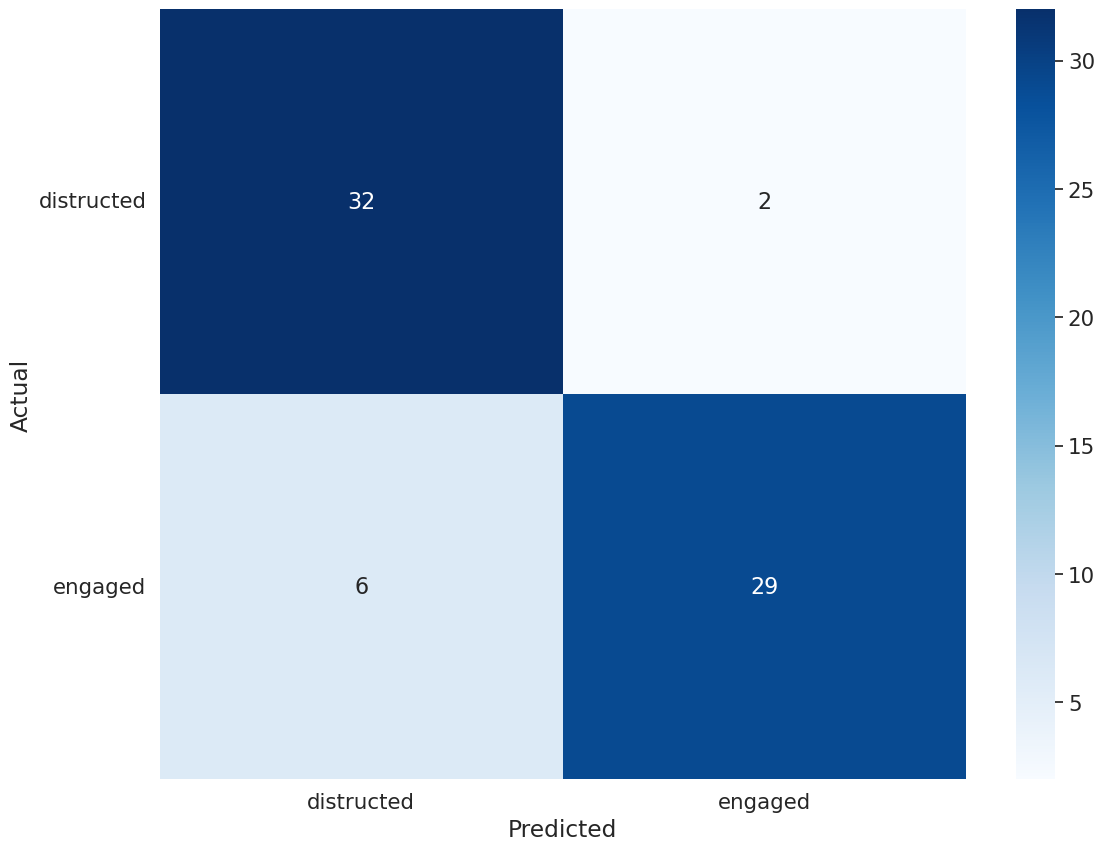

In [248]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [249]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.7714285714285716
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.7142857142857143
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7142857142857143
	Total acc:  0.8120879120879121
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 1.0
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.8549450549450549
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.8571428571428571
	

### Features mobilenet_7

In [250]:
base_model_key = 'mobilenet_7.h5'
FEATURE_VECTOR_DIM = 2048

In [251]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [252]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [253]:
print(len(eng_vid2features))

80


#### Attention std

In [254]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [255]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [256]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [257]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [258]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [259]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [260]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.8461538461538461
Kate : 14
14 0.42857142857142855
Egor : 14
14 0.5714285714285714
Katya : 14
14 0.5
Den : 14
14 0.35714285714285715
Total acc:  0.5406593406593406


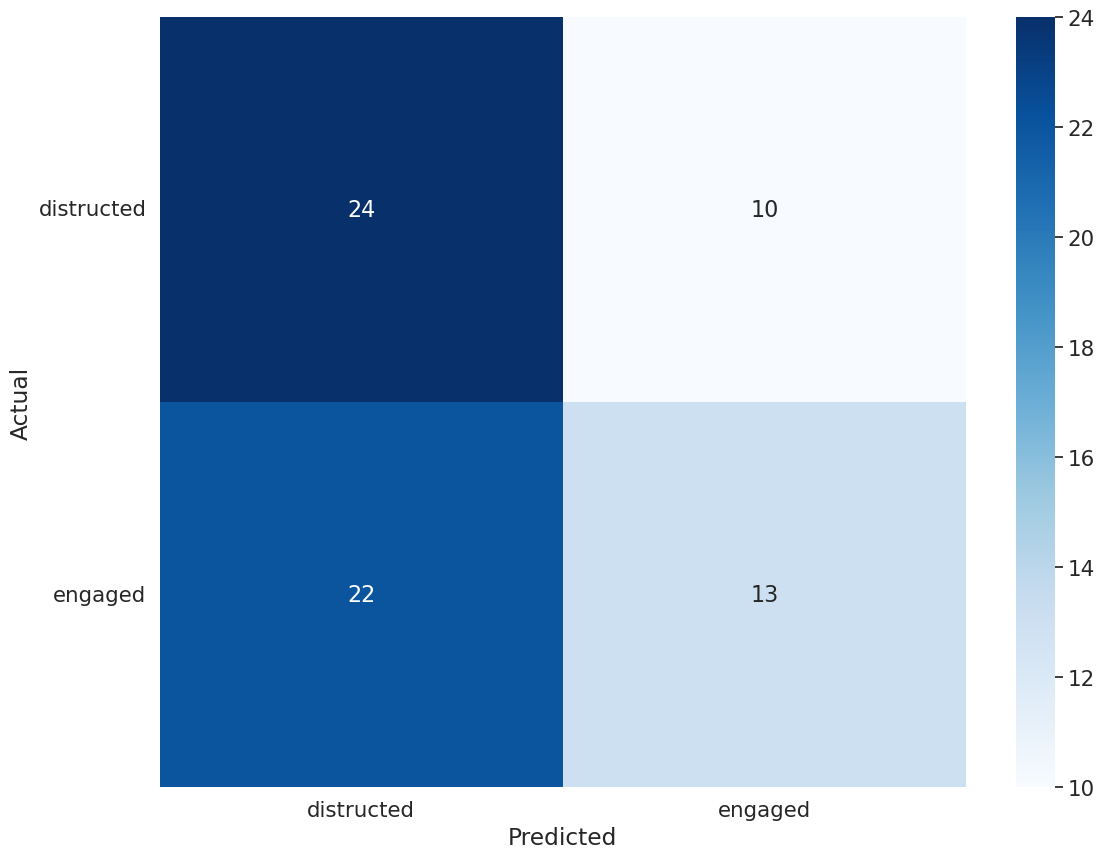

In [261]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [262]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.7857142857142857
Actor Egor
14 1.0
Actor Katya
14 0.9285714285714286
Actor Den
14 0.9285714285714286
Total acc:  0.9285714285714286


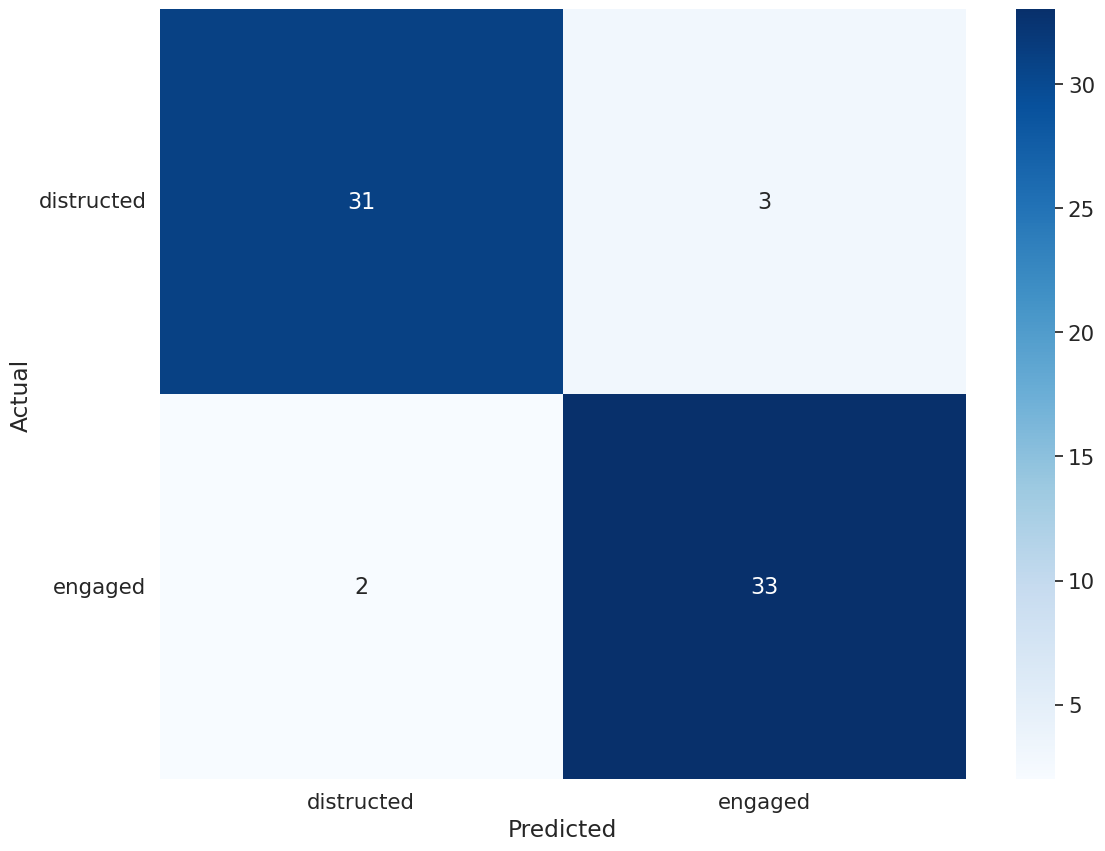

In [263]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [264]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.7428571428571428
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.7857142857142857
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.7857142857142857
	Total acc:  0.8274725274725275
Videos num:  4
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.7142857142857143
	Total acc:  0.8274725274725275
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.785714285

##### Self-attention

In [265]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [266]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [267]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention_10 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [268]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [269]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.8461538461538461
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.5714285714285714
Katya : 14
14 0.5714285714285714
Den : 14
14 0.5714285714285714
Total acc:  0.6263736263736263


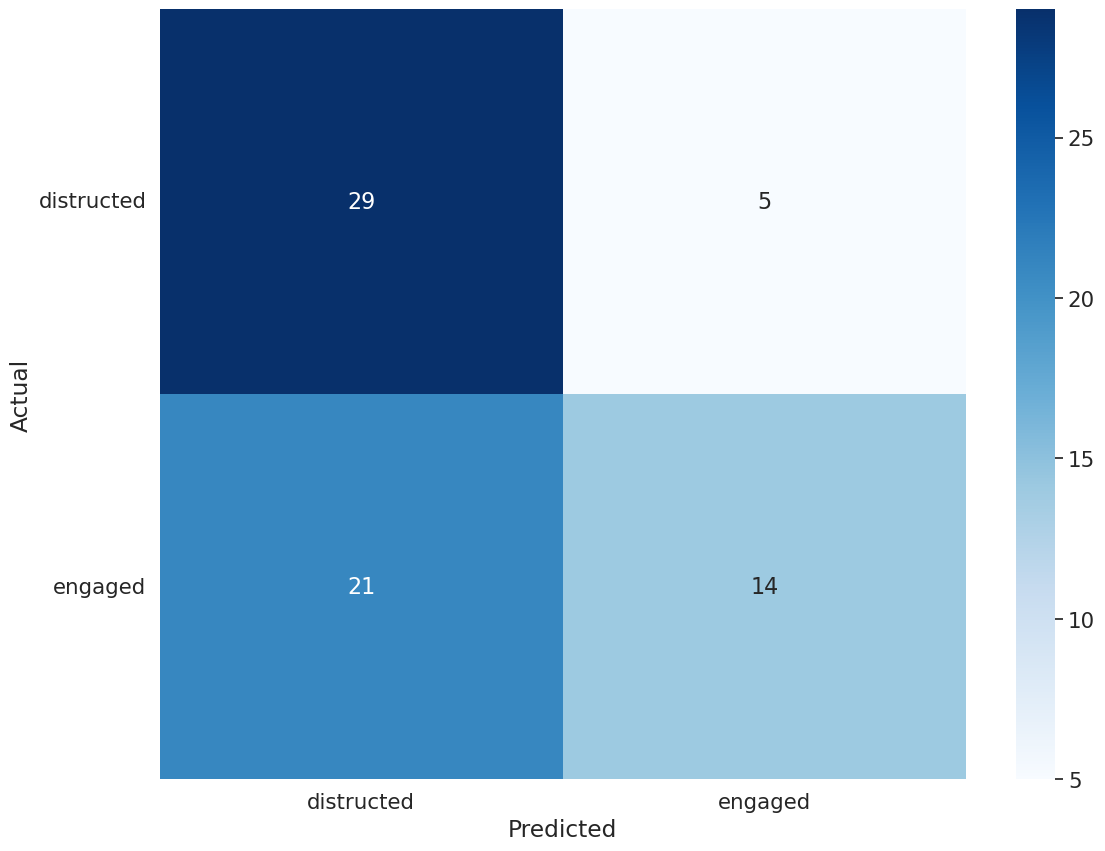

In [270]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [271]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 0.9285714285714286
Actor Den
14 0.8571428571428571
Total acc:  0.9274725274725274


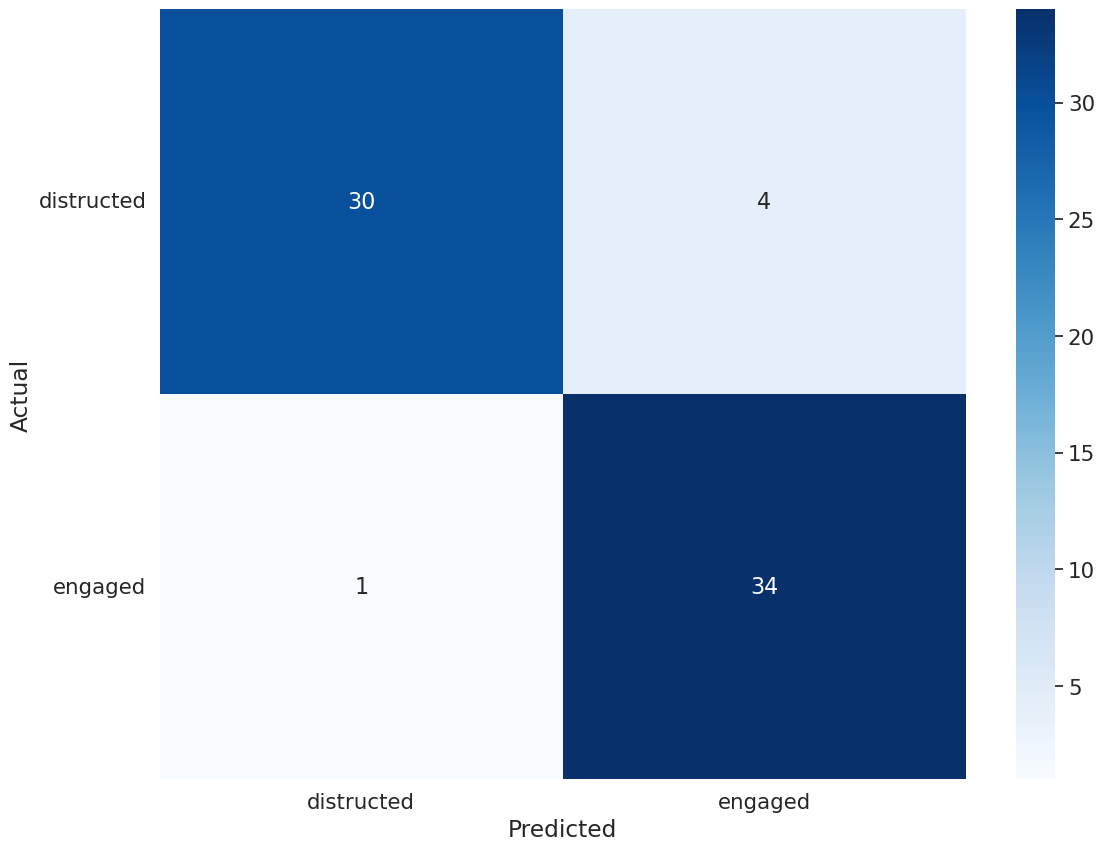

In [272]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [273]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.5714285714285714
	Total acc:  0.7
Videos num:  2
		Actor Yana
14 0.8571428571428571
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7142857142857143
	Total acc:  0.8285714285714285
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 1.0
		Actor Den
14 0.8571428571428571
	Total acc:  0.8835164835164834
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.9285714285714286
		Actor Den
14 1.0
	Total acc:  0.8978021978021978
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 0

#### Attention max

In [274]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [275]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [276]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [277]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [278]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [279]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [280]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.5
Egor : 14
14 0.8571428571428571
Katya : 14
14 0.5714285714285714
Den : 14
14 0.5
Total acc:  0.6395604395604396


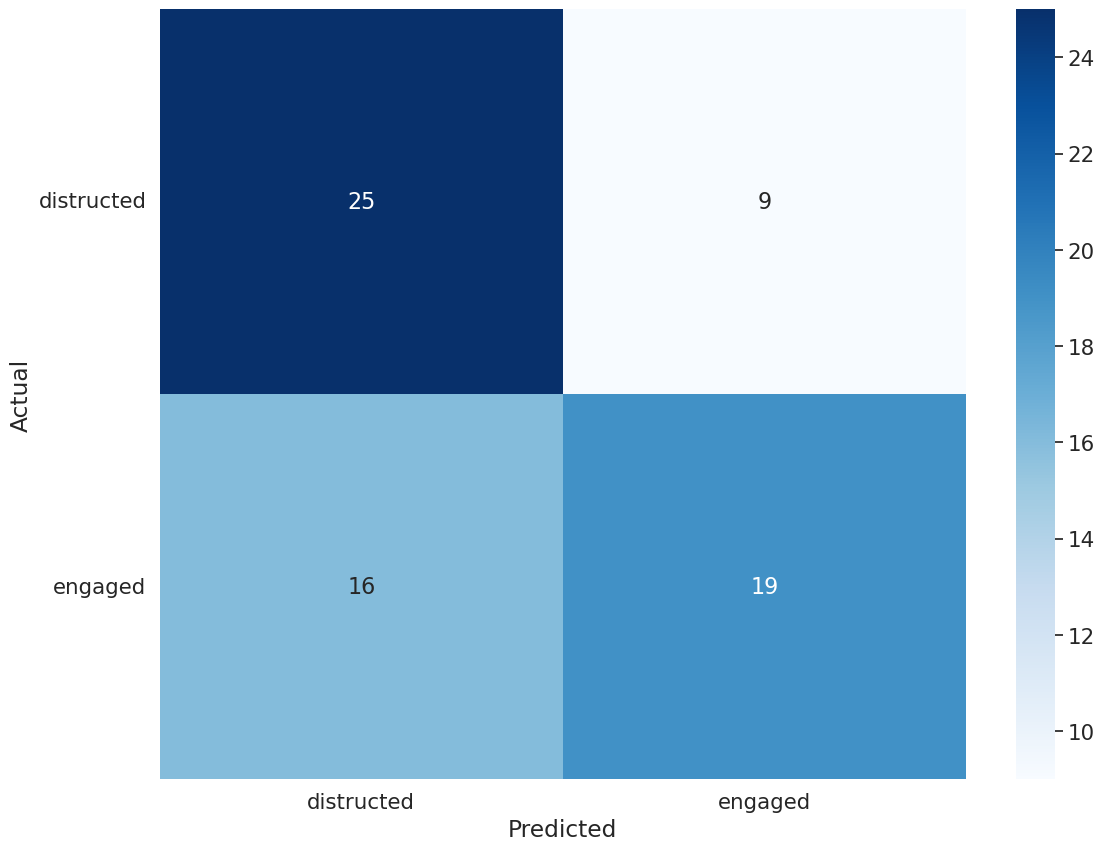

In [281]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [282]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.8571428571428571
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 1.0
Total acc:  0.956043956043956


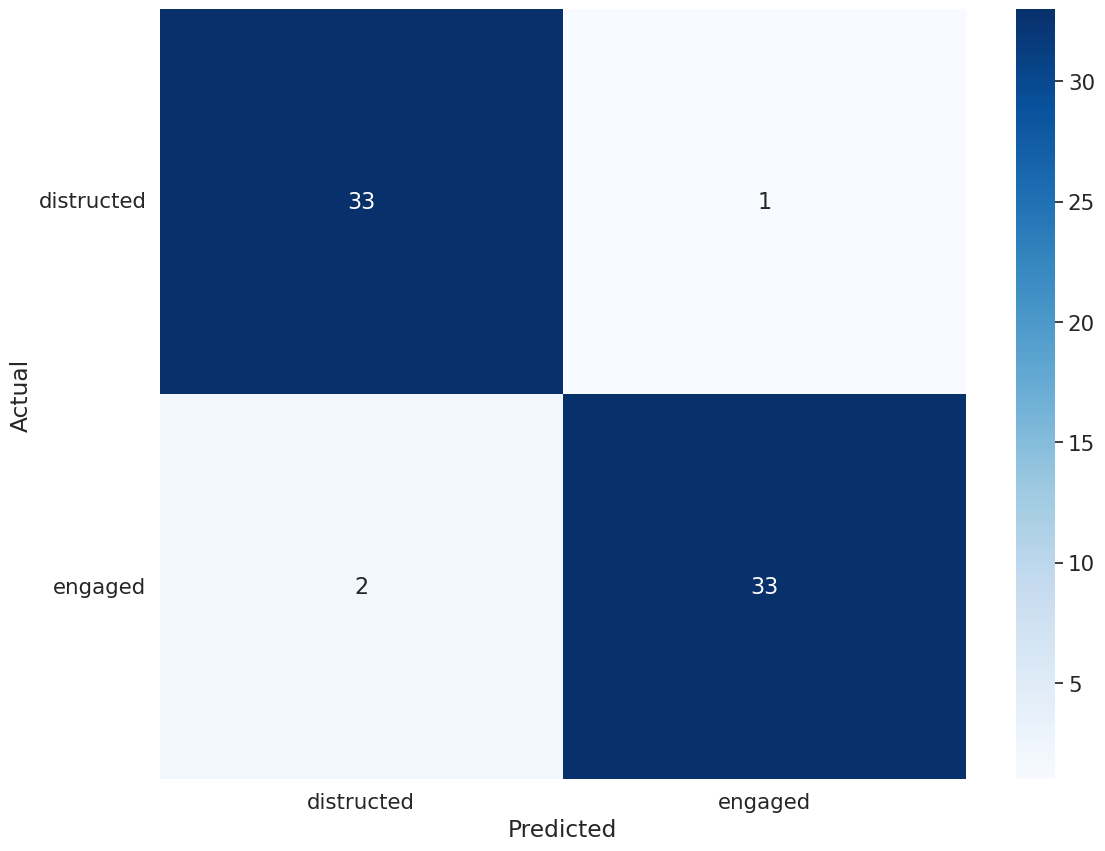

In [283]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [284]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 1.0
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7857142857142857
	Total acc:  0.7857142857142856
Videos num:  2
		Actor Yana
14 0.9285714285714286
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7142857142857143
		Actor Den
14 0.7142857142857143
	Total acc:  0.7714285714285716
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.6428571428571429
	Total acc:  0.7549450549450549
Videos num:  4
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8989010989010989
Videos num:  5
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 0.928

##### Self-attention

In [285]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [286]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [287]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention_11 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [288]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [289]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.6923076923076923
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.7142857142857143
Katya : 14
14 0.5714285714285714
Den : 14
14 0.5
Total acc:  0.6241758241758243


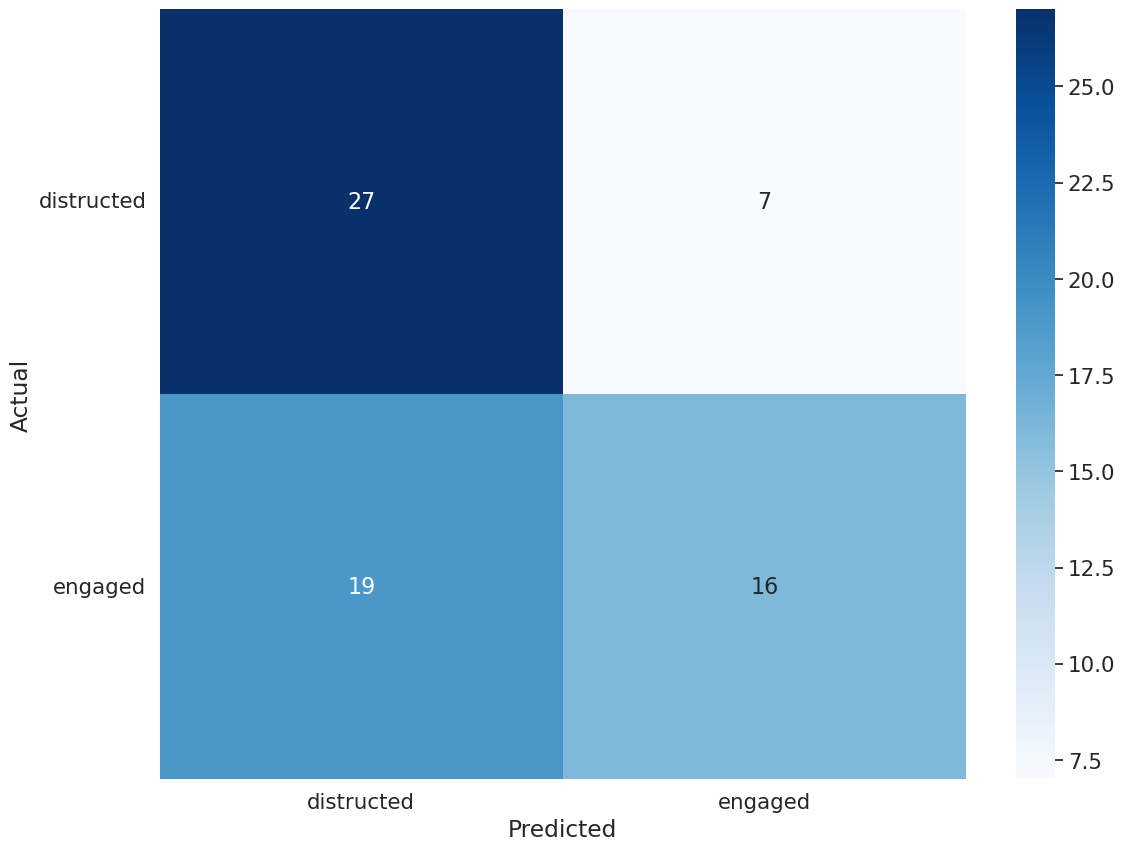

In [290]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [291]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 1.0
Total acc:  0.9857142857142858


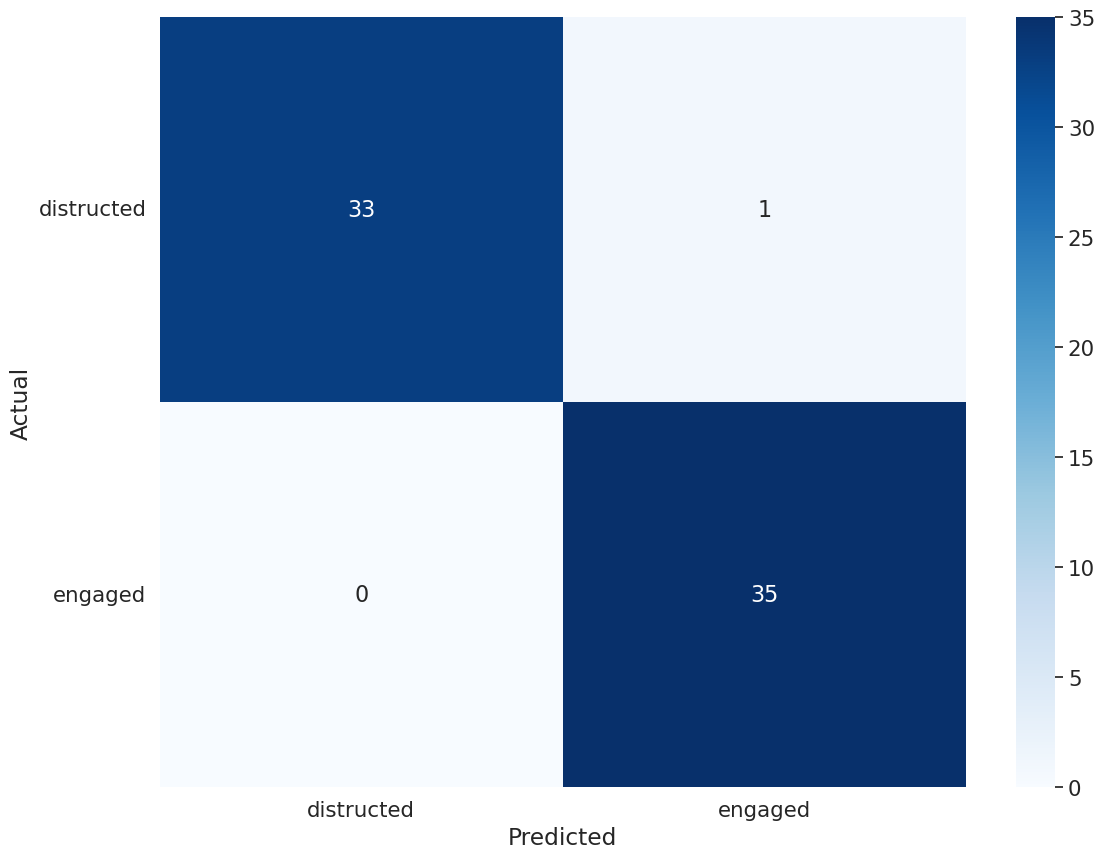

In [292]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [293]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.5714285714285714
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.7142857142857143
	Total acc:  0.7428571428571429
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.8142857142857143
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.7142857142857143
	Total acc:  0.8263736263736263
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8835164835164836
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.9285714285714286
		Actor Egor
14 0.9285714285714286
		Actor

### Features enet_b0_8_va_mtl

In [294]:
base_model_key = 'enet_b0_8_va_mtl.pt'
FEATURE_VECTOR_DIM = 2560

In [295]:
append_logs_dump(USER_ADAPTED_LOG, [base_model_key])

In [296]:
engaged_pickle = USERS_DATASET + 'engaged_features_{}.pickle'.format(base_model_key)
distracted_pickle = USERS_DATASET + 'distracted_features_{}.pickle'.format(base_model_key)
eng_vid2features = extract_or_read_features_my_ds(engaged_pickle)
dis_vid2features = extract_or_read_features_my_ds(distracted_pickle)
vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)

In [297]:
print(len(eng_vid2features))

80


#### Attention std

In [298]:
stat_function=np.std
append_logs_dump(USER_ADAPTED_LOG, ["Attention std:"])

In [299]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [300]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [301]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [302]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [303]:
weights_name = WEIGHTS_DIR + "{}_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [304]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)

append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.38461538461538464
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7857142857142857
Katya : 14
14 0.7142857142857143
Den : 14
14 0.6428571428571429
Total acc:  0.6197802197802198


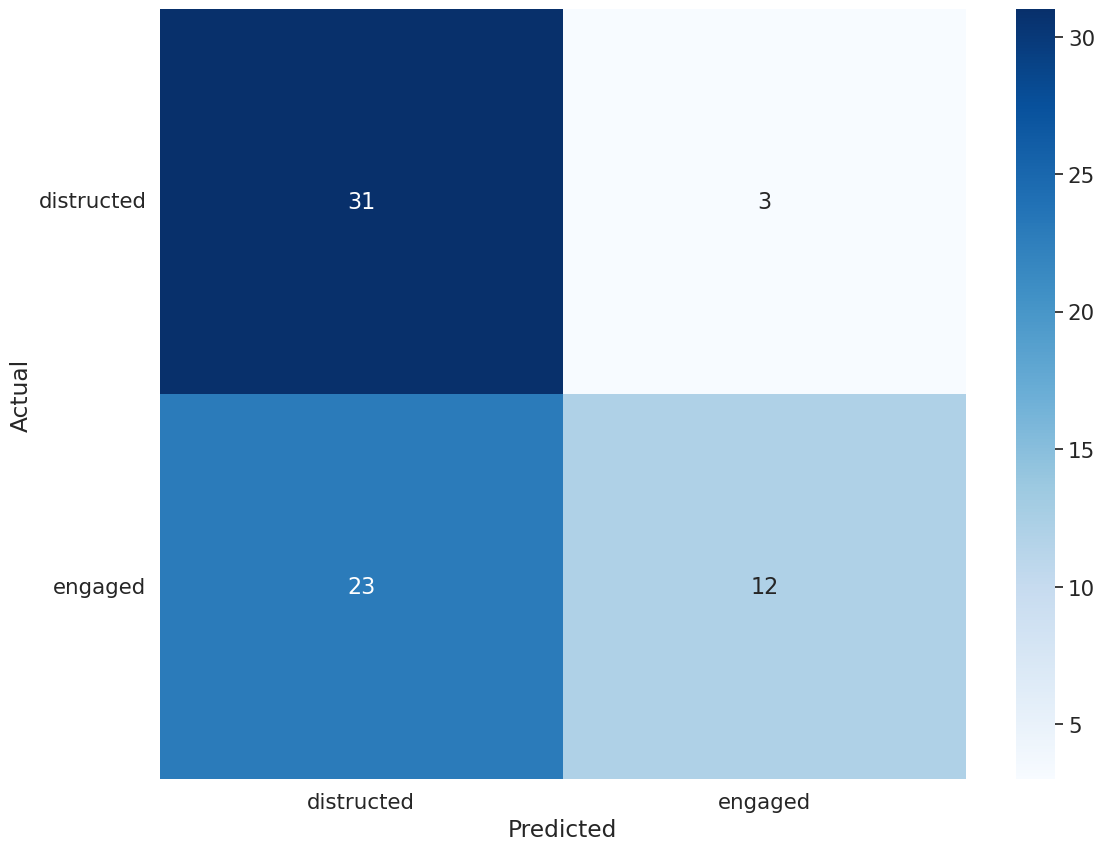

In [305]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [306]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.9285714285714286
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 1.0
Total acc:  0.9703296703296704


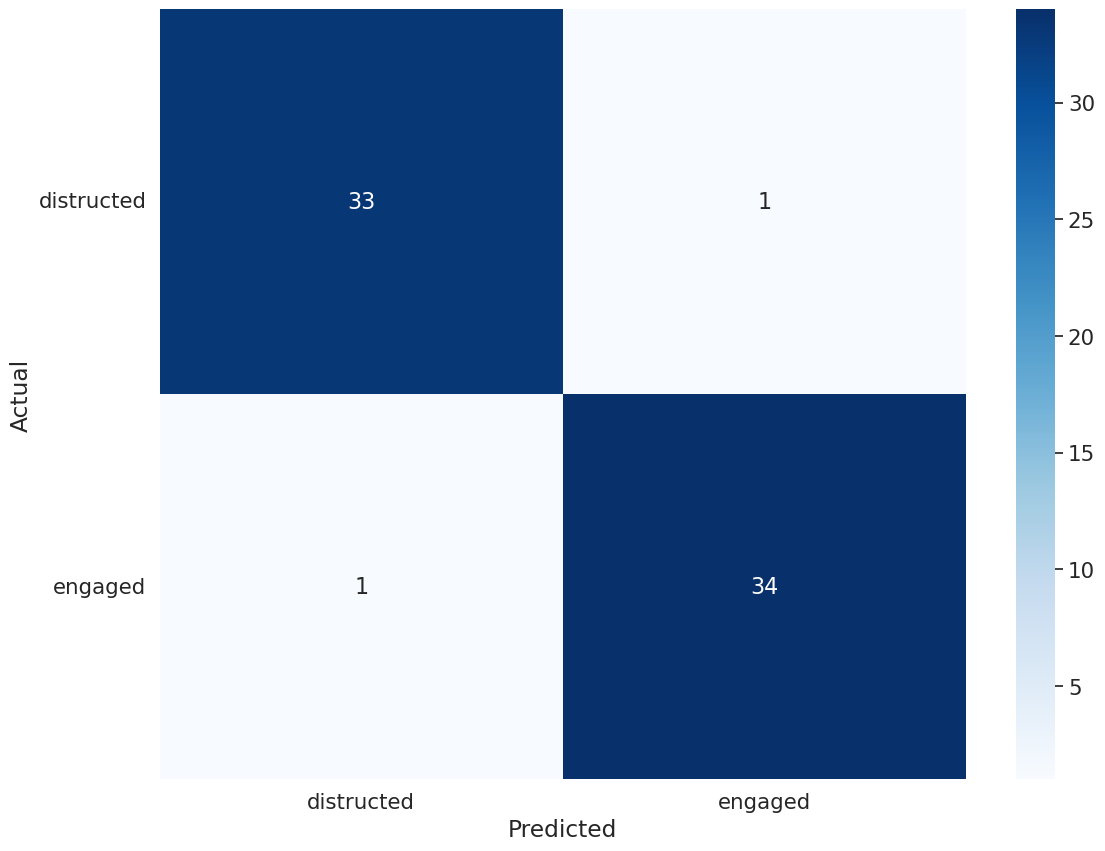

In [307]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [308]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.9285714285714286
	Total acc:  0.8
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.7857142857142857
		Actor Den
14 1.0
	Total acc:  0.8571428571428571
Videos num:  3
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 0.8571428571428571
	Total acc:  0.8835164835164834
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 0.8571428571428571
	Total acc:  0.8692307692307691
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 1.0
	Total acc: 

##### Self-attention

In [309]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [310]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [311]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_12 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [312]:
weights_name = WEIGHTS_DIR + "{}_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [313]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.46153846153846156
Kate : 14
14 0.42857142857142855
Egor : 14
14 0.7857142857142857
Katya : 14
14 0.9285714285714286
Den : 14
14 0.6428571428571429
Total acc:  0.6494505494505494


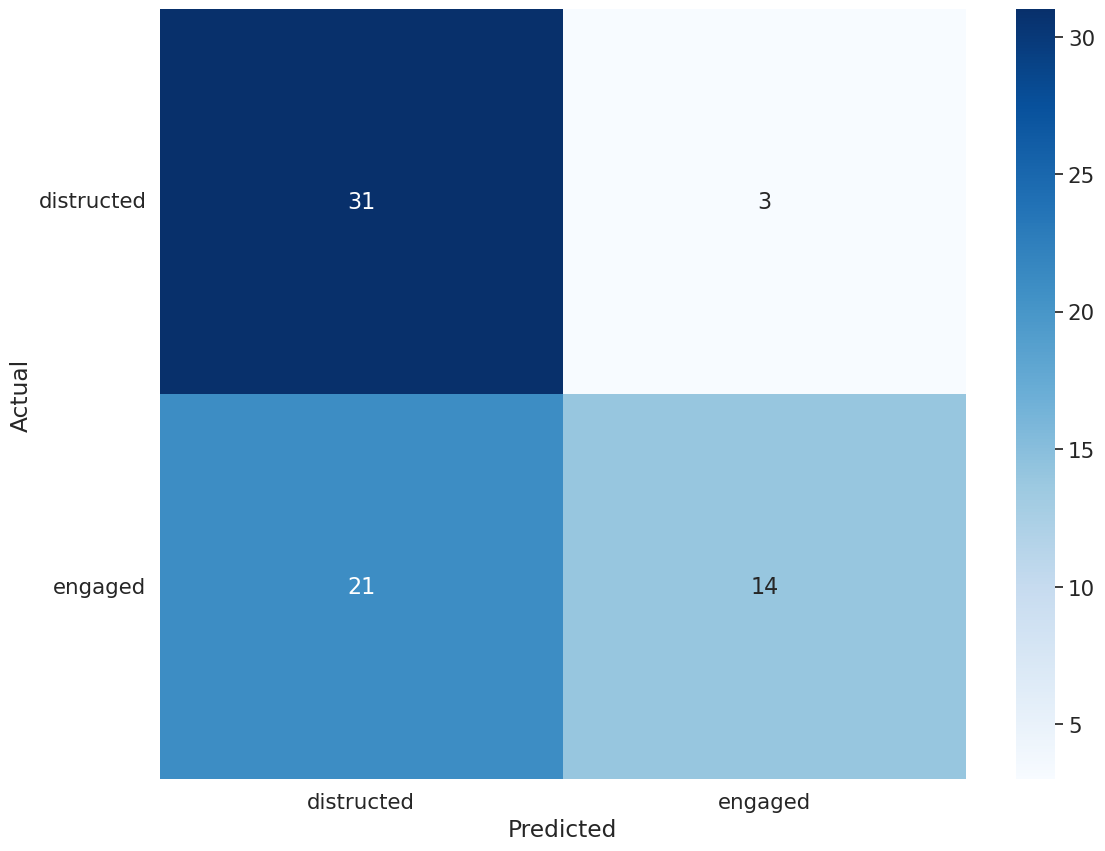

In [314]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [315]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 1.0
Actor Kate
14 0.7857142857142857
Actor Egor
14 0.9285714285714286
Actor Katya
14 0.9285714285714286
Actor Den
14 1.0
Total acc:  0.9285714285714286


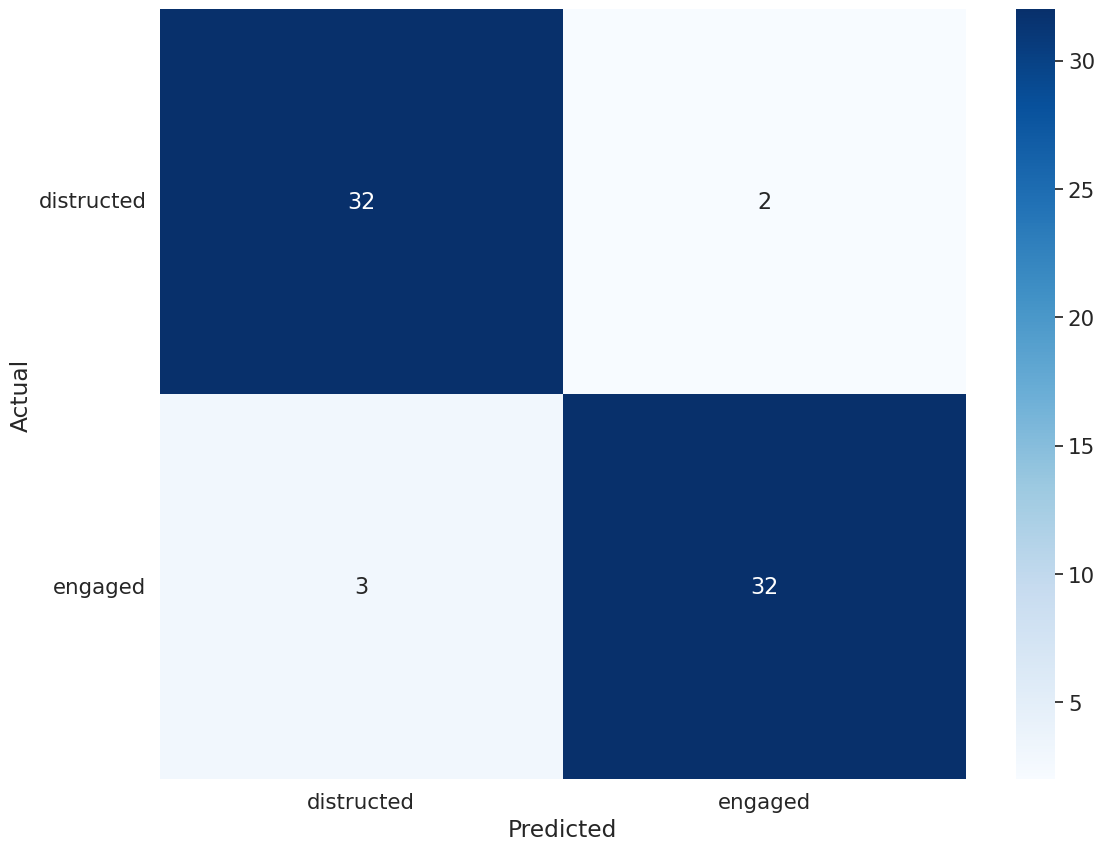

In [316]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [317]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.6428571428571429
		Actor Egor
14 0.6428571428571429
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.7142857142857143
	Total acc:  0.7000000000000001
Videos num:  2
		Actor Yana
14 0.6428571428571429
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.9285714285714286
	Total acc:  0.8428571428571429
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.7967032967032968
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.8263736263736263
Videos num:  5
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.5714285714285714
		Actor Egor
14 0.785714285

#### Attention max

In [318]:
stat_function=np.max
append_logs_dump(USER_ADAPTED_LOG, ["Attention max:"])

In [319]:
train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)

##### Single attention

In [320]:
append_logs_dump(USER_ADAPTED_LOG, ["Single attention:"])

In [321]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [322]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [323]:
weights_name = WEIGHTS_DIR + "{}_max_single_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [324]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.5714285714285714
Egor : 14
14 0.7142857142857143
Katya : 14
14 1.0
Den : 14
14 0.6428571428571429
Total acc:  0.7395604395604396


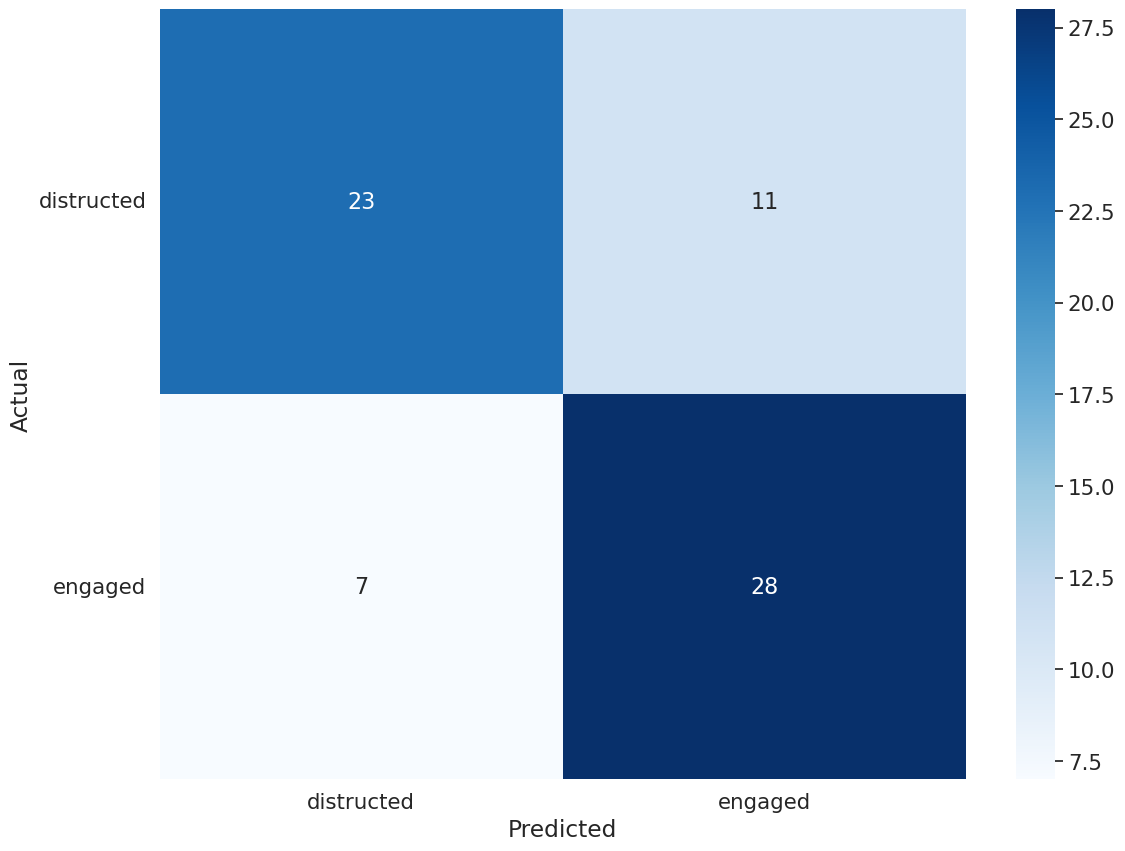

In [325]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [326]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.8571428571428571
Actor Egor
14 1.0
Actor Katya
14 1.0
Actor Den
14 0.9285714285714286
Total acc:  0.9417582417582417


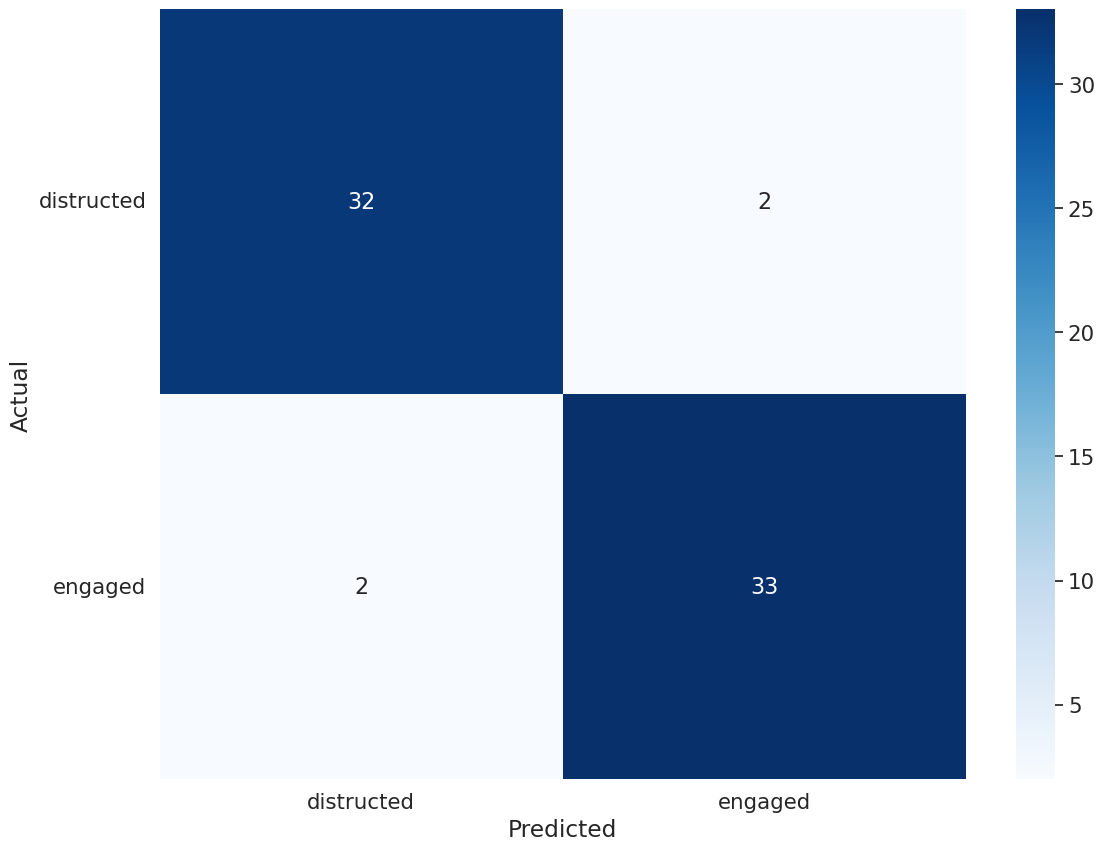

In [327]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [328]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_single_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7857142857142857
		Actor Katya
14 0.7857142857142857
		Actor Den
14 0.8571428571428571
	Total acc:  0.7857142857142857
Videos num:  2
		Actor Yana
14 0.7142857142857143
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7142857142857143
		Actor Den
14 1.0
	Total acc:  0.7857142857142858
Videos num:  3
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8538461538461538
Videos num:  4
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8835164835164836
Videos num:  5
		Actor Yana
13 0.7692307692307693
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 1.0
		Actor Den
14 1

##### Self-attention

In [329]:
append_logs_dump(USER_ADAPTED_LOG, ["Self attention:"])

In [330]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

In [331]:
if CONVERT2INT:
    pred=Dense(N_CLASSES,activation='softmax')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_accuracy',True)
else:
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
    modelAtn.summary()

    save_best_model = SaveBestModel('val_loss',False)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_13 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

In [332]:
weights_name = WEIGHTS_DIR + "{}_max_self_attention_independent_bin_class_best.h5".format(base_model_key)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [333]:
total_acc = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    acc, preds, labels = print_acc(modelAtn, test_vid2features[k]['features'], test_vid2features[k]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, ["0", str(total_acc * 100)])

Yana : 14
13 0.7692307692307693
Kate : 14
14 0.6428571428571429
Egor : 14
14 0.7142857142857143
Katya : 14
14 1.0
Den : 14
14 0.7857142857142857
Total acc:  0.7824175824175824


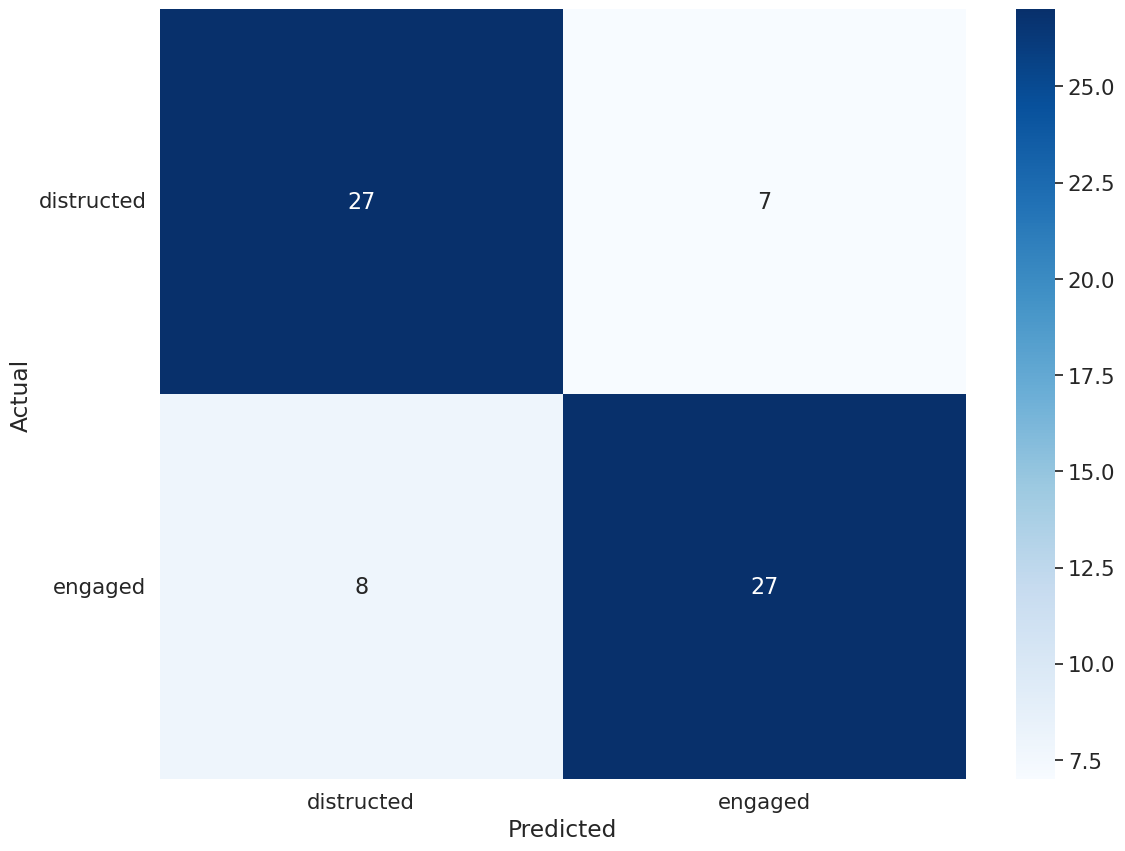

In [334]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning


In [335]:
from copy import deepcopy

total_acc = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

    acc, preds, labels = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    total_acc += acc
    all_preds.extend(preds)
    all_labels.extend(labels)
    weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_bin_class.h5".format(base_model_key, actor)
    save_weights(modelAtn, weights_file_name)
total_acc /= len(test_vid2features.keys())
print('Total acc: ', total_acc)
append_logs_dump(USER_ADAPTED_LOG, [str(TRAIN_VIDEOS_COUNT), str(total_acc * 100)])

Actor Yana
13 0.9230769230769231
Actor Kate
14 0.8571428571428571
Actor Egor
14 0.8571428571428571
Actor Katya
14 0.9285714285714286
Actor Den
14 1.0
Total acc:  0.9131868131868132


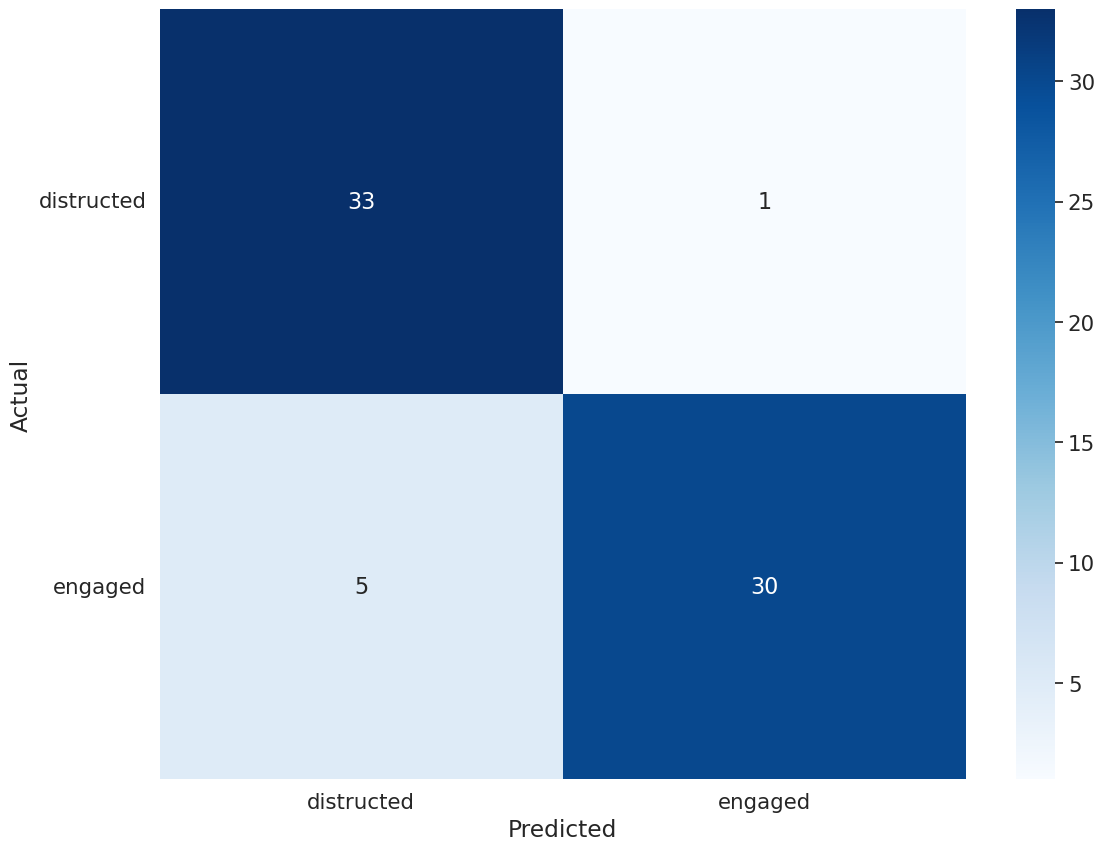

In [336]:
draw_confusion_matrix(all_preds, all_labels)

###### Per user tuning by videos


In [337]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT + 1):
    train_vid2features, test_vid2features = split_to_sets(i, vid2features_list)
    total_acc = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=20, verbose=0)

        acc, _, _ = print_acc(modelAtn, test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        total_acc += acc
        weights_file_name = USERS_WEIGHTS + "{}_max_self_attention_adapted_{}_vid_{}_bin_class.h5".format(base_model_key, actor, i)
        save_weights(modelAtn, weights_file_name)
    total_acc /= len(test_vid2features.keys())
    print('\tTotal acc: ', total_acc)
    append_logs_dump(USER_ADAPTED_LOG, [str(i), str(total_acc * 100)])

Videos num:  1
		Actor Yana
14 0.5714285714285714
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.7142857142857143
		Actor Den
14 1.0
	Total acc:  0.7428571428571429
Videos num:  2
		Actor Yana
14 0.7857142857142857
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.7142857142857143
		Actor Katya
14 0.9285714285714286
		Actor Den
14 0.9285714285714286
	Total acc:  0.8428571428571429
Videos num:  3
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7857142857142857
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 0.8571428571428571
	Total acc:  0.856043956043956
Videos num:  4
		Actor Yana
13 0.9230769230769231
		Actor Kate
14 0.7142857142857143
		Actor Egor
14 0.8571428571428571
		Actor Katya
14 0.8571428571428571
		Actor Den
14 1.0
	Total acc:  0.8703296703296705
Videos num:  5
		Actor Yana
13 0.8461538461538461
		Actor Kate
14 0.8571428571428571
		Actor Egor
14 0.9285714285714286
		Actor Katya
14 1.0
		